# [TUM - miniprojekt] Przebieg procesu uczenia dla sieci przy użyciu różnych algorytmów optymalizacji
## Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395)

In [1]:
# %pip install torch torchvision tqdm pandas matplotlib seaborn

In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from glob import glob
from tqdm import tqdm

In [3]:
DATASET_PATH: str = "./datasets"
MODEL_PATH: str = "./models"
RESULT_PATH: str = "./results"

BATCH_SIZE: int = 4

In [4]:
def get_dataset(dataset, batch_size: int = BATCH_SIZE) -> tuple:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=True)
    valid_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=False)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [5]:
datasets = {
    "FashionMNIST": torchvision.datasets.FashionMNIST,
    "MNIST": torchvision.datasets.MNIST,
}

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(device)


class CNNClassifier(nn.Module):
    def __init__(self, number_of_channels: int = 1, number_of_classes: int = 10) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(number_of_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

cuda


In [7]:
optimizers = {
    "SGD": optim.SGD,
    "AdaGrad": optim.Adagrad,
    "Adam": optim.Adam,
    "AdamW": optim.AdamW,
    "RMSprop": optim.RMSprop,
}

In [8]:
loss_fn = nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer, lr: float = 1e-3) -> float:
    model.train()
    optimizer = optimizer(model.parameters(), lr=lr)

    running_loss = 0.0
    avg_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            avg_loss = running_loss / 1000
            print(f"[{i + 1:5d}] loss: {avg_loss:.3f}")
            running_loss = 0.0

    return avg_loss


def valid_epoch(model, valid_loader) -> float:
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / (i + 1)
    return avg_loss

In [9]:
NUMBER_OF_EPOCHS: int = 100

In [10]:
for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    train_loader, valid_loader = get_dataset(dataset)

    for optimizer_name, optimizer in optimizers.items():
        print(f"OPTIMIZER: {optimizer_name}")

        model = CNNClassifier()
        model.to(device)

        best_vloss = np.inf

        results: list = []

        for epoch_number in range(NUMBER_OF_EPOCHS):
            print(f"EPOCH: {epoch_number + 1} / {NUMBER_OF_EPOCHS}")

            avg_loss = train_epoch(model, train_loader, optimizer)

            avg_vloss = valid_epoch(model, valid_loader)

            results.append(
                {
                    "epoch": epoch_number,
                    "train_loss": avg_loss,
                    "valid_loss": avg_vloss,
                }
            )

            print(f"Train Loss: {avg_loss:.3f}, Valid Loss: {avg_vloss:.3f}")

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                if not os.path.exists(MODEL_PATH):
                    os.makedirs(MODEL_PATH)
                torch.save(
                    model.state_dict(), f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth"
                )
            else:
                print(
                    f"Early stopping (no improvement in validation loss in epoch {epoch_number + 1})"
                )
                break

        results_df = pd.DataFrame(results)
        if not os.path.exists(RESULT_PATH):
            os.makedirs(RESULT_PATH)
        results_df.to_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv", index=False)

DATASET: FashionMNIST


100%|██████████| 26421880/26421880 [00:02<00:00, 12800652.96it/s]


Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 277228.86it/s]


Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5015879.81it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26109162.02it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw

OPTIMIZER: SGD
EPOCH: 1 / 100


  7%|▋         | 1066/15000 [00:07<00:41, 335.16it/s]

[ 1000] loss: 2.300


 14%|█▍        | 2063/15000 [00:10<00:38, 334.65it/s]

[ 2000] loss: 2.291


 20%|██        | 3037/15000 [00:13<00:35, 333.55it/s]

[ 3000] loss: 2.275


 27%|██▋       | 4038/15000 [00:16<00:36, 298.97it/s]

[ 4000] loss: 2.235


 34%|███▎      | 5047/15000 [00:19<00:29, 342.86it/s]

[ 5000] loss: 2.076


 40%|████      | 6054/15000 [00:22<00:26, 334.63it/s]

[ 6000] loss: 1.549


 47%|████▋     | 7056/15000 [00:25<00:23, 334.96it/s]

[ 7000] loss: 1.128


 54%|█████▎    | 8038/15000 [00:29<00:24, 286.78it/s]

[ 8000] loss: 0.946


 60%|██████    | 9036/15000 [00:32<00:17, 336.27it/s]

[ 9000] loss: 0.864


 67%|██████▋   | 10062/15000 [00:35<00:15, 310.14it/s]

[10000] loss: 0.817


 74%|███████▍  | 11066/15000 [00:38<00:11, 337.37it/s]

[11000] loss: 0.792


 80%|████████  | 12027/15000 [00:41<00:12, 240.24it/s]

[12000] loss: 0.760


 87%|████████▋ | 13051/15000 [00:44<00:05, 325.61it/s]

[13000] loss: 0.737


 94%|█████████▎| 14061/15000 [00:47<00:02, 334.60it/s]

[14000] loss: 0.699


100%|██████████| 15000/15000 [00:50<00:00, 295.33it/s]


[15000] loss: 0.719


100%|██████████| 2500/2500 [00:04<00:00, 516.29it/s]


Train Loss: 0.719, Valid Loss: 0.706
EPOCH: 2 / 100


  7%|▋         | 1066/15000 [00:03<00:41, 337.70it/s]

[ 1000] loss: 0.680


 14%|█▎        | 2039/15000 [00:06<00:38, 334.72it/s]

[ 2000] loss: 0.664


 20%|██        | 3039/15000 [00:09<00:40, 296.96it/s]

[ 3000] loss: 0.676


 27%|██▋       | 4066/15000 [00:12<00:32, 331.85it/s]

[ 4000] loss: 0.676


 33%|███▎      | 5005/15000 [00:16<00:38, 256.80it/s]

[ 5000] loss: 0.681


 40%|████      | 6055/15000 [00:19<00:26, 340.66it/s]

[ 6000] loss: 0.646


 47%|████▋     | 7030/15000 [00:22<00:28, 275.28it/s]

[ 7000] loss: 0.621


 54%|█████▎    | 8060/15000 [00:26<00:21, 320.25it/s]

[ 8000] loss: 0.614


 60%|██████    | 9054/15000 [00:29<00:17, 330.83it/s]

[ 9000] loss: 0.590


 67%|██████▋   | 10066/15000 [00:32<00:14, 330.51it/s]

[10000] loss: 0.613


 74%|███████▎  | 11032/15000 [00:35<00:15, 260.69it/s]

[11000] loss: 0.609


 80%|████████  | 12052/15000 [00:39<00:09, 322.46it/s]

[12000] loss: 0.584


 87%|████████▋ | 13044/15000 [00:42<00:06, 325.93it/s]

[13000] loss: 0.576


 94%|█████████▍| 14066/15000 [00:45<00:02, 332.69it/s]

[14000] loss: 0.597


100%|██████████| 15000/15000 [00:48<00:00, 310.93it/s]


[15000] loss: 0.569


100%|██████████| 2500/2500 [00:04<00:00, 557.58it/s]


Train Loss: 0.569, Valid Loss: 0.591
EPOCH: 3 / 100


  7%|▋         | 1051/15000 [00:03<00:42, 331.30it/s]

[ 1000] loss: 0.578


 14%|█▍        | 2066/15000 [00:06<00:39, 330.54it/s]

[ 2000] loss: 0.558


 20%|██        | 3061/15000 [00:09<00:38, 313.11it/s]

[ 3000] loss: 0.532


 27%|██▋       | 4033/15000 [00:13<00:42, 255.76it/s]

[ 4000] loss: 0.538


 34%|███▎      | 5054/15000 [00:16<00:29, 336.21it/s]

[ 5000] loss: 0.548


 40%|████      | 6034/15000 [00:19<00:32, 280.02it/s]

[ 6000] loss: 0.520


 47%|████▋     | 7046/15000 [00:23<00:24, 330.18it/s]

[ 7000] loss: 0.535


 54%|█████▎    | 8055/15000 [00:26<00:21, 326.08it/s]

[ 8000] loss: 0.542


 60%|██████    | 9038/15000 [00:29<00:17, 339.66it/s]

[ 9000] loss: 0.546


 67%|██████▋   | 10054/15000 [00:32<00:15, 326.52it/s]

[10000] loss: 0.533


 74%|███████▎  | 11057/15000 [00:35<00:12, 321.49it/s]

[11000] loss: 0.498


 80%|████████  | 12048/15000 [00:38<00:09, 327.30it/s]

[12000] loss: 0.501


 87%|████████▋ | 13042/15000 [00:41<00:06, 322.38it/s]

[13000] loss: 0.531


 94%|█████████▎| 14046/15000 [00:44<00:03, 299.86it/s]

[14000] loss: 0.525


100%|██████████| 15000/15000 [00:48<00:00, 310.05it/s]


[15000] loss: 0.506


100%|██████████| 2500/2500 [00:04<00:00, 609.55it/s]


Train Loss: 0.506, Valid Loss: 0.509
EPOCH: 4 / 100


  7%|▋         | 1070/15000 [00:03<00:40, 342.95it/s]

[ 1000] loss: 0.485


 14%|█▎        | 2050/15000 [00:06<00:47, 274.74it/s]

[ 2000] loss: 0.529


 20%|██        | 3057/15000 [00:09<00:37, 321.29it/s]

[ 3000] loss: 0.472


 27%|██▋       | 4051/15000 [00:12<00:32, 335.46it/s]

[ 4000] loss: 0.481


 34%|███▎      | 5041/15000 [00:15<00:31, 317.41it/s]

[ 5000] loss: 0.509


 40%|████      | 6034/15000 [00:19<00:33, 268.71it/s]

[ 6000] loss: 0.483


 47%|████▋     | 7047/15000 [00:22<00:23, 334.63it/s]

[ 7000] loss: 0.492


 54%|█████▎    | 8035/15000 [00:25<00:20, 333.07it/s]

[ 8000] loss: 0.480


 60%|██████    | 9059/15000 [00:28<00:19, 302.85it/s]

[ 9000] loss: 0.454


 67%|██████▋   | 10036/15000 [00:31<00:18, 269.48it/s]

[10000] loss: 0.472


 74%|███████▎  | 11055/15000 [00:35<00:11, 341.54it/s]

[11000] loss: 0.465


 80%|████████  | 12044/15000 [00:38<00:08, 337.11it/s]

[12000] loss: 0.453


 87%|████████▋ | 13037/15000 [00:41<00:05, 332.90it/s]

[13000] loss: 0.451


 94%|█████████▎| 14048/15000 [00:44<00:03, 275.16it/s]

[14000] loss: 0.445


100%|██████████| 15000/15000 [00:47<00:00, 313.44it/s]


[15000] loss: 0.472


100%|██████████| 2500/2500 [00:04<00:00, 602.11it/s]


Train Loss: 0.472, Valid Loss: 0.495
EPOCH: 5 / 100


  7%|▋         | 1059/15000 [00:03<00:42, 329.23it/s]

[ 1000] loss: 0.453


 14%|█▎        | 2032/15000 [00:06<00:55, 234.73it/s]

[ 2000] loss: 0.433


 20%|██        | 3044/15000 [00:09<00:36, 329.04it/s]

[ 3000] loss: 0.448


 27%|██▋       | 4059/15000 [00:12<00:33, 325.23it/s]

[ 4000] loss: 0.442


 34%|███▎      | 5053/15000 [00:15<00:30, 330.71it/s]

[ 5000] loss: 0.452


 40%|████      | 6044/15000 [00:19<00:38, 231.98it/s]

[ 6000] loss: 0.441


 47%|████▋     | 7064/15000 [00:22<00:23, 336.79it/s]

[ 7000] loss: 0.434


 54%|█████▎    | 8051/15000 [00:25<00:20, 331.01it/s]

[ 8000] loss: 0.446


 60%|██████    | 9061/15000 [00:28<00:17, 333.70it/s]

[ 9000] loss: 0.450


 67%|██████▋   | 10037/15000 [00:32<00:20, 244.95it/s]

[10000] loss: 0.440


 74%|███████▎  | 11052/15000 [00:35<00:11, 333.57it/s]

[11000] loss: 0.425


 80%|████████  | 12059/15000 [00:38<00:09, 322.91it/s]

[12000] loss: 0.443


 87%|████████▋ | 13044/15000 [00:41<00:06, 324.91it/s]

[13000] loss: 0.430


 94%|█████████▍| 14066/15000 [00:45<00:03, 282.55it/s]

[14000] loss: 0.429


100%|██████████| 15000/15000 [00:48<00:00, 311.89it/s]


[15000] loss: 0.428


100%|██████████| 2500/2500 [00:04<00:00, 612.44it/s]


Train Loss: 0.428, Valid Loss: 0.453
EPOCH: 6 / 100


  7%|▋         | 1038/15000 [00:03<00:49, 280.08it/s]

[ 1000] loss: 0.431


 14%|█▍        | 2065/15000 [00:06<00:40, 320.70it/s]

[ 2000] loss: 0.416


 20%|██        | 3033/15000 [00:09<00:37, 320.82it/s]

[ 3000] loss: 0.411


 27%|██▋       | 4057/15000 [00:13<00:33, 331.01it/s]

[ 4000] loss: 0.428


 34%|███▎      | 5032/15000 [00:16<00:38, 261.77it/s]

[ 5000] loss: 0.399


 40%|████      | 6047/15000 [00:19<00:27, 329.21it/s]

[ 6000] loss: 0.435


 47%|████▋     | 7041/15000 [00:22<00:24, 328.49it/s]

[ 7000] loss: 0.433


 54%|█████▎    | 8059/15000 [00:25<00:20, 332.75it/s]

[ 8000] loss: 0.402


 60%|██████    | 9049/15000 [00:29<00:22, 268.93it/s]

[ 9000] loss: 0.387


 67%|██████▋   | 10055/15000 [00:32<00:15, 325.15it/s]

[10000] loss: 0.387


 74%|███████▎  | 11058/15000 [00:35<00:11, 331.89it/s]

[11000] loss: 0.414


 80%|████████  | 12052/15000 [00:38<00:09, 304.76it/s]

[12000] loss: 0.413


 87%|████████▋ | 13040/15000 [00:41<00:07, 265.49it/s]

[13000] loss: 0.396


 94%|█████████▎| 14046/15000 [00:45<00:03, 315.90it/s]

[14000] loss: 0.403


100%|██████████| 15000/15000 [00:48<00:00, 309.79it/s]


[15000] loss: 0.403


100%|██████████| 2500/2500 [00:04<00:00, 601.62it/s]


Train Loss: 0.403, Valid Loss: 0.414
EPOCH: 7 / 100


  7%|▋         | 1036/15000 [00:03<00:57, 242.87it/s]

[ 1000] loss: 0.387


 14%|█▍        | 2066/15000 [00:06<00:39, 331.55it/s]

[ 2000] loss: 0.397


 20%|██        | 3060/15000 [00:09<00:36, 327.97it/s]

[ 3000] loss: 0.389


 27%|██▋       | 4046/15000 [00:12<00:33, 324.17it/s]

[ 4000] loss: 0.399


 34%|███▎      | 5029/15000 [00:16<00:41, 242.00it/s]

[ 5000] loss: 0.377


 40%|████      | 6065/15000 [00:19<00:27, 330.27it/s]

[ 6000] loss: 0.377


 47%|████▋     | 7053/15000 [00:22<00:23, 340.05it/s]

[ 7000] loss: 0.375


 54%|█████▎    | 8035/15000 [00:25<00:21, 321.72it/s]

[ 8000] loss: 0.399


 60%|██████    | 9027/15000 [00:29<00:26, 229.43it/s]

[ 9000] loss: 0.383


 67%|██████▋   | 10060/15000 [00:32<00:14, 339.43it/s]

[10000] loss: 0.416


 74%|███████▎  | 11057/15000 [00:35<00:11, 328.85it/s]

[11000] loss: 0.372


 80%|████████  | 12034/15000 [00:38<00:10, 270.99it/s]

[12000] loss: 0.388


 87%|████████▋ | 13046/15000 [00:42<00:07, 246.30it/s]

[13000] loss: 0.393


 94%|█████████▎| 14047/15000 [00:45<00:02, 336.60it/s]

[14000] loss: 0.398


100%|██████████| 15000/15000 [00:48<00:00, 308.12it/s]


[15000] loss: 0.375


100%|██████████| 2500/2500 [00:04<00:00, 611.49it/s]


Train Loss: 0.375, Valid Loss: 0.409
EPOCH: 8 / 100


  7%|▋         | 1035/15000 [00:03<00:44, 312.02it/s]

[ 1000] loss: 0.377


 14%|█▍        | 2067/15000 [00:06<00:37, 346.69it/s]

[ 2000] loss: 0.368


 20%|██        | 3045/15000 [00:09<00:36, 324.66it/s]

[ 3000] loss: 0.380


 27%|██▋       | 4038/15000 [00:12<00:32, 336.50it/s]

[ 4000] loss: 0.373


 34%|███▍      | 5064/15000 [00:16<00:31, 316.21it/s]

[ 5000] loss: 0.377


 40%|████      | 6048/15000 [00:19<00:26, 336.42it/s]

[ 6000] loss: 0.378


 47%|████▋     | 7044/15000 [00:22<00:24, 328.81it/s]

[ 7000] loss: 0.373


 54%|█████▍    | 8064/15000 [00:25<00:20, 333.56it/s]

[ 8000] loss: 0.379


 60%|██████    | 9042/15000 [00:29<00:19, 303.36it/s]

[ 9000] loss: 0.377


 67%|██████▋   | 10061/15000 [00:32<00:15, 323.79it/s]

[10000] loss: 0.368


 74%|███████▎  | 11053/15000 [00:35<00:12, 320.68it/s]

[11000] loss: 0.356


 80%|████████  | 12057/15000 [00:38<00:08, 338.09it/s]

[12000] loss: 0.354


 87%|████████▋ | 13057/15000 [00:42<00:06, 319.94it/s]

[13000] loss: 0.380


 94%|█████████▎| 14043/15000 [00:45<00:02, 324.56it/s]

[14000] loss: 0.359


100%|██████████| 15000/15000 [00:47<00:00, 312.86it/s]


[15000] loss: 0.356


100%|██████████| 2500/2500 [00:04<00:00, 586.54it/s]


Train Loss: 0.356, Valid Loss: 0.390
EPOCH: 9 / 100


  7%|▋         | 1057/15000 [00:03<00:42, 328.93it/s]

[ 1000] loss: 0.360


 14%|█▎        | 2041/15000 [00:06<00:38, 334.53it/s]

[ 2000] loss: 0.321


 20%|██        | 3046/15000 [00:09<00:36, 324.39it/s]

[ 3000] loss: 0.360


 27%|██▋       | 4030/15000 [00:12<00:40, 274.05it/s]

[ 4000] loss: 0.361


 34%|███▍      | 5063/15000 [00:16<00:29, 336.16it/s]

[ 5000] loss: 0.362


 40%|████      | 6064/15000 [00:19<00:26, 338.14it/s]

[ 6000] loss: 0.385


 47%|████▋     | 7066/15000 [00:22<00:24, 328.10it/s]

[ 7000] loss: 0.349


 54%|█████▎    | 8054/15000 [00:25<00:25, 269.64it/s]

[ 8000] loss: 0.374


 60%|██████    | 9065/15000 [00:29<00:17, 329.73it/s]

[ 9000] loss: 0.348


 67%|██████▋   | 10047/15000 [00:32<00:15, 326.58it/s]

[10000] loss: 0.347


 74%|███████▎  | 11044/15000 [00:35<00:11, 335.81it/s]

[11000] loss: 0.351


 80%|████████  | 12057/15000 [00:38<00:10, 278.84it/s]

[12000] loss: 0.361


 87%|████████▋ | 13042/15000 [00:41<00:05, 336.18it/s]

[13000] loss: 0.362


 94%|█████████▎| 14057/15000 [00:44<00:02, 323.02it/s]

[14000] loss: 0.352


100%|██████████| 15000/15000 [00:47<00:00, 313.59it/s]


[15000] loss: 0.338


100%|██████████| 2500/2500 [00:04<00:00, 506.65it/s]


Train Loss: 0.338, Valid Loss: 0.372
EPOCH: 10 / 100


  7%|▋         | 1047/15000 [00:03<00:42, 327.08it/s]

[ 1000] loss: 0.333


 14%|█▎        | 2042/15000 [00:06<00:38, 336.52it/s]

[ 2000] loss: 0.360


 20%|██        | 3042/15000 [00:09<00:35, 335.07it/s]

[ 3000] loss: 0.352


 27%|██▋       | 4036/15000 [00:12<00:47, 232.56it/s]

[ 4000] loss: 0.341


 34%|███▎      | 5059/15000 [00:15<00:30, 326.92it/s]

[ 5000] loss: 0.347


 40%|████      | 6042/15000 [00:18<00:26, 334.14it/s]

[ 6000] loss: 0.339


 47%|████▋     | 7039/15000 [00:21<00:24, 329.34it/s]

[ 7000] loss: 0.334


 54%|█████▎    | 8056/15000 [00:25<00:25, 275.81it/s]

[ 8000] loss: 0.353


 60%|██████    | 9051/15000 [00:28<00:17, 335.30it/s]

[ 9000] loss: 0.341


 67%|██████▋   | 10040/15000 [00:31<00:15, 324.82it/s]

[10000] loss: 0.341


 74%|███████▎  | 11057/15000 [00:34<00:11, 333.17it/s]

[11000] loss: 0.340


 80%|████████  | 12047/15000 [00:38<00:11, 257.42it/s]

[12000] loss: 0.348


 87%|████████▋ | 13067/15000 [00:41<00:05, 339.57it/s]

[13000] loss: 0.335


 94%|█████████▎| 14060/15000 [00:44<00:02, 335.44it/s]

[14000] loss: 0.331


100%|██████████| 15000/15000 [00:47<00:00, 318.10it/s]


[15000] loss: 0.344


100%|██████████| 2500/2500 [00:04<00:00, 506.28it/s]


Train Loss: 0.344, Valid Loss: 0.365
EPOCH: 11 / 100


  7%|▋         | 1056/15000 [00:03<00:43, 322.24it/s]

[ 1000] loss: 0.341


 14%|█▎        | 2054/15000 [00:06<00:40, 319.36it/s]

[ 2000] loss: 0.324


 20%|██        | 3021/15000 [00:09<00:42, 285.17it/s]

[ 3000] loss: 0.328


 27%|██▋       | 4055/15000 [00:12<00:32, 332.85it/s]

[ 4000] loss: 0.349


 34%|███▎      | 5055/15000 [00:15<00:30, 331.42it/s]

[ 5000] loss: 0.357


 40%|████      | 6054/15000 [00:18<00:26, 332.71it/s]

[ 6000] loss: 0.310


 47%|████▋     | 7039/15000 [00:21<00:29, 267.16it/s]

[ 7000] loss: 0.338


 54%|█████▎    | 8046/15000 [00:25<00:20, 333.59it/s]

[ 8000] loss: 0.338


 60%|██████    | 9044/15000 [00:28<00:17, 342.60it/s]

[ 9000] loss: 0.344


 67%|██████▋   | 10039/15000 [00:31<00:14, 331.01it/s]

[10000] loss: 0.338


 74%|███████▎  | 11041/15000 [00:34<00:13, 286.69it/s]

[11000] loss: 0.316


 80%|████████  | 12039/15000 [00:38<00:08, 332.24it/s]

[12000] loss: 0.322


 87%|████████▋ | 13029/15000 [00:41<00:05, 328.89it/s]

[13000] loss: 0.330


 94%|█████████▎| 14052/15000 [00:44<00:02, 335.23it/s]

[14000] loss: 0.312


100%|██████████| 15000/15000 [00:47<00:00, 318.87it/s]


[15000] loss: 0.325


100%|██████████| 2500/2500 [00:04<00:00, 512.48it/s]


Train Loss: 0.325, Valid Loss: 0.351
EPOCH: 12 / 100


  7%|▋         | 1059/15000 [00:03<00:42, 327.75it/s]

[ 1000] loss: 0.323


 14%|█▎        | 2043/15000 [00:06<00:39, 331.62it/s]

[ 2000] loss: 0.322


 20%|██        | 3033/15000 [00:09<00:45, 265.51it/s]

[ 3000] loss: 0.327


 27%|██▋       | 4065/15000 [00:13<00:35, 307.90it/s]

[ 4000] loss: 0.318


 34%|███▎      | 5056/15000 [00:16<00:29, 338.10it/s]

[ 5000] loss: 0.319


 40%|████      | 6062/15000 [00:19<00:26, 333.56it/s]

[ 6000] loss: 0.320


 47%|████▋     | 7046/15000 [00:23<00:32, 246.44it/s]

[ 7000] loss: 0.318


 54%|█████▍    | 8064/15000 [00:26<00:21, 326.60it/s]

[ 8000] loss: 0.331


 60%|██████    | 9056/15000 [00:29<00:18, 324.43it/s]

[ 9000] loss: 0.334


 67%|██████▋   | 10051/15000 [00:32<00:14, 334.25it/s]

[10000] loss: 0.329


 74%|███████▎  | 11042/15000 [00:35<00:15, 252.23it/s]

[11000] loss: 0.319


 80%|████████  | 12035/15000 [00:39<00:08, 338.40it/s]

[12000] loss: 0.313


 87%|████████▋ | 13039/15000 [00:42<00:05, 340.07it/s]

[13000] loss: 0.311


 94%|█████████▎| 14038/15000 [00:45<00:02, 332.08it/s]

[14000] loss: 0.319


100%|██████████| 15000/15000 [00:48<00:00, 310.10it/s]


[15000] loss: 0.329


100%|██████████| 2500/2500 [00:04<00:00, 561.10it/s]


Train Loss: 0.329, Valid Loss: 0.343
EPOCH: 13 / 100


  7%|▋         | 1044/15000 [00:03<00:42, 326.68it/s]

[ 1000] loss: 0.315


 14%|█▎        | 2057/15000 [00:06<00:39, 324.10it/s]

[ 2000] loss: 0.311


 20%|██        | 3045/15000 [00:09<00:36, 326.13it/s]

[ 3000] loss: 0.318


 27%|██▋       | 4060/15000 [00:13<00:34, 320.76it/s]

[ 4000] loss: 0.320


 34%|███▎      | 5047/15000 [00:16<00:30, 324.93it/s]

[ 5000] loss: 0.334


 40%|████      | 6063/15000 [00:19<00:27, 324.96it/s]

[ 6000] loss: 0.305


 47%|████▋     | 7039/15000 [00:22<00:23, 332.87it/s]

[ 7000] loss: 0.324


 54%|█████▎    | 8032/15000 [00:25<00:22, 308.27it/s]

[ 8000] loss: 0.296


 60%|██████    | 9054/15000 [00:28<00:18, 318.07it/s]

[ 9000] loss: 0.305


 67%|██████▋   | 10029/15000 [00:31<00:14, 338.48it/s]

[10000] loss: 0.309


 74%|███████▎  | 11060/15000 [00:35<00:11, 330.51it/s]

[11000] loss: 0.318


 80%|████████  | 12032/15000 [00:38<00:08, 332.67it/s]

[12000] loss: 0.312


 87%|████████▋ | 13047/15000 [00:41<00:06, 315.56it/s]

[13000] loss: 0.304


 94%|█████████▎| 14052/15000 [00:44<00:02, 325.94it/s]

[14000] loss: 0.314


100%|██████████| 15000/15000 [00:48<00:00, 312.04it/s]


[15000] loss: 0.305


100%|██████████| 2500/2500 [00:04<00:00, 594.62it/s]


Train Loss: 0.305, Valid Loss: 0.342
EPOCH: 14 / 100


  7%|▋         | 1036/15000 [00:03<00:41, 335.24it/s]

[ 1000] loss: 0.310


 14%|█▎        | 2029/15000 [00:06<00:46, 281.25it/s]

[ 2000] loss: 0.289


 20%|██        | 3054/15000 [00:09<00:37, 320.73it/s]

[ 3000] loss: 0.293


 27%|██▋       | 4045/15000 [00:12<00:33, 330.28it/s]

[ 4000] loss: 0.318


 34%|███▍      | 5066/15000 [00:15<00:29, 336.40it/s]

[ 5000] loss: 0.310


 40%|████      | 6034/15000 [00:19<00:33, 265.66it/s]

[ 6000] loss: 0.313


 47%|████▋     | 7045/15000 [00:22<00:24, 324.30it/s]

[ 7000] loss: 0.305


 54%|█████▍    | 8063/15000 [00:25<00:20, 334.24it/s]

[ 8000] loss: 0.301


 60%|██████    | 9037/15000 [00:28<00:18, 325.27it/s]

[ 9000] loss: 0.318


 67%|██████▋   | 10042/15000 [00:31<00:17, 285.31it/s]

[10000] loss: 0.313


 74%|███████▎  | 11046/15000 [00:35<00:11, 338.54it/s]

[11000] loss: 0.294


 80%|████████  | 12037/15000 [00:38<00:09, 325.26it/s]

[12000] loss: 0.307


 87%|████████▋ | 13061/15000 [00:41<00:05, 342.39it/s]

[13000] loss: 0.296


 94%|█████████▎| 14050/15000 [00:44<00:03, 269.19it/s]

[14000] loss: 0.332


100%|██████████| 15000/15000 [00:47<00:00, 312.68it/s]


[15000] loss: 0.290


100%|██████████| 2500/2500 [00:04<00:00, 609.80it/s]


Train Loss: 0.290, Valid Loss: 0.352
Early stopping (no improvement in validation loss in epoch 14)
OPTIMIZER: AdaGrad
EPOCH: 1 / 100


  7%|▋         | 1035/15000 [00:03<00:44, 313.18it/s]

[ 1000] loss: 1.527


 14%|█▎        | 2030/15000 [00:07<00:44, 293.10it/s]

[ 2000] loss: 0.995


 20%|██        | 3042/15000 [00:10<00:38, 309.46it/s]

[ 3000] loss: 0.892


 27%|██▋       | 4063/15000 [00:14<00:35, 312.27it/s]

[ 4000] loss: 0.843


 34%|███▎      | 5046/15000 [00:17<00:40, 244.63it/s]

[ 5000] loss: 0.796


 40%|████      | 6055/15000 [00:21<00:29, 300.99it/s]

[ 6000] loss: 0.785


 47%|████▋     | 7041/15000 [00:24<00:25, 311.09it/s]

[ 7000] loss: 0.769


 54%|█████▎    | 8046/15000 [00:27<00:23, 301.07it/s]

[ 8000] loss: 0.760


 60%|██████    | 9027/15000 [00:31<00:26, 229.09it/s]

[ 9000] loss: 0.734


 67%|██████▋   | 10033/15000 [00:34<00:16, 307.85it/s]

[10000] loss: 0.735


 74%|███████▎  | 11058/15000 [00:38<00:12, 307.85it/s]

[11000] loss: 0.711


 80%|████████  | 12048/15000 [00:41<00:10, 289.81it/s]

[12000] loss: 0.728


 87%|████████▋ | 13059/15000 [00:45<00:07, 265.11it/s]

[13000] loss: 0.715


 94%|█████████▎| 14037/15000 [00:48<00:03, 309.91it/s]

[14000] loss: 0.706


100%|██████████| 15000/15000 [00:51<00:00, 290.52it/s]


[15000] loss: 0.722


100%|██████████| 2500/2500 [00:04<00:00, 584.84it/s]


Train Loss: 0.722, Valid Loss: 0.719
EPOCH: 2 / 100


  7%|▋         | 1037/15000 [00:03<00:44, 314.79it/s]

[ 1000] loss: 0.685


 14%|█▎        | 2034/15000 [00:07<00:42, 305.54it/s]

[ 2000] loss: 0.655


 20%|██        | 3054/15000 [00:10<00:38, 309.06it/s]

[ 3000] loss: 0.668


 27%|██▋       | 4025/15000 [00:13<00:44, 245.11it/s]

[ 4000] loss: 0.643


 34%|███▎      | 5055/15000 [00:17<00:32, 309.52it/s]

[ 5000] loss: 0.654


 40%|████      | 6036/15000 [00:20<00:29, 299.95it/s]

[ 6000] loss: 0.636


 47%|████▋     | 7042/15000 [00:24<00:25, 306.33it/s]

[ 7000] loss: 0.666


 54%|█████▎    | 8060/15000 [00:28<00:24, 281.43it/s]

[ 8000] loss: 0.627


 60%|██████    | 9040/15000 [00:31<00:23, 256.37it/s]

[ 9000] loss: 0.628


 67%|██████▋   | 10048/15000 [00:35<00:15, 309.79it/s]

[10000] loss: 0.638


 74%|███████▎  | 11027/15000 [00:38<00:16, 246.31it/s]

[11000] loss: 0.618


 80%|████████  | 12061/15000 [00:42<00:09, 308.59it/s]

[12000] loss: 0.630


 87%|████████▋ | 13049/15000 [00:45<00:06, 292.32it/s]

[13000] loss: 0.613


 94%|█████████▎| 14031/15000 [00:48<00:03, 308.56it/s]

[14000] loss: 0.638


100%|██████████| 15000/15000 [00:52<00:00, 285.52it/s]


[15000] loss: 0.630


100%|██████████| 2500/2500 [00:04<00:00, 569.93it/s]


Train Loss: 0.630, Valid Loss: 0.630
EPOCH: 3 / 100


  7%|▋         | 1049/15000 [00:03<00:44, 312.01it/s]

[ 1000] loss: 0.634


 14%|█▎        | 2027/15000 [00:06<00:51, 253.19it/s]

[ 2000] loss: 0.609


 20%|██        | 3043/15000 [00:10<00:38, 307.36it/s]

[ 3000] loss: 0.616


 27%|██▋       | 4042/15000 [00:13<00:34, 316.29it/s]

[ 4000] loss: 0.580


 34%|███▎      | 5030/15000 [00:16<00:34, 284.86it/s]

[ 5000] loss: 0.569


 40%|████      | 6027/15000 [00:20<00:37, 240.59it/s]

[ 6000] loss: 0.583


 47%|████▋     | 7038/15000 [00:24<00:26, 303.48it/s]

[ 7000] loss: 0.568


 54%|█████▎    | 8053/15000 [00:27<00:22, 303.13it/s]

[ 8000] loss: 0.585


 60%|██████    | 9058/15000 [00:30<00:19, 303.14it/s]

[ 9000] loss: 0.580


 67%|██████▋   | 10043/15000 [00:34<00:18, 266.01it/s]

[10000] loss: 0.564


 74%|███████▎  | 11032/15000 [00:37<00:12, 309.36it/s]

[11000] loss: 0.573


 80%|████████  | 12045/15000 [00:41<00:09, 312.46it/s]

[12000] loss: 0.604


 87%|████████▋ | 13030/15000 [00:44<00:06, 310.09it/s]

[13000] loss: 0.599


 94%|█████████▎| 14047/15000 [00:48<00:03, 306.44it/s]

[14000] loss: 0.566


100%|██████████| 15000/15000 [00:51<00:00, 291.50it/s]


[15000] loss: 0.567


100%|██████████| 2500/2500 [00:04<00:00, 612.25it/s]


Train Loss: 0.567, Valid Loss: 0.589
EPOCH: 4 / 100


  7%|▋         | 1039/15000 [00:03<01:04, 215.02it/s]

[ 1000] loss: 0.586


 14%|█▎        | 2056/15000 [00:07<00:41, 311.33it/s]

[ 2000] loss: 0.554


 20%|██        | 3045/15000 [00:10<00:38, 307.42it/s]

[ 3000] loss: 0.535


 27%|██▋       | 4037/15000 [00:13<00:35, 313.23it/s]

[ 4000] loss: 0.564


 34%|███▎      | 5059/15000 [00:17<00:32, 308.43it/s]

[ 5000] loss: 0.572


 40%|████      | 6041/15000 [00:20<00:28, 311.69it/s]

[ 6000] loss: 0.538


 47%|████▋     | 7053/15000 [00:24<00:26, 303.09it/s]

[ 7000] loss: 0.559


 54%|█████▎    | 8037/15000 [00:27<00:28, 241.18it/s]

[ 8000] loss: 0.531


 60%|██████    | 9035/15000 [00:31<00:18, 316.62it/s]

[ 9000] loss: 0.564


 67%|██████▋   | 10051/15000 [00:34<00:16, 307.13it/s]

[10000] loss: 0.538


 74%|███████▎  | 11040/15000 [00:37<00:12, 311.96it/s]

[11000] loss: 0.541


 80%|████████  | 12042/15000 [00:41<00:12, 230.04it/s]

[12000] loss: 0.541


 87%|████████▋ | 13041/15000 [00:45<00:06, 305.59it/s]

[13000] loss: 0.542


 94%|█████████▎| 14050/15000 [00:48<00:03, 306.60it/s]

[14000] loss: 0.541


100%|██████████| 15000/15000 [00:51<00:00, 291.88it/s]


[15000] loss: 0.573


100%|██████████| 2500/2500 [00:04<00:00, 510.87it/s]


Train Loss: 0.573, Valid Loss: 0.553
EPOCH: 5 / 100


  7%|▋         | 1059/15000 [00:03<00:45, 307.60it/s]

[ 1000] loss: 0.541


 14%|█▎        | 2051/15000 [00:06<00:41, 310.27it/s]

[ 2000] loss: 0.529


 20%|██        | 3031/15000 [00:09<00:46, 258.14it/s]

[ 3000] loss: 0.574


 27%|██▋       | 4032/15000 [00:13<00:35, 306.95it/s]

[ 4000] loss: 0.534


 34%|███▎      | 5059/15000 [00:16<00:31, 315.44it/s]

[ 5000] loss: 0.516


 40%|████      | 6055/15000 [00:20<00:29, 301.55it/s]

[ 6000] loss: 0.513


 47%|████▋     | 7032/15000 [00:23<00:35, 227.50it/s]

[ 7000] loss: 0.546


 54%|█████▎    | 8047/15000 [00:27<00:23, 298.97it/s]

[ 8000] loss: 0.506


 60%|██████    | 9035/15000 [00:30<00:18, 319.05it/s]

[ 9000] loss: 0.525


 67%|██████▋   | 10037/15000 [00:33<00:16, 301.70it/s]

[10000] loss: 0.493


 74%|███████▎  | 11048/15000 [00:37<00:14, 269.84it/s]

[11000] loss: 0.499


 80%|████████  | 12052/15000 [00:41<00:10, 291.25it/s]

[12000] loss: 0.528


 87%|████████▋ | 13034/15000 [00:44<00:06, 314.88it/s]

[13000] loss: 0.528


 94%|█████████▎| 14034/15000 [00:47<00:03, 315.31it/s]

[14000] loss: 0.528


100%|██████████| 15000/15000 [00:51<00:00, 291.86it/s]


[15000] loss: 0.532


100%|██████████| 2500/2500 [00:04<00:00, 601.73it/s]


Train Loss: 0.532, Valid Loss: 0.531
EPOCH: 6 / 100


  7%|▋         | 1052/15000 [00:03<00:44, 310.02it/s]

[ 1000] loss: 0.510


 14%|█▎        | 2027/15000 [00:07<00:56, 230.74it/s]

[ 2000] loss: 0.521


 20%|██        | 3057/15000 [00:10<00:38, 309.52it/s]

[ 3000] loss: 0.506


 27%|██▋       | 4048/15000 [00:13<00:36, 298.87it/s]

[ 4000] loss: 0.513


 34%|███▎      | 5033/15000 [00:17<00:32, 302.32it/s]

[ 5000] loss: 0.499


 40%|████      | 6045/15000 [00:20<00:30, 293.53it/s]

[ 6000] loss: 0.508


 47%|████▋     | 7033/15000 [00:24<00:26, 297.65it/s]

[ 7000] loss: 0.503


 54%|█████▎    | 8032/15000 [00:27<00:22, 304.65it/s]

[ 8000] loss: 0.518


 60%|██████    | 9045/15000 [00:31<00:24, 241.01it/s]

[ 9000] loss: 0.488


 67%|██████▋   | 10042/15000 [00:34<00:16, 302.75it/s]

[10000] loss: 0.502


 74%|███████▎  | 11053/15000 [00:38<00:12, 306.90it/s]

[11000] loss: 0.487


 80%|████████  | 12029/15000 [00:42<00:14, 211.33it/s]

[12000] loss: 0.503


 87%|████████▋ | 13025/15000 [00:46<00:08, 236.77it/s]

[13000] loss: 0.500


 94%|█████████▎| 14038/15000 [00:49<00:03, 302.57it/s]

[14000] loss: 0.504


100%|██████████| 15000/15000 [00:52<00:00, 284.93it/s]


[15000] loss: 0.505


100%|██████████| 2500/2500 [00:04<00:00, 561.49it/s]


Train Loss: 0.505, Valid Loss: 0.513
EPOCH: 7 / 100


  7%|▋         | 1049/15000 [00:03<00:44, 315.06it/s]

[ 1000] loss: 0.492


 14%|█▎        | 2040/15000 [00:07<00:43, 300.41it/s]

[ 2000] loss: 0.503


 20%|██        | 3048/15000 [00:10<00:38, 309.74it/s]

[ 3000] loss: 0.495


 27%|██▋       | 4024/15000 [00:14<00:50, 218.90it/s]

[ 4000] loss: 0.473


 34%|███▎      | 5036/15000 [00:17<00:31, 314.64it/s]

[ 5000] loss: 0.508


 40%|████      | 6057/15000 [00:20<00:28, 312.45it/s]

[ 6000] loss: 0.487


 47%|████▋     | 7052/15000 [00:24<00:26, 300.42it/s]

[ 7000] loss: 0.487


 54%|█████▎    | 8052/15000 [00:28<00:22, 304.89it/s]

[ 8000] loss: 0.484


 60%|██████    | 9032/15000 [00:31<00:19, 307.81it/s]

[ 9000] loss: 0.484


 67%|██████▋   | 10057/15000 [00:34<00:16, 301.97it/s]

[10000] loss: 0.475


 74%|███████▎  | 11040/15000 [00:37<00:15, 248.27it/s]

[11000] loss: 0.473


 80%|████████  | 12056/15000 [00:41<00:09, 310.21it/s]

[12000] loss: 0.495


 87%|████████▋ | 13045/15000 [00:44<00:06, 307.89it/s]

[13000] loss: 0.461


 94%|█████████▎| 14061/15000 [00:48<00:03, 304.84it/s]

[14000] loss: 0.461


100%|██████████| 15000/15000 [00:51<00:00, 290.83it/s]


[15000] loss: 0.502


100%|██████████| 2500/2500 [00:04<00:00, 544.36it/s]


Train Loss: 0.502, Valid Loss: 0.494
EPOCH: 8 / 100


  7%|▋         | 1060/15000 [00:03<00:45, 304.60it/s]

[ 1000] loss: 0.500


 14%|█▎        | 2034/15000 [00:06<00:44, 290.24it/s]

[ 2000] loss: 0.498


 20%|██        | 3044/15000 [00:10<00:39, 306.27it/s]

[ 3000] loss: 0.465


 27%|██▋       | 4060/15000 [00:14<00:34, 312.70it/s]

[ 4000] loss: 0.484


 34%|███▎      | 5045/15000 [00:17<00:32, 307.30it/s]

[ 5000] loss: 0.468


 40%|████      | 6039/15000 [00:20<00:35, 252.07it/s]

[ 6000] loss: 0.451


 47%|████▋     | 7032/15000 [00:24<00:26, 305.29it/s]

[ 7000] loss: 0.433


 54%|█████▎    | 8053/15000 [00:27<00:22, 308.02it/s]

[ 8000] loss: 0.474


 60%|██████    | 9042/15000 [00:30<00:19, 309.23it/s]

[ 9000] loss: 0.467


 67%|██████▋   | 10025/15000 [00:34<00:22, 225.06it/s]

[10000] loss: 0.446


 74%|███████▎  | 11041/15000 [00:38<00:13, 303.61it/s]

[11000] loss: 0.476


 80%|████████  | 12046/15000 [00:41<00:09, 311.16it/s]

[12000] loss: 0.458


 87%|████████▋ | 13038/15000 [00:44<00:06, 316.80it/s]

[13000] loss: 0.481


 94%|█████████▎| 14061/15000 [00:48<00:03, 297.43it/s]

[14000] loss: 0.458


100%|██████████| 15000/15000 [00:51<00:00, 288.93it/s]


[15000] loss: 0.463


100%|██████████| 2500/2500 [00:04<00:00, 601.47it/s]


Train Loss: 0.463, Valid Loss: 0.480
EPOCH: 9 / 100


  7%|▋         | 1043/15000 [00:03<00:57, 241.23it/s]

[ 1000] loss: 0.506


 14%|█▎        | 2042/15000 [00:07<00:45, 286.28it/s]

[ 2000] loss: 0.462


 20%|██        | 3046/15000 [00:10<00:39, 304.13it/s]

[ 3000] loss: 0.455


 27%|██▋       | 4056/15000 [00:14<00:36, 302.01it/s]

[ 4000] loss: 0.463


 34%|███▎      | 5030/15000 [00:17<00:44, 223.38it/s]

[ 5000] loss: 0.446


 40%|████      | 6033/15000 [00:21<00:30, 296.85it/s]

[ 6000] loss: 0.450


 47%|████▋     | 7047/15000 [00:24<00:25, 306.06it/s]

[ 7000] loss: 0.450


 54%|█████▎    | 8046/15000 [00:27<00:22, 305.29it/s]

[ 8000] loss: 0.447


 60%|██████    | 9055/15000 [00:31<00:19, 303.62it/s]

[ 9000] loss: 0.447


 67%|██████▋   | 10035/15000 [00:34<00:16, 305.75it/s]

[10000] loss: 0.428


 74%|███████▎  | 11044/15000 [00:38<00:13, 301.50it/s]

[11000] loss: 0.444


 80%|████████  | 12036/15000 [00:41<00:11, 250.92it/s]

[12000] loss: 0.456


 87%|████████▋ | 13057/15000 [00:45<00:06, 307.83it/s]

[13000] loss: 0.467


 94%|█████████▎| 14056/15000 [00:48<00:03, 299.60it/s]

[14000] loss: 0.452


100%|██████████| 15000/15000 [00:52<00:00, 287.72it/s]


[15000] loss: 0.420


100%|██████████| 2500/2500 [00:05<00:00, 498.81it/s]


Train Loss: 0.420, Valid Loss: 0.463
EPOCH: 10 / 100


  7%|▋         | 1038/15000 [00:03<00:45, 305.92it/s]

[ 1000] loss: 0.457


 14%|█▎        | 2043/15000 [00:06<00:43, 300.38it/s]

[ 2000] loss: 0.454


 20%|██        | 3038/15000 [00:10<00:47, 250.22it/s]

[ 3000] loss: 0.442


 27%|██▋       | 4061/15000 [00:14<00:35, 309.31it/s]

[ 4000] loss: 0.448


 34%|███▎      | 5036/15000 [00:17<00:32, 308.99it/s]

[ 5000] loss: 0.444


 40%|████      | 6048/15000 [00:20<00:30, 293.54it/s]

[ 6000] loss: 0.434


 47%|████▋     | 7042/15000 [00:24<00:35, 224.93it/s]

[ 7000] loss: 0.433


 54%|█████▎    | 8039/15000 [00:28<00:23, 298.82it/s]

[ 8000] loss: 0.431


 60%|██████    | 9057/15000 [00:31<00:19, 307.75it/s]

[ 9000] loss: 0.445


 67%|██████▋   | 10049/15000 [00:34<00:16, 295.22it/s]

[10000] loss: 0.439


 74%|███████▎  | 11050/15000 [00:38<00:13, 297.31it/s]

[11000] loss: 0.438


 80%|████████  | 12042/15000 [00:41<00:09, 306.52it/s]

[12000] loss: 0.428


 87%|████████▋ | 13048/15000 [00:45<00:06, 308.18it/s]

[13000] loss: 0.427


 93%|█████████▎| 14017/15000 [00:48<00:04, 239.52it/s]

[14000] loss: 0.425


100%|██████████| 15000/15000 [00:53<00:00, 280.84it/s]


[15000] loss: 0.434


100%|██████████| 2500/2500 [00:04<00:00, 594.63it/s]


Train Loss: 0.434, Valid Loss: 0.451
EPOCH: 11 / 100


  7%|▋         | 1043/15000 [00:03<00:46, 301.15it/s]

[ 1000] loss: 0.454


 14%|█▎        | 2033/15000 [00:07<00:56, 231.49it/s]

[ 2000] loss: 0.440


 20%|██        | 3033/15000 [00:10<00:38, 308.40it/s]

[ 3000] loss: 0.434


 27%|██▋       | 4059/15000 [00:13<00:34, 313.74it/s]

[ 4000] loss: 0.424


 34%|███▎      | 5042/15000 [00:17<00:33, 294.95it/s]

[ 5000] loss: 0.426


 40%|████      | 6062/15000 [00:21<00:30, 296.71it/s]

[ 6000] loss: 0.425


 47%|████▋     | 7044/15000 [00:24<00:25, 310.48it/s]

[ 7000] loss: 0.419


 54%|█████▎    | 8058/15000 [00:27<00:22, 313.78it/s]

[ 8000] loss: 0.424


 60%|██████    | 9024/15000 [00:30<00:22, 263.86it/s]

[ 9000] loss: 0.417


 67%|██████▋   | 10056/15000 [00:34<00:15, 312.65it/s]

[10000] loss: 0.431


 74%|███████▎  | 11038/15000 [00:37<00:13, 303.25it/s]

[11000] loss: 0.431


 80%|████████  | 12051/15000 [00:41<00:09, 304.79it/s]

[12000] loss: 0.434


 87%|████████▋ | 13039/15000 [00:44<00:08, 236.87it/s]

[13000] loss: 0.416


 94%|█████████▎| 14047/15000 [00:48<00:03, 313.49it/s]

[14000] loss: 0.403


100%|██████████| 15000/15000 [00:51<00:00, 290.17it/s]


[15000] loss: 0.420


100%|██████████| 2500/2500 [00:04<00:00, 595.70it/s]


Train Loss: 0.420, Valid Loss: 0.441
EPOCH: 12 / 100


  7%|▋         | 1045/15000 [00:04<00:48, 287.54it/s]

[ 1000] loss: 0.460


 14%|█▎        | 2043/15000 [00:07<00:42, 306.23it/s]

[ 2000] loss: 0.413


 20%|██        | 3051/15000 [00:10<00:41, 286.24it/s]

[ 3000] loss: 0.421


 27%|██▋       | 4026/15000 [00:14<00:44, 246.62it/s]

[ 4000] loss: 0.415


 34%|███▎      | 5043/15000 [00:18<00:32, 307.47it/s]

[ 5000] loss: 0.394


 40%|████      | 6040/15000 [00:21<00:31, 287.35it/s]

[ 6000] loss: 0.402


 47%|████▋     | 7042/15000 [00:24<00:25, 313.82it/s]

[ 7000] loss: 0.421


 53%|█████▎    | 8021/15000 [00:28<00:33, 208.47it/s]

[ 8000] loss: 0.415


 60%|██████    | 9043/15000 [00:31<00:19, 311.65it/s]

[ 9000] loss: 0.401


 67%|██████▋   | 10033/15000 [00:35<00:16, 300.66it/s]

[10000] loss: 0.437


 74%|███████▎  | 11031/15000 [00:38<00:13, 302.26it/s]

[11000] loss: 0.407


 80%|████████  | 12052/15000 [00:42<00:09, 295.91it/s]

[12000] loss: 0.407


 87%|████████▋ | 13042/15000 [00:45<00:06, 303.47it/s]

[13000] loss: 0.424


 94%|█████████▎| 14051/15000 [00:49<00:03, 304.35it/s]

[14000] loss: 0.402


100%|██████████| 15000/15000 [00:52<00:00, 286.66it/s]


[15000] loss: 0.403


100%|██████████| 2500/2500 [00:04<00:00, 502.36it/s]


Train Loss: 0.403, Valid Loss: 0.431
EPOCH: 13 / 100


  7%|▋         | 1038/15000 [00:03<00:45, 305.63it/s]

[ 1000] loss: 0.410


 14%|█▎        | 2038/15000 [00:06<00:44, 288.86it/s]

[ 2000] loss: 0.416


 20%|██        | 3047/15000 [00:10<00:45, 264.10it/s]

[ 3000] loss: 0.420


 27%|██▋       | 4048/15000 [00:14<00:36, 300.86it/s]

[ 4000] loss: 0.420


 34%|███▎      | 5037/15000 [00:17<00:33, 300.56it/s]

[ 5000] loss: 0.407


 40%|████      | 6017/15000 [00:20<00:31, 282.68it/s]

[ 6000] loss: 0.397


 47%|████▋     | 7029/15000 [00:24<00:27, 285.44it/s]

[ 7000] loss: 0.397


 54%|█████▎    | 8031/15000 [00:27<00:22, 303.00it/s]

[ 8000] loss: 0.409


 60%|██████    | 9039/15000 [00:31<00:19, 309.56it/s]

[ 9000] loss: 0.397


 67%|██████▋   | 10048/15000 [00:34<00:19, 254.54it/s]

[10000] loss: 0.389


 74%|███████▎  | 11045/15000 [00:38<00:12, 313.08it/s]

[11000] loss: 0.376


 80%|████████  | 12056/15000 [00:41<00:09, 305.94it/s]

[12000] loss: 0.395


 87%|████████▋ | 13055/15000 [00:45<00:06, 304.54it/s]

[13000] loss: 0.414


 94%|█████████▎| 14040/15000 [00:48<00:04, 222.18it/s]

[14000] loss: 0.426


100%|██████████| 15000/15000 [00:52<00:00, 287.40it/s]


[15000] loss: 0.401


100%|██████████| 2500/2500 [00:04<00:00, 593.20it/s]


Train Loss: 0.401, Valid Loss: 0.420
EPOCH: 14 / 100


  7%|▋         | 1033/15000 [00:03<00:56, 248.90it/s]

[ 1000] loss: 0.415


 14%|█▎        | 2054/15000 [00:07<00:43, 297.13it/s]

[ 2000] loss: 0.428


 20%|██        | 3046/15000 [00:10<00:40, 296.90it/s]

[ 3000] loss: 0.409


 27%|██▋       | 4047/15000 [00:14<00:36, 303.36it/s]

[ 4000] loss: 0.386


 34%|███▎      | 5030/15000 [00:17<00:45, 219.18it/s]

[ 5000] loss: 0.410


 40%|████      | 6056/15000 [00:21<00:29, 308.38it/s]

[ 6000] loss: 0.402


 47%|████▋     | 7052/15000 [00:24<00:26, 301.24it/s]

[ 7000] loss: 0.374


 54%|█████▎    | 8059/15000 [00:28<00:23, 300.73it/s]

[ 8000] loss: 0.397


 60%|██████    | 9031/15000 [00:32<00:20, 286.08it/s]

[ 9000] loss: 0.370


 67%|██████▋   | 10057/15000 [00:35<00:16, 308.32it/s]

[10000] loss: 0.383


 74%|███████▎  | 11039/15000 [00:38<00:12, 310.26it/s]

[11000] loss: 0.414


 80%|████████  | 12037/15000 [00:41<00:11, 251.07it/s]

[12000] loss: 0.388


 87%|████████▋ | 13062/15000 [00:45<00:06, 310.86it/s]

[13000] loss: 0.396


 94%|█████████▎| 14044/15000 [00:49<00:03, 314.12it/s]

[14000] loss: 0.385


100%|██████████| 15000/15000 [00:52<00:00, 286.88it/s]


[15000] loss: 0.375


100%|██████████| 2500/2500 [00:04<00:00, 506.08it/s]


Train Loss: 0.375, Valid Loss: 0.411
EPOCH: 15 / 100


  7%|▋         | 1036/15000 [00:04<00:45, 303.60it/s]

[ 1000] loss: 0.408


 14%|█▎        | 2039/15000 [00:07<00:43, 301.12it/s]

[ 2000] loss: 0.394


 20%|██        | 3026/15000 [00:10<00:48, 245.70it/s]

[ 3000] loss: 0.400


 27%|██▋       | 4042/15000 [00:14<00:36, 300.81it/s]

[ 4000] loss: 0.388


 34%|███▎      | 5040/15000 [00:18<00:33, 295.08it/s]

[ 5000] loss: 0.394


 40%|████      | 6037/15000 [00:21<00:29, 299.03it/s]

[ 6000] loss: 0.386


 47%|████▋     | 7037/15000 [00:25<00:35, 225.32it/s]

[ 7000] loss: 0.386


 54%|█████▎    | 8054/15000 [00:28<00:22, 314.23it/s]

[ 8000] loss: 0.393


 60%|██████    | 9057/15000 [00:32<00:19, 306.15it/s]

[ 9000] loss: 0.378


 67%|██████▋   | 10032/15000 [00:35<00:16, 298.25it/s]

[10000] loss: 0.396


 74%|███████▎  | 11046/15000 [00:39<00:13, 298.29it/s]

[11000] loss: 0.386


 80%|████████  | 12057/15000 [00:42<00:09, 307.43it/s]

[12000] loss: 0.380


 87%|████████▋ | 13061/15000 [00:45<00:06, 301.16it/s]

[13000] loss: 0.375


 94%|█████████▎| 14046/15000 [00:49<00:03, 252.44it/s]

[14000] loss: 0.375


100%|██████████| 15000/15000 [00:53<00:00, 282.89it/s]


[15000] loss: 0.371


100%|██████████| 2500/2500 [00:04<00:00, 591.97it/s]


Train Loss: 0.371, Valid Loss: 0.403
EPOCH: 16 / 100


  7%|▋         | 1054/15000 [00:03<00:44, 315.78it/s]

[ 1000] loss: 0.396


 14%|█▎        | 2033/15000 [00:07<00:45, 282.56it/s]

[ 2000] loss: 0.374


 20%|██        | 3033/15000 [00:10<00:38, 310.07it/s]

[ 3000] loss: 0.402


 27%|██▋       | 4045/15000 [00:13<00:36, 299.80it/s]

[ 4000] loss: 0.387


 34%|███▎      | 5027/15000 [00:17<00:41, 239.39it/s]

[ 5000] loss: 0.361


 40%|████      | 6036/15000 [00:21<00:30, 298.27it/s]

[ 6000] loss: 0.362


 47%|████▋     | 7058/15000 [00:24<00:25, 308.00it/s]

[ 7000] loss: 0.373


 54%|█████▎    | 8048/15000 [00:27<00:22, 302.74it/s]

[ 8000] loss: 0.400


 60%|██████    | 9041/15000 [00:31<00:26, 226.29it/s]

[ 9000] loss: 0.386


 67%|██████▋   | 10034/15000 [00:35<00:16, 309.27it/s]

[10000] loss: 0.374


 74%|███████▎  | 11061/15000 [00:38<00:12, 306.09it/s]

[11000] loss: 0.357


 80%|████████  | 12042/15000 [00:41<00:09, 309.02it/s]

[12000] loss: 0.400


 87%|████████▋ | 13050/15000 [00:45<00:06, 297.81it/s]

[13000] loss: 0.381


 94%|█████████▎| 14035/15000 [00:48<00:03, 310.09it/s]

[14000] loss: 0.373


100%|██████████| 15000/15000 [00:52<00:00, 287.81it/s]


[15000] loss: 0.368


100%|██████████| 2500/2500 [00:04<00:00, 551.91it/s]


Train Loss: 0.368, Valid Loss: 0.398
EPOCH: 17 / 100


  7%|▋         | 1040/15000 [00:03<00:45, 307.55it/s]

[ 1000] loss: 0.421


 14%|█▎        | 2035/15000 [00:07<00:43, 298.32it/s]

[ 2000] loss: 0.389


 20%|██        | 3036/15000 [00:10<00:40, 296.84it/s]

[ 3000] loss: 0.390


 27%|██▋       | 4029/15000 [00:14<00:48, 227.79it/s]

[ 4000] loss: 0.371


 34%|███▎      | 5049/15000 [00:17<00:32, 308.54it/s]

[ 5000] loss: 0.368


 40%|████      | 6054/15000 [00:21<00:29, 299.13it/s]

[ 6000] loss: 0.379


 47%|████▋     | 7039/15000 [00:24<00:26, 304.76it/s]

[ 7000] loss: 0.357


 54%|█████▎    | 8061/15000 [00:28<00:22, 303.03it/s]

[ 8000] loss: 0.371


 60%|██████    | 9046/15000 [00:31<00:19, 298.64it/s]

[ 9000] loss: 0.376


 67%|██████▋   | 10038/15000 [00:35<00:16, 298.53it/s]

[10000] loss: 0.364


 74%|███████▎  | 11043/15000 [00:38<00:15, 258.80it/s]

[11000] loss: 0.372


 80%|████████  | 12047/15000 [00:42<00:09, 304.48it/s]

[12000] loss: 0.369


 87%|████████▋ | 13045/15000 [00:45<00:06, 297.12it/s]

[13000] loss: 0.359


 94%|█████████▎| 14061/15000 [00:49<00:03, 307.58it/s]

[14000] loss: 0.366


100%|██████████| 15000/15000 [00:52<00:00, 284.81it/s]


[15000] loss: 0.353


100%|██████████| 2500/2500 [00:04<00:00, 567.87it/s]


Train Loss: 0.353, Valid Loss: 0.391
EPOCH: 18 / 100


  7%|▋         | 1034/15000 [00:03<00:45, 305.05it/s]

[ 1000] loss: 0.393


 14%|█▎        | 2029/15000 [00:06<00:52, 246.80it/s]

[ 2000] loss: 0.381


 20%|██        | 3050/15000 [00:10<00:38, 307.52it/s]

[ 3000] loss: 0.365


 27%|██▋       | 4051/15000 [00:14<00:36, 300.37it/s]

[ 4000] loss: 0.360


 34%|███▎      | 5036/15000 [00:17<00:32, 304.12it/s]

[ 5000] loss: 0.368


 40%|████      | 6043/15000 [00:20<00:39, 228.73it/s]

[ 6000] loss: 0.353


 47%|████▋     | 7054/15000 [00:24<00:26, 303.07it/s]

[ 7000] loss: 0.351


 54%|█████▎    | 8042/15000 [00:27<00:22, 315.06it/s]

[ 8000] loss: 0.373


 60%|██████    | 9057/15000 [00:31<00:18, 315.10it/s]

[ 9000] loss: 0.374


 67%|██████▋   | 10037/15000 [00:34<00:17, 277.70it/s]

[10000] loss: 0.375


 74%|███████▎  | 11043/15000 [00:38<00:13, 300.58it/s]

[11000] loss: 0.381


 80%|████████  | 12045/15000 [00:41<00:09, 312.76it/s]

[12000] loss: 0.346


 87%|████████▋ | 13036/15000 [00:44<00:07, 254.47it/s]

[13000] loss: 0.368


 94%|█████████▎| 14043/15000 [00:48<00:03, 311.14it/s]

[14000] loss: 0.359


100%|██████████| 15000/15000 [00:51<00:00, 288.76it/s]


[15000] loss: 0.363


100%|██████████| 2500/2500 [00:04<00:00, 593.40it/s]


Train Loss: 0.363, Valid Loss: 0.389
EPOCH: 19 / 100


  7%|▋         | 1032/15000 [00:04<00:51, 268.75it/s]

[ 1000] loss: 0.370


 14%|█▎        | 2039/15000 [00:07<00:43, 296.86it/s]

[ 2000] loss: 0.386


 20%|██        | 3043/15000 [00:10<00:39, 305.64it/s]

[ 3000] loss: 0.379


 27%|██▋       | 4032/15000 [00:14<00:46, 236.08it/s]

[ 4000] loss: 0.374


 34%|███▎      | 5062/15000 [00:18<00:32, 304.76it/s]

[ 5000] loss: 0.351


 40%|████      | 6042/15000 [00:22<00:29, 303.60it/s]

[ 6000] loss: 0.350


 47%|████▋     | 7044/15000 [00:25<00:26, 295.02it/s]

[ 7000] loss: 0.356


 54%|█████▎    | 8036/15000 [00:29<00:31, 220.08it/s]

[ 8000] loss: 0.391


 60%|██████    | 9048/15000 [00:32<00:19, 309.39it/s]

[ 9000] loss: 0.345


 67%|██████▋   | 10056/15000 [00:36<00:16, 304.37it/s]

[10000] loss: 0.358


 74%|███████▎  | 11046/15000 [00:39<00:12, 309.88it/s]

[11000] loss: 0.363


 80%|████████  | 12045/15000 [00:43<00:10, 288.63it/s]

[12000] loss: 0.353


 87%|████████▋ | 13044/15000 [00:46<00:06, 302.22it/s]

[13000] loss: 0.346


 94%|█████████▎| 14043/15000 [00:49<00:03, 309.09it/s]

[14000] loss: 0.356


100%|██████████| 15000/15000 [00:53<00:00, 282.72it/s]


[15000] loss: 0.345


100%|██████████| 2500/2500 [00:04<00:00, 504.04it/s]


Train Loss: 0.345, Valid Loss: 0.383
EPOCH: 20 / 100


  7%|▋         | 1058/15000 [00:03<00:46, 301.98it/s]

[ 1000] loss: 0.371


 14%|█▎        | 2032/15000 [00:06<00:42, 304.76it/s]

[ 2000] loss: 0.362


 20%|██        | 3021/15000 [00:10<00:53, 224.35it/s]

[ 3000] loss: 0.358


 27%|██▋       | 4047/15000 [00:13<00:35, 310.21it/s]

[ 4000] loss: 0.361


 34%|███▎      | 5055/15000 [00:17<00:32, 308.37it/s]

[ 5000] loss: 0.359


 40%|████      | 6056/15000 [00:20<00:30, 289.74it/s]

[ 6000] loss: 0.370


 47%|████▋     | 7038/15000 [00:24<00:26, 297.93it/s]

[ 7000] loss: 0.355


 54%|█████▎    | 8037/15000 [00:27<00:23, 301.77it/s]

[ 8000] loss: 0.358


 60%|██████    | 9058/15000 [00:31<00:19, 299.73it/s]

[ 9000] loss: 0.349


 67%|██████▋   | 10042/15000 [00:34<00:20, 246.71it/s]

[10000] loss: 0.336


 74%|███████▎  | 11056/15000 [00:38<00:12, 308.69it/s]

[11000] loss: 0.367


 80%|████████  | 12038/15000 [00:41<00:09, 311.34it/s]

[12000] loss: 0.348


 87%|████████▋ | 13063/15000 [00:45<00:06, 310.34it/s]

[13000] loss: 0.337


 94%|█████████▎| 14031/15000 [00:48<00:04, 229.95it/s]

[14000] loss: 0.351


100%|██████████| 15000/15000 [00:52<00:00, 286.93it/s]


[15000] loss: 0.355


100%|██████████| 2500/2500 [00:04<00:00, 604.30it/s]


Train Loss: 0.355, Valid Loss: 0.376
EPOCH: 21 / 100


  7%|▋         | 1029/15000 [00:03<00:55, 250.61it/s]

[ 1000] loss: 0.370


 14%|█▎        | 2035/15000 [00:07<00:42, 304.75it/s]

[ 2000] loss: 0.326


 20%|██        | 3031/15000 [00:10<00:40, 293.77it/s]

[ 3000] loss: 0.356


 27%|██▋       | 4030/15000 [00:14<00:38, 281.65it/s]

[ 4000] loss: 0.342


 34%|███▎      | 5040/15000 [00:17<00:42, 232.36it/s]

[ 5000] loss: 0.351


 40%|████      | 6031/15000 [00:21<00:29, 307.76it/s]

[ 6000] loss: 0.345


 47%|████▋     | 7036/15000 [00:24<00:25, 307.13it/s]

[ 7000] loss: 0.352


 54%|█████▎    | 8039/15000 [00:27<00:22, 309.89it/s]

[ 8000] loss: 0.335


 60%|██████    | 9032/15000 [00:31<00:21, 278.93it/s]

[ 9000] loss: 0.346


 67%|██████▋   | 10035/15000 [00:35<00:16, 304.99it/s]

[10000] loss: 0.357


 74%|███████▎  | 11061/15000 [00:38<00:12, 306.64it/s]

[11000] loss: 0.341


 80%|████████  | 12024/15000 [00:41<00:10, 276.80it/s]

[12000] loss: 0.363


 87%|████████▋ | 13058/15000 [00:45<00:06, 311.08it/s]

[13000] loss: 0.356


 94%|█████████▎| 14058/15000 [00:48<00:02, 316.00it/s]

[14000] loss: 0.369


100%|██████████| 15000/15000 [00:51<00:00, 289.71it/s]


[15000] loss: 0.353


100%|██████████| 2500/2500 [00:04<00:00, 527.83it/s]


Train Loss: 0.353, Valid Loss: 0.375
EPOCH: 22 / 100


  7%|▋         | 1053/15000 [00:03<00:44, 313.10it/s]

[ 1000] loss: 0.355


 14%|█▎        | 2048/15000 [00:06<00:41, 312.08it/s]

[ 2000] loss: 0.349


 20%|██        | 3033/15000 [00:10<00:38, 310.32it/s]

[ 3000] loss: 0.330


 27%|██▋       | 4036/15000 [00:13<00:37, 293.85it/s]

[ 4000] loss: 0.352


 34%|███▎      | 5060/15000 [00:17<00:32, 305.83it/s]

[ 5000] loss: 0.346


 40%|████      | 6049/15000 [00:20<00:28, 308.97it/s]

[ 6000] loss: 0.351


 47%|████▋     | 7024/15000 [00:23<00:30, 259.81it/s]

[ 7000] loss: 0.333


 54%|█████▎    | 8060/15000 [00:27<00:22, 304.47it/s]

[ 8000] loss: 0.350


 60%|██████    | 9041/15000 [00:30<00:18, 317.32it/s]

[ 9000] loss: 0.344


 67%|██████▋   | 10051/15000 [00:34<00:16, 307.53it/s]

[10000] loss: 0.368


 74%|███████▎  | 11045/15000 [00:37<00:15, 247.76it/s]

[11000] loss: 0.351


 80%|████████  | 12051/15000 [00:41<00:09, 309.80it/s]

[12000] loss: 0.359


 87%|████████▋ | 13041/15000 [00:44<00:06, 297.10it/s]

[13000] loss: 0.328


 94%|█████████▎| 14033/15000 [00:48<00:03, 302.21it/s]

[14000] loss: 0.350


100%|██████████| 15000/15000 [00:51<00:00, 288.87it/s]


[15000] loss: 0.330


100%|██████████| 2500/2500 [00:04<00:00, 598.24it/s]


Train Loss: 0.330, Valid Loss: 0.368
EPOCH: 23 / 100


  7%|▋         | 1047/15000 [00:03<00:45, 306.73it/s]

[ 1000] loss: 0.382


 14%|█▎        | 2028/15000 [00:07<00:54, 240.17it/s]

[ 2000] loss: 0.344


 20%|██        | 3058/15000 [00:10<00:38, 308.03it/s]

[ 3000] loss: 0.331


 27%|██▋       | 4031/15000 [00:14<00:35, 311.88it/s]

[ 4000] loss: 0.341


 34%|███▎      | 5037/15000 [00:17<00:32, 305.97it/s]

[ 5000] loss: 0.362


 40%|████      | 6058/15000 [00:21<00:35, 250.84it/s]

[ 6000] loss: 0.335


 47%|████▋     | 7044/15000 [00:25<00:25, 307.82it/s]

[ 7000] loss: 0.330


 54%|█████▎    | 8057/15000 [00:28<00:22, 309.78it/s]

[ 8000] loss: 0.342


 60%|██████    | 9025/15000 [00:32<00:25, 232.11it/s]

[ 9000] loss: 0.343


 67%|██████▋   | 10041/15000 [00:35<00:17, 288.07it/s]

[10000] loss: 0.350


 74%|███████▎  | 11038/15000 [00:39<00:13, 297.60it/s]

[11000] loss: 0.336


 80%|████████  | 12060/15000 [00:42<00:09, 297.98it/s]

[12000] loss: 0.352


 87%|████████▋ | 13029/15000 [00:46<00:08, 222.94it/s]

[13000] loss: 0.325


 94%|█████████▎| 14058/15000 [00:49<00:03, 307.75it/s]

[14000] loss: 0.335


100%|██████████| 15000/15000 [00:53<00:00, 282.77it/s]


[15000] loss: 0.317


100%|██████████| 2500/2500 [00:04<00:00, 559.70it/s]


Train Loss: 0.317, Valid Loss: 0.364
EPOCH: 24 / 100


  7%|▋         | 1050/15000 [00:03<00:46, 302.85it/s]

[ 1000] loss: 0.351


 14%|█▎        | 2051/15000 [00:07<00:42, 307.76it/s]

[ 2000] loss: 0.360


 20%|██        | 3055/15000 [00:10<00:40, 295.33it/s]

[ 3000] loss: 0.317


 27%|██▋       | 4028/15000 [00:14<00:48, 227.47it/s]

[ 4000] loss: 0.355


 34%|███▎      | 5035/15000 [00:17<00:33, 299.24it/s]

[ 5000] loss: 0.345


 40%|████      | 6034/15000 [00:21<00:29, 306.18it/s]

[ 6000] loss: 0.359


 47%|████▋     | 7043/15000 [00:24<00:25, 307.15it/s]

[ 7000] loss: 0.325


 54%|█████▎    | 8040/15000 [00:28<00:23, 302.33it/s]

[ 8000] loss: 0.329


 60%|██████    | 9037/15000 [00:31<00:19, 303.85it/s]

[ 9000] loss: 0.326


 67%|██████▋   | 10039/15000 [00:35<00:16, 309.57it/s]

[10000] loss: 0.335


 74%|███████▎  | 11034/15000 [00:38<00:16, 241.59it/s]

[11000] loss: 0.331


 80%|████████  | 12057/15000 [00:42<00:09, 305.37it/s]

[12000] loss: 0.327


 87%|████████▋ | 13051/15000 [00:45<00:06, 300.89it/s]

[13000] loss: 0.333


 94%|█████████▎| 14045/15000 [00:48<00:03, 300.64it/s]

[14000] loss: 0.344


100%|██████████| 15000/15000 [00:52<00:00, 284.70it/s]


[15000] loss: 0.320


100%|██████████| 2500/2500 [00:04<00:00, 584.00it/s]


Train Loss: 0.320, Valid Loss: 0.359
EPOCH: 25 / 100


  7%|▋         | 1032/15000 [00:03<00:45, 309.03it/s]

[ 1000] loss: 0.340


 14%|█▎        | 2028/15000 [00:06<00:52, 248.75it/s]

[ 2000] loss: 0.358


 20%|██        | 3036/15000 [00:10<00:39, 299.64it/s]

[ 3000] loss: 0.332


 27%|██▋       | 4031/15000 [00:13<00:36, 301.77it/s]

[ 4000] loss: 0.343


 34%|███▎      | 5039/15000 [00:17<00:32, 307.95it/s]

[ 5000] loss: 0.320


 40%|████      | 6053/15000 [00:21<00:36, 245.82it/s]

[ 6000] loss: 0.319


 47%|████▋     | 7054/15000 [00:24<00:25, 307.99it/s]

[ 7000] loss: 0.319


 54%|█████▎    | 8054/15000 [00:27<00:22, 303.18it/s]

[ 8000] loss: 0.331


 60%|██████    | 9062/15000 [00:31<00:19, 310.45it/s]

[ 9000] loss: 0.339


 67%|██████▋   | 10055/15000 [00:34<00:16, 306.17it/s]

[10000] loss: 0.332


 74%|███████▎  | 11040/15000 [00:38<00:12, 308.21it/s]

[11000] loss: 0.343


 80%|████████  | 12053/15000 [00:41<00:09, 309.88it/s]

[12000] loss: 0.326


 87%|████████▋ | 13033/15000 [00:45<00:08, 239.24it/s]

[13000] loss: 0.327


 94%|█████████▎| 14052/15000 [00:48<00:03, 304.06it/s]

[14000] loss: 0.353


100%|██████████| 15000/15000 [00:51<00:00, 288.72it/s]


[15000] loss: 0.318


100%|██████████| 2500/2500 [00:04<00:00, 602.85it/s]


Train Loss: 0.318, Valid Loss: 0.356
EPOCH: 26 / 100


  7%|▋         | 1034/15000 [00:04<00:45, 305.21it/s]

[ 1000] loss: 0.359


 14%|█▎        | 2057/15000 [00:07<00:41, 313.10it/s]

[ 2000] loss: 0.336


 20%|██        | 3033/15000 [00:10<00:39, 303.63it/s]

[ 3000] loss: 0.320


 27%|██▋       | 4029/15000 [00:14<00:45, 243.62it/s]

[ 4000] loss: 0.312


 34%|███▎      | 5036/15000 [00:17<00:32, 308.08it/s]

[ 5000] loss: 0.324


 40%|████      | 6040/15000 [00:21<00:29, 304.15it/s]

[ 6000] loss: 0.332


 47%|████▋     | 7044/15000 [00:24<00:25, 307.45it/s]

[ 7000] loss: 0.338


 54%|█████▎    | 8038/15000 [00:28<00:29, 237.76it/s]

[ 8000] loss: 0.349


 60%|██████    | 9058/15000 [00:31<00:19, 302.36it/s]

[ 9000] loss: 0.320


 67%|██████▋   | 10039/15000 [00:35<00:16, 294.07it/s]

[10000] loss: 0.317


 74%|███████▎  | 11038/15000 [00:38<00:16, 243.05it/s]

[11000] loss: 0.319


 80%|████████  | 12037/15000 [00:42<00:10, 294.86it/s]

[12000] loss: 0.323


 87%|████████▋ | 13044/15000 [00:46<00:06, 293.12it/s]

[13000] loss: 0.324


 94%|█████████▎| 14034/15000 [00:49<00:03, 304.76it/s]

[14000] loss: 0.325


100%|██████████| 15000/15000 [00:52<00:00, 283.30it/s]


[15000] loss: 0.328


100%|██████████| 2500/2500 [00:04<00:00, 539.06it/s]


Train Loss: 0.328, Valid Loss: 0.354
EPOCH: 27 / 100


  7%|▋         | 1060/15000 [00:03<00:46, 302.51it/s]

[ 1000] loss: 0.344


 14%|█▎        | 2027/15000 [00:06<00:49, 263.68it/s]

[ 2000] loss: 0.336


 20%|██        | 3057/15000 [00:10<00:39, 301.64it/s]

[ 3000] loss: 0.331


 27%|██▋       | 4037/15000 [00:14<00:35, 308.45it/s]

[ 4000] loss: 0.332


 34%|███▎      | 5034/15000 [00:17<00:32, 304.18it/s]

[ 5000] loss: 0.332


 40%|████      | 6030/15000 [00:21<00:37, 236.88it/s]

[ 6000] loss: 0.311


 47%|████▋     | 7055/15000 [00:24<00:26, 298.63it/s]

[ 7000] loss: 0.337


 54%|█████▎    | 8056/15000 [00:28<00:22, 310.39it/s]

[ 8000] loss: 0.313


 60%|██████    | 9047/15000 [00:31<00:24, 240.81it/s]

[ 9000] loss: 0.303


 67%|██████▋   | 10045/15000 [00:36<00:19, 257.49it/s]

[10000] loss: 0.336


 74%|███████▎  | 11044/15000 [00:39<00:13, 301.66it/s]

[11000] loss: 0.328


 80%|████████  | 12037/15000 [00:42<00:09, 300.96it/s]

[12000] loss: 0.323


 87%|████████▋ | 13026/15000 [00:46<00:07, 262.24it/s]

[13000] loss: 0.324


 94%|█████████▎| 14031/15000 [00:49<00:03, 296.84it/s]

[14000] loss: 0.326


100%|██████████| 15000/15000 [00:53<00:00, 281.83it/s]


[15000] loss: 0.315


100%|██████████| 2500/2500 [00:04<00:00, 579.81it/s]


Train Loss: 0.315, Valid Loss: 0.351
EPOCH: 28 / 100


  7%|▋         | 1061/15000 [00:04<00:49, 280.26it/s]

[ 1000] loss: 0.348


 14%|█▎        | 2055/15000 [00:07<00:43, 299.66it/s]

[ 2000] loss: 0.302


 20%|██        | 3049/15000 [00:10<00:39, 300.53it/s]

[ 3000] loss: 0.318


 27%|██▋       | 4036/15000 [00:14<00:43, 252.34it/s]

[ 4000] loss: 0.335


 34%|███▎      | 5053/15000 [00:18<00:32, 302.93it/s]

[ 5000] loss: 0.335


 40%|████      | 6043/15000 [00:21<00:30, 293.82it/s]

[ 6000] loss: 0.316


 47%|████▋     | 7056/15000 [00:24<00:26, 295.86it/s]

[ 7000] loss: 0.325


 54%|█████▎    | 8026/15000 [00:28<00:30, 226.77it/s]

[ 8000] loss: 0.322


 60%|██████    | 9058/15000 [00:32<00:19, 311.44it/s]

[ 9000] loss: 0.321


 67%|██████▋   | 10058/15000 [00:35<00:16, 297.60it/s]

[10000] loss: 0.313


 74%|███████▎  | 11060/15000 [00:38<00:12, 307.67it/s]

[11000] loss: 0.336


 80%|████████  | 12041/15000 [00:42<00:10, 292.46it/s]

[12000] loss: 0.304


 87%|████████▋ | 13035/15000 [00:45<00:06, 300.30it/s]

[13000] loss: 0.317


 94%|█████████▎| 14048/15000 [00:49<00:03, 305.58it/s]

[14000] loss: 0.304


100%|██████████| 15000/15000 [00:52<00:00, 285.26it/s]


[15000] loss: 0.332


100%|██████████| 2500/2500 [00:04<00:00, 502.40it/s]


Train Loss: 0.332, Valid Loss: 0.349
EPOCH: 29 / 100


  7%|▋         | 1035/15000 [00:03<00:44, 313.96it/s]

[ 1000] loss: 0.330


 14%|█▎        | 2037/15000 [00:06<00:44, 293.38it/s]

[ 2000] loss: 0.324


 20%|██        | 3048/15000 [00:10<00:40, 292.81it/s]

[ 3000] loss: 0.331


 27%|██▋       | 4050/15000 [00:14<00:37, 295.54it/s]

[ 4000] loss: 0.329


 34%|███▎      | 5036/15000 [00:17<00:34, 292.97it/s]

[ 5000] loss: 0.324


 40%|████      | 6032/15000 [00:20<00:35, 250.13it/s]

[ 6000] loss: 0.322


 47%|████▋     | 7036/15000 [00:24<00:26, 304.04it/s]

[ 7000] loss: 0.324


 54%|█████▎    | 8056/15000 [00:28<00:22, 304.93it/s]

[ 8000] loss: 0.330


 60%|██████    | 9050/15000 [00:31<00:20, 290.06it/s]

[ 9000] loss: 0.318


 67%|██████▋   | 10042/15000 [00:35<00:21, 233.06it/s]

[10000] loss: 0.320


 74%|███████▎  | 11052/15000 [00:38<00:13, 298.02it/s]

[11000] loss: 0.298


 80%|████████  | 12040/15000 [00:42<00:09, 303.40it/s]

[12000] loss: 0.317


 87%|████████▋ | 13055/15000 [00:45<00:06, 293.05it/s]

[13000] loss: 0.312


 94%|█████████▎| 14047/15000 [00:49<00:03, 291.70it/s]

[14000] loss: 0.299


100%|██████████| 15000/15000 [00:52<00:00, 284.83it/s]


[15000] loss: 0.295


100%|██████████| 2500/2500 [00:04<00:00, 578.68it/s]


Train Loss: 0.295, Valid Loss: 0.345
EPOCH: 30 / 100


  7%|▋         | 1026/15000 [00:03<01:01, 229.03it/s]

[ 1000] loss: 0.351


 14%|█▎        | 2048/15000 [00:07<00:44, 290.86it/s]

[ 2000] loss: 0.333


 20%|██        | 3040/15000 [00:10<00:39, 300.83it/s]

[ 3000] loss: 0.315


 27%|██▋       | 4054/15000 [00:14<00:35, 305.18it/s]

[ 4000] loss: 0.320


 34%|███▎      | 5049/15000 [00:18<00:34, 291.32it/s]

[ 5000] loss: 0.307


 40%|████      | 6048/15000 [00:21<00:29, 304.75it/s]

[ 6000] loss: 0.309


 47%|████▋     | 7057/15000 [00:24<00:26, 305.05it/s]

[ 7000] loss: 0.301


 54%|█████▎    | 8026/15000 [00:28<00:28, 248.94it/s]

[ 8000] loss: 0.302


 60%|██████    | 9042/15000 [00:31<00:19, 297.94it/s]

[ 9000] loss: 0.315


 67%|██████▋   | 10037/15000 [00:35<00:16, 301.67it/s]

[10000] loss: 0.303


 74%|███████▎  | 11060/15000 [00:38<00:13, 296.11it/s]

[11000] loss: 0.320


 80%|████████  | 12046/15000 [00:42<00:12, 231.48it/s]

[12000] loss: 0.318


 87%|████████▋ | 13062/15000 [00:45<00:06, 301.59it/s]

[13000] loss: 0.306


 94%|█████████▎| 14060/15000 [00:49<00:03, 298.76it/s]

[14000] loss: 0.318


100%|██████████| 15000/15000 [00:52<00:00, 286.34it/s]


[15000] loss: 0.302


100%|██████████| 2500/2500 [00:04<00:00, 503.98it/s]


Train Loss: 0.302, Valid Loss: 0.343
EPOCH: 31 / 100


  7%|▋         | 1038/15000 [00:03<00:47, 295.15it/s]

[ 1000] loss: 0.327


 14%|█▎        | 2045/15000 [00:06<00:43, 297.26it/s]

[ 2000] loss: 0.329


 20%|██        | 3030/15000 [00:10<00:52, 228.91it/s]

[ 3000] loss: 0.317


 27%|██▋       | 4047/15000 [00:14<00:37, 293.55it/s]

[ 4000] loss: 0.314


 34%|███▎      | 5031/15000 [00:17<00:33, 298.30it/s]

[ 5000] loss: 0.306


 40%|████      | 6059/15000 [00:20<00:29, 306.64it/s]

[ 6000] loss: 0.298


 47%|████▋     | 7060/15000 [00:24<00:26, 305.00it/s]

[ 7000] loss: 0.302


 54%|█████▎    | 8047/15000 [00:28<00:23, 301.89it/s]

[ 8000] loss: 0.313


 60%|██████    | 9030/15000 [00:31<00:19, 300.70it/s]

[ 9000] loss: 0.302


 67%|██████▋   | 10023/15000 [00:35<00:20, 242.76it/s]

[10000] loss: 0.320


 74%|███████▎  | 11040/15000 [00:38<00:12, 309.75it/s]

[11000] loss: 0.333


 80%|████████  | 12042/15000 [00:42<00:10, 293.39it/s]

[12000] loss: 0.296


 87%|████████▋ | 13051/15000 [00:46<00:06, 297.57it/s]

[13000] loss: 0.307


 94%|█████████▎| 14055/15000 [00:50<00:03, 301.07it/s]

[14000] loss: 0.312


100%|██████████| 15000/15000 [00:53<00:00, 281.57it/s]


[15000] loss: 0.300


100%|██████████| 2500/2500 [00:04<00:00, 572.34it/s]


Train Loss: 0.300, Valid Loss: 0.343
Early stopping (no improvement in validation loss in epoch 31)
OPTIMIZER: Adam
EPOCH: 1 / 100


  7%|▋         | 1024/15000 [00:04<01:04, 215.44it/s]

[ 1000] loss: 0.945


 14%|█▎        | 2037/15000 [00:07<00:45, 286.56it/s]

[ 2000] loss: 0.613


 20%|██        | 3047/15000 [00:11<00:41, 291.43it/s]

[ 3000] loss: 0.550


 27%|██▋       | 4033/15000 [00:14<00:47, 232.76it/s]

[ 4000] loss: 0.520


 34%|███▎      | 5057/15000 [00:18<00:35, 282.15it/s]

[ 5000] loss: 0.510


 40%|████      | 6047/15000 [00:22<00:30, 293.93it/s]

[ 6000] loss: 0.478


 47%|████▋     | 7054/15000 [00:25<00:27, 292.16it/s]

[ 7000] loss: 0.413


 54%|█████▎    | 8027/15000 [00:29<00:32, 212.97it/s]

[ 8000] loss: 0.443


 60%|██████    | 9056/15000 [00:33<00:20, 291.62it/s]

[ 9000] loss: 0.396


 67%|██████▋   | 10056/15000 [00:36<00:17, 290.33it/s]

[10000] loss: 0.423


 74%|███████▎  | 11038/15000 [00:40<00:15, 261.74it/s]

[11000] loss: 0.397


 80%|████████  | 12059/15000 [00:44<00:09, 296.23it/s]

[12000] loss: 0.408


 87%|████████▋ | 13059/15000 [00:47<00:06, 289.27it/s]

[13000] loss: 0.376


 94%|█████████▎| 14058/15000 [00:51<00:03, 293.62it/s]

[14000] loss: 0.397


100%|██████████| 15000/15000 [00:54<00:00, 274.10it/s]


[15000] loss: 0.376


100%|██████████| 2500/2500 [00:04<00:00, 560.61it/s]


Train Loss: 0.376, Valid Loss: 0.428
EPOCH: 2 / 100


  7%|▋         | 1035/15000 [00:03<00:47, 295.65it/s]

[ 1000] loss: 0.357


 14%|█▎        | 2044/15000 [00:07<00:55, 234.99it/s]

[ 2000] loss: 0.399


 20%|██        | 3040/15000 [00:11<00:41, 291.15it/s]

[ 3000] loss: 0.352


 27%|██▋       | 4029/15000 [00:14<00:38, 285.79it/s]

[ 4000] loss: 0.388


 34%|███▎      | 5036/15000 [00:18<00:34, 289.06it/s]

[ 5000] loss: 0.348


 40%|████      | 6031/15000 [00:22<00:34, 263.25it/s]

[ 6000] loss: 0.362


 47%|████▋     | 7038/15000 [00:25<00:26, 295.04it/s]

[ 7000] loss: 0.359


 54%|█████▎    | 8057/15000 [00:28<00:23, 300.09it/s]

[ 8000] loss: 0.339


 60%|██████    | 9032/15000 [00:32<00:24, 243.14it/s]

[ 9000] loss: 0.347


 67%|██████▋   | 10039/15000 [00:36<00:16, 292.50it/s]

[10000] loss: 0.331


 74%|███████▎  | 11037/15000 [00:39<00:13, 286.06it/s]

[11000] loss: 0.366


 80%|████████  | 12043/15000 [00:43<00:10, 292.46it/s]

[12000] loss: 0.338


 87%|████████▋ | 13029/15000 [00:47<00:09, 206.39it/s]

[13000] loss: 0.341


 94%|█████████▎| 14038/15000 [00:50<00:03, 288.17it/s]

[14000] loss: 0.347


100%|██████████| 15000/15000 [00:54<00:00, 277.10it/s]


[15000] loss: 0.337


100%|██████████| 2500/2500 [00:04<00:00, 545.72it/s]


Train Loss: 0.337, Valid Loss: 0.360
EPOCH: 3 / 100


  7%|▋         | 1043/15000 [00:03<00:47, 291.93it/s]

[ 1000] loss: 0.329


 14%|█▎        | 2037/15000 [00:07<00:44, 289.84it/s]

[ 2000] loss: 0.318


 20%|██        | 3036/15000 [00:10<00:40, 293.29it/s]

[ 3000] loss: 0.327


 27%|██▋       | 4053/15000 [00:14<00:39, 280.09it/s]

[ 4000] loss: 0.319


 34%|███▎      | 5048/15000 [00:18<00:34, 290.14it/s]

[ 5000] loss: 0.324


 40%|████      | 6040/15000 [00:21<00:31, 286.94it/s]

[ 6000] loss: 0.299


 47%|████▋     | 7037/15000 [00:25<00:34, 232.26it/s]

[ 7000] loss: 0.331


 54%|█████▎    | 8055/15000 [00:29<00:24, 286.02it/s]

[ 8000] loss: 0.335


 60%|██████    | 9043/15000 [00:32<00:20, 290.83it/s]

[ 9000] loss: 0.328


 67%|██████▋   | 10061/15000 [00:36<00:16, 304.49it/s]

[10000] loss: 0.333


 74%|███████▎  | 11052/15000 [00:40<00:15, 262.51it/s]

[11000] loss: 0.336


 80%|████████  | 12030/15000 [00:43<00:10, 287.96it/s]

[12000] loss: 0.301


 87%|████████▋ | 13056/15000 [00:47<00:06, 294.45it/s]

[13000] loss: 0.320


 94%|█████████▎| 14043/15000 [00:50<00:04, 238.01it/s]

[14000] loss: 0.332


100%|██████████| 15000/15000 [00:54<00:00, 275.00it/s]


[15000] loss: 0.332


100%|██████████| 2500/2500 [00:04<00:00, 586.60it/s]


Train Loss: 0.332, Valid Loss: 0.357
EPOCH: 4 / 100


  7%|▋         | 1037/15000 [00:03<00:46, 297.51it/s]

[ 1000] loss: 0.304


 14%|█▎        | 2035/15000 [00:07<00:45, 281.86it/s]

[ 2000] loss: 0.318


 20%|██        | 3051/15000 [00:11<00:41, 290.90it/s]

[ 3000] loss: 0.322


 27%|██▋       | 4049/15000 [00:14<00:38, 287.23it/s]

[ 4000] loss: 0.298


 34%|███▎      | 5030/15000 [00:18<00:39, 250.49it/s]

[ 5000] loss: 0.297


 40%|████      | 6039/15000 [00:22<00:31, 285.00it/s]

[ 6000] loss: 0.296


 47%|████▋     | 7060/15000 [00:25<00:26, 295.19it/s]

[ 7000] loss: 0.302


 54%|█████▎    | 8043/15000 [00:28<00:23, 290.61it/s]

[ 8000] loss: 0.310


 60%|██████    | 9042/15000 [00:32<00:21, 276.71it/s]

[ 9000] loss: 0.322


 67%|██████▋   | 10038/15000 [00:36<00:17, 287.83it/s]

[10000] loss: 0.299


 74%|███████▎  | 11042/15000 [00:39<00:13, 293.67it/s]

[11000] loss: 0.294


 80%|████████  | 12044/15000 [00:43<00:11, 246.97it/s]

[12000] loss: 0.290


 87%|████████▋ | 13054/15000 [00:47<00:06, 296.02it/s]

[13000] loss: 0.322


 94%|█████████▎| 14046/15000 [00:50<00:03, 298.93it/s]

[14000] loss: 0.328


100%|██████████| 15000/15000 [00:53<00:00, 279.77it/s]


[15000] loss: 0.303


100%|██████████| 2500/2500 [00:05<00:00, 471.59it/s]


Train Loss: 0.303, Valid Loss: 0.361
Early stopping (no improvement in validation loss in epoch 4)
OPTIMIZER: AdamW
EPOCH: 1 / 100


  7%|▋         | 1045/15000 [00:04<00:48, 286.97it/s]

[ 1000] loss: 0.983


 14%|█▎        | 2054/15000 [00:07<00:42, 301.08it/s]

[ 2000] loss: 0.629


 20%|██        | 3036/15000 [00:11<00:58, 205.80it/s]

[ 3000] loss: 0.594


 27%|██▋       | 4055/15000 [00:14<00:36, 296.37it/s]

[ 4000] loss: 0.541


 34%|███▎      | 5047/15000 [00:18<00:33, 296.39it/s]

[ 5000] loss: 0.469


 40%|████      | 6048/15000 [00:21<00:31, 286.28it/s]

[ 6000] loss: 0.449


 47%|████▋     | 7053/15000 [00:25<00:27, 294.03it/s]

[ 7000] loss: 0.429


 54%|█████▎    | 8058/15000 [00:29<00:23, 298.61it/s]

[ 8000] loss: 0.442


 60%|██████    | 9040/15000 [00:32<00:19, 303.70it/s]

[ 9000] loss: 0.409


 67%|██████▋   | 10028/15000 [00:36<00:21, 226.93it/s]

[10000] loss: 0.392


 74%|███████▎  | 11040/15000 [00:39<00:13, 298.52it/s]

[11000] loss: 0.435


 80%|████████  | 12052/15000 [00:43<00:10, 294.65it/s]

[12000] loss: 0.404


 87%|████████▋ | 13040/15000 [00:46<00:07, 277.98it/s]

[13000] loss: 0.395


 94%|█████████▎| 14032/15000 [00:50<00:03, 290.16it/s]

[14000] loss: 0.411


100%|██████████| 15000/15000 [00:54<00:00, 277.02it/s]


[15000] loss: 0.402


100%|██████████| 2500/2500 [00:04<00:00, 590.68it/s]


Train Loss: 0.402, Valid Loss: 0.378
EPOCH: 2 / 100


  7%|▋         | 1025/15000 [00:04<01:01, 227.25it/s]

[ 1000] loss: 0.384


 14%|█▎        | 2037/15000 [00:07<00:43, 297.10it/s]

[ 2000] loss: 0.374


 20%|██        | 3045/15000 [00:10<00:40, 293.94it/s]

[ 3000] loss: 0.368


 27%|██▋       | 4043/15000 [00:14<00:37, 295.03it/s]

[ 4000] loss: 0.359


 34%|███▎      | 5048/15000 [00:18<00:33, 293.22it/s]

[ 5000] loss: 0.368


 40%|████      | 6050/15000 [00:21<00:29, 300.29it/s]

[ 6000] loss: 0.363


 47%|████▋     | 7040/15000 [00:25<00:27, 293.22it/s]

[ 7000] loss: 0.356


 54%|█████▎    | 8033/15000 [00:29<00:29, 237.25it/s]

[ 8000] loss: 0.365


 60%|██████    | 9049/15000 [00:32<00:20, 291.71it/s]

[ 9000] loss: 0.360


 67%|██████▋   | 10042/15000 [00:36<00:16, 296.00it/s]

[10000] loss: 0.349


 74%|███████▎  | 11047/15000 [00:39<00:13, 289.88it/s]

[11000] loss: 0.340


 80%|████████  | 12037/15000 [00:43<00:10, 274.37it/s]

[12000] loss: 0.350


 87%|████████▋ | 13035/15000 [00:47<00:06, 291.69it/s]

[13000] loss: 0.354


 94%|█████████▎| 14045/15000 [00:50<00:03, 300.07it/s]

[14000] loss: 0.348


100%|██████████| 15000/15000 [00:53<00:00, 277.88it/s]


[15000] loss: 0.349


100%|██████████| 2500/2500 [00:04<00:00, 528.42it/s]


Train Loss: 0.349, Valid Loss: 0.373
EPOCH: 3 / 100


  7%|▋         | 1038/15000 [00:03<00:46, 301.45it/s]

[ 1000] loss: 0.323


 14%|█▎        | 2044/15000 [00:06<00:44, 291.04it/s]

[ 2000] loss: 0.332


 20%|██        | 3055/15000 [00:11<00:41, 289.09it/s]

[ 3000] loss: 0.343


 27%|██▋       | 4049/15000 [00:14<00:36, 297.37it/s]

[ 4000] loss: 0.331


 34%|███▎      | 5045/15000 [00:17<00:33, 293.85it/s]

[ 5000] loss: 0.312


 40%|████      | 6031/15000 [00:21<00:40, 220.14it/s]

[ 6000] loss: 0.328


 47%|████▋     | 7049/15000 [00:25<00:26, 295.52it/s]

[ 7000] loss: 0.355


 54%|█████▎    | 8056/15000 [00:28<00:24, 288.82it/s]

[ 8000] loss: 0.328


 60%|██████    | 9032/15000 [00:32<00:19, 298.44it/s]

[ 9000] loss: 0.321


 67%|██████▋   | 10059/15000 [00:36<00:16, 291.91it/s]

[10000] loss: 0.344


 74%|███████▎  | 11044/15000 [00:39<00:13, 302.76it/s]

[11000] loss: 0.338


 80%|████████  | 12052/15000 [00:43<00:10, 289.85it/s]

[12000] loss: 0.326


 87%|████████▋ | 13047/15000 [00:46<00:07, 248.56it/s]

[13000] loss: 0.341


 94%|█████████▎| 14040/15000 [00:50<00:03, 286.92it/s]

[14000] loss: 0.313


100%|██████████| 15000/15000 [00:53<00:00, 278.99it/s]


[15000] loss: 0.332


100%|██████████| 2500/2500 [00:04<00:00, 599.21it/s]


Train Loss: 0.332, Valid Loss: 0.337
EPOCH: 4 / 100


  7%|▋         | 1056/15000 [00:04<00:48, 289.83it/s]

[ 1000] loss: 0.308


 14%|█▎        | 2052/15000 [00:07<00:43, 294.69it/s]

[ 2000] loss: 0.299


 20%|██        | 3058/15000 [00:11<00:40, 295.00it/s]

[ 3000] loss: 0.299


 27%|██▋       | 4030/15000 [00:14<00:45, 240.15it/s]

[ 4000] loss: 0.307


 34%|███▎      | 5056/15000 [00:18<00:34, 288.35it/s]

[ 5000] loss: 0.307


 40%|████      | 6056/15000 [00:21<00:30, 295.53it/s]

[ 6000] loss: 0.318


 47%|████▋     | 7054/15000 [00:25<00:27, 287.71it/s]

[ 7000] loss: 0.318


 54%|█████▎    | 8054/15000 [00:29<00:24, 289.37it/s]

[ 8000] loss: 0.293


 60%|██████    | 9059/15000 [00:32<00:20, 290.82it/s]

[ 9000] loss: 0.319


 67%|██████▋   | 10053/15000 [00:36<00:16, 300.82it/s]

[10000] loss: 0.329


 74%|███████▎  | 11027/15000 [00:39<00:16, 247.43it/s]

[11000] loss: 0.308


 80%|████████  | 12056/15000 [00:43<00:10, 293.16it/s]

[12000] loss: 0.315


 87%|████████▋ | 13055/15000 [00:47<00:06, 283.56it/s]

[13000] loss: 0.322


 94%|█████████▎| 14055/15000 [00:50<00:03, 291.12it/s]

[14000] loss: 0.295


100%|██████████| 15000/15000 [00:54<00:00, 276.11it/s]


[15000] loss: 0.316


100%|██████████| 2500/2500 [00:04<00:00, 583.95it/s]


Train Loss: 0.316, Valid Loss: 0.338
Early stopping (no improvement in validation loss in epoch 4)
OPTIMIZER: RMSprop
EPOCH: 1 / 100


  7%|▋         | 1040/15000 [00:03<00:44, 311.54it/s]

[ 1000] loss: 0.918


 14%|█▎        | 2034/15000 [00:06<00:54, 239.72it/s]

[ 2000] loss: 0.645


 20%|██        | 3031/15000 [00:11<00:44, 271.01it/s]

[ 3000] loss: 0.577


 27%|██▋       | 4048/15000 [00:14<00:35, 305.76it/s]

[ 4000] loss: 0.528


 34%|███▎      | 5050/15000 [00:17<00:32, 306.54it/s]

[ 5000] loss: 0.480


 40%|████      | 6031/15000 [00:21<00:36, 246.75it/s]

[ 6000] loss: 0.468


 47%|████▋     | 7056/15000 [00:25<00:26, 300.55it/s]

[ 7000] loss: 0.446


 54%|█████▎    | 8057/15000 [00:28<00:22, 303.54it/s]

[ 8000] loss: 0.452


 60%|██████    | 9032/15000 [00:31<00:19, 307.84it/s]

[ 9000] loss: 0.440


 67%|██████▋   | 10024/15000 [00:35<00:22, 222.49it/s]

[10000] loss: 0.416


 74%|███████▎  | 11039/15000 [00:38<00:12, 305.57it/s]

[11000] loss: 0.416


 80%|████████  | 12060/15000 [00:42<00:09, 306.57it/s]

[12000] loss: 0.387


 87%|████████▋ | 13053/15000 [00:45<00:06, 312.95it/s]

[13000] loss: 0.409


 94%|█████████▎| 14035/15000 [00:49<00:03, 306.57it/s]

[14000] loss: 0.410


100%|██████████| 15000/15000 [00:52<00:00, 287.14it/s]


[15000] loss: 0.377


100%|██████████| 2500/2500 [00:04<00:00, 586.80it/s]


Train Loss: 0.377, Valid Loss: 0.437
EPOCH: 2 / 100


  7%|▋         | 1043/15000 [00:03<00:59, 234.34it/s]

[ 1000] loss: 0.394


 14%|█▎        | 2055/15000 [00:07<00:40, 318.63it/s]

[ 2000] loss: 0.392


 20%|██        | 3052/15000 [00:10<00:37, 317.88it/s]

[ 3000] loss: 0.375


 27%|██▋       | 4039/15000 [00:13<00:35, 304.78it/s]

[ 4000] loss: 0.374


 34%|███▎      | 5041/15000 [00:17<00:34, 286.46it/s]

[ 5000] loss: 0.390


 40%|████      | 6051/15000 [00:20<00:29, 300.81it/s]

[ 6000] loss: 0.371


 47%|████▋     | 7033/15000 [00:24<00:26, 303.61it/s]

[ 7000] loss: 0.397


 54%|█████▎    | 8049/15000 [00:27<00:27, 253.83it/s]

[ 8000] loss: 0.379


 60%|██████    | 9053/15000 [00:31<00:20, 294.19it/s]

[ 9000] loss: 0.388


 67%|██████▋   | 10040/15000 [00:34<00:15, 310.42it/s]

[10000] loss: 0.374


 74%|███████▎  | 11053/15000 [00:37<00:12, 307.72it/s]

[11000] loss: 0.399


 80%|████████  | 12041/15000 [00:41<00:11, 248.93it/s]

[12000] loss: 0.367


 87%|████████▋ | 13039/15000 [00:45<00:06, 308.96it/s]

[13000] loss: 0.359


 94%|█████████▍| 14063/15000 [00:48<00:02, 314.20it/s]

[14000] loss: 0.362


100%|██████████| 15000/15000 [00:51<00:00, 291.86it/s]


[15000] loss: 0.382


100%|██████████| 2500/2500 [00:04<00:00, 504.01it/s]


Train Loss: 0.382, Valid Loss: 0.413
EPOCH: 3 / 100


  7%|▋         | 1043/15000 [00:03<00:45, 305.76it/s]

[ 1000] loss: 0.387


 14%|█▎        | 2055/15000 [00:06<00:41, 313.86it/s]

[ 2000] loss: 0.366


 20%|██        | 3036/15000 [00:09<00:46, 258.51it/s]

[ 3000] loss: 0.363


 27%|██▋       | 4045/15000 [00:13<00:36, 303.59it/s]

[ 4000] loss: 0.387


 34%|███▎      | 5052/15000 [00:17<00:32, 310.44it/s]

[ 5000] loss: 0.391


 40%|████      | 6032/15000 [00:20<00:29, 305.33it/s]

[ 6000] loss: 0.367


 47%|████▋     | 7045/15000 [00:23<00:33, 235.27it/s]

[ 7000] loss: 0.397


 54%|█████▎    | 8051/15000 [00:27<00:23, 299.34it/s]

[ 8000] loss: 0.395


 60%|██████    | 9045/15000 [00:30<00:20, 294.65it/s]

[ 9000] loss: 0.372


 67%|██████▋   | 10051/15000 [00:34<00:16, 301.35it/s]

[10000] loss: 0.363


 74%|███████▎  | 11044/15000 [00:38<00:17, 230.60it/s]

[11000] loss: 0.375


 80%|████████  | 12045/15000 [00:41<00:09, 316.72it/s]

[12000] loss: 0.375


 87%|████████▋ | 13051/15000 [00:44<00:06, 309.81it/s]

[13000] loss: 0.382


 94%|█████████▎| 14037/15000 [00:47<00:03, 309.10it/s]

[14000] loss: 0.406


100%|██████████| 15000/15000 [00:51<00:00, 291.11it/s]


[15000] loss: 0.410


100%|██████████| 2500/2500 [00:04<00:00, 585.59it/s]


Train Loss: 0.410, Valid Loss: 0.458
Early stopping (no improvement in validation loss in epoch 3)
DATASET: MNIST
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 39612816.94it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1101644.19it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9341759.50it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4303259.27it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

OPTIMIZER: SGD
EPOCH: 1 / 100


  7%|▋         | 1049/15000 [00:03<00:54, 254.34it/s]

[ 1000] loss: 2.297


 14%|█▎        | 2045/15000 [00:07<00:40, 322.56it/s]

[ 2000] loss: 2.285


 20%|██        | 3058/15000 [00:10<00:37, 314.44it/s]

[ 3000] loss: 2.268


 27%|██▋       | 4053/15000 [00:13<00:33, 329.06it/s]

[ 4000] loss: 2.235


 34%|███▎      | 5026/15000 [00:16<00:37, 267.70it/s]

[ 5000] loss: 2.145


 40%|████      | 6049/15000 [00:20<00:29, 306.88it/s]

[ 6000] loss: 1.748


 47%|████▋     | 7062/15000 [00:23<00:24, 322.84it/s]

[ 7000] loss: 0.870


 54%|█████▎    | 8054/15000 [00:26<00:21, 323.12it/s]

[ 8000] loss: 0.495


 60%|██████    | 9041/15000 [00:30<00:24, 240.88it/s]

[ 9000] loss: 0.411


 67%|██████▋   | 10043/15000 [00:33<00:15, 312.07it/s]

[10000] loss: 0.328


 74%|███████▎  | 11056/15000 [00:36<00:12, 316.79it/s]

[11000] loss: 0.281


 80%|████████  | 12050/15000 [00:39<00:09, 319.72it/s]

[12000] loss: 0.266


 87%|████████▋ | 13039/15000 [00:43<00:08, 238.94it/s]

[13000] loss: 0.255


 94%|█████████▍| 14066/15000 [00:46<00:02, 320.15it/s]

[14000] loss: 0.248


100%|██████████| 15000/15000 [00:49<00:00, 300.44it/s]


[15000] loss: 0.235


100%|██████████| 2500/2500 [00:04<00:00, 558.16it/s]


Train Loss: 0.235, Valid Loss: 0.196
EPOCH: 2 / 100


  7%|▋         | 1041/15000 [00:03<00:45, 304.30it/s]

[ 1000] loss: 0.212


 14%|█▎        | 2055/15000 [00:07<00:39, 326.04it/s]

[ 2000] loss: 0.222


 20%|██        | 3059/15000 [00:10<00:36, 326.72it/s]

[ 3000] loss: 0.199


 27%|██▋       | 4039/15000 [00:13<00:39, 274.59it/s]

[ 4000] loss: 0.179


 34%|███▎      | 5062/15000 [00:17<00:32, 306.13it/s]

[ 5000] loss: 0.172


 40%|████      | 6052/15000 [00:20<00:28, 318.34it/s]

[ 6000] loss: 0.171


 47%|████▋     | 7055/15000 [00:23<00:24, 321.51it/s]

[ 7000] loss: 0.160


 54%|█████▎    | 8034/15000 [00:27<00:30, 227.19it/s]

[ 8000] loss: 0.157


 60%|██████    | 9056/15000 [00:30<00:18, 317.16it/s]

[ 9000] loss: 0.164


 67%|██████▋   | 10036/15000 [00:34<00:15, 324.85it/s]

[10000] loss: 0.152


 74%|███████▎  | 11060/15000 [00:37<00:12, 314.32it/s]

[11000] loss: 0.127


 80%|████████  | 12032/15000 [00:40<00:12, 239.08it/s]

[12000] loss: 0.144


 87%|████████▋ | 13038/15000 [00:44<00:06, 291.89it/s]

[13000] loss: 0.122


 94%|█████████▎| 14038/15000 [00:47<00:03, 320.09it/s]

[14000] loss: 0.130


100%|██████████| 15000/15000 [00:50<00:00, 297.12it/s]


[15000] loss: 0.134


100%|██████████| 2500/2500 [00:05<00:00, 495.61it/s]


Train Loss: 0.134, Valid Loss: 0.108
EPOCH: 3 / 100


  7%|▋         | 1042/15000 [00:03<00:43, 320.64it/s]

[ 1000] loss: 0.117


 14%|█▍        | 2064/15000 [00:06<00:40, 319.29it/s]

[ 2000] loss: 0.123


 20%|██        | 3038/15000 [00:09<00:44, 267.44it/s]

[ 3000] loss: 0.118


 27%|██▋       | 4033/15000 [00:13<00:35, 308.91it/s]

[ 4000] loss: 0.108


 34%|███▎      | 5039/15000 [00:16<00:30, 322.28it/s]

[ 5000] loss: 0.102


 40%|████      | 6057/15000 [00:19<00:28, 309.26it/s]

[ 6000] loss: 0.115


 47%|████▋     | 7044/15000 [00:22<00:29, 269.66it/s]

[ 7000] loss: 0.114


 54%|█████▎    | 8041/15000 [00:26<00:21, 322.19it/s]

[ 8000] loss: 0.112


 60%|██████    | 9035/15000 [00:29<00:18, 320.15it/s]

[ 9000] loss: 0.113


 67%|██████▋   | 10061/15000 [00:32<00:15, 320.86it/s]

[10000] loss: 0.099


 74%|███████▎  | 11047/15000 [00:36<00:15, 257.92it/s]

[11000] loss: 0.095


 80%|████████  | 12037/15000 [00:39<00:09, 328.37it/s]

[12000] loss: 0.110


 87%|████████▋ | 13045/15000 [00:42<00:06, 314.20it/s]

[13000] loss: 0.098


 94%|█████████▎| 14061/15000 [00:46<00:03, 312.44it/s]

[14000] loss: 0.085


100%|██████████| 15000/15000 [00:49<00:00, 302.12it/s]


[15000] loss: 0.103


100%|██████████| 2500/2500 [00:04<00:00, 515.05it/s]


Train Loss: 0.103, Valid Loss: 0.079
EPOCH: 4 / 100


  7%|▋         | 1051/15000 [00:03<00:44, 311.10it/s]

[ 1000] loss: 0.092


 14%|█▎        | 2025/15000 [00:06<00:50, 255.67it/s]

[ 2000] loss: 0.093


 20%|██        | 3059/15000 [00:10<00:38, 310.51it/s]

[ 3000] loss: 0.098


 27%|██▋       | 4043/15000 [00:13<00:35, 306.56it/s]

[ 4000] loss: 0.087


 34%|███▎      | 5033/15000 [00:16<00:33, 299.07it/s]

[ 5000] loss: 0.095


 40%|████      | 6050/15000 [00:20<00:32, 273.38it/s]

[ 6000] loss: 0.085


 47%|████▋     | 7062/15000 [00:23<00:24, 325.31it/s]

[ 7000] loss: 0.070


 54%|█████▎    | 8057/15000 [00:27<00:22, 309.74it/s]

[ 8000] loss: 0.084


 60%|██████    | 9044/15000 [00:30<00:19, 313.18it/s]

[ 9000] loss: 0.079


 67%|██████▋   | 10050/15000 [00:33<00:19, 258.01it/s]

[10000] loss: 0.082


 74%|███████▍  | 11064/15000 [00:37<00:12, 317.71it/s]

[11000] loss: 0.077


 80%|████████  | 12040/15000 [00:40<00:09, 322.28it/s]

[12000] loss: 0.097


 87%|████████▋ | 13054/15000 [00:43<00:06, 309.17it/s]

[13000] loss: 0.080


 94%|█████████▎| 14032/15000 [00:47<00:04, 237.06it/s]

[14000] loss: 0.070


100%|██████████| 15000/15000 [00:50<00:00, 297.34it/s]


[15000] loss: 0.077


100%|██████████| 2500/2500 [00:04<00:00, 570.79it/s]


Train Loss: 0.077, Valid Loss: 0.065
EPOCH: 5 / 100


  7%|▋         | 1041/15000 [00:03<00:54, 256.38it/s]

[ 1000] loss: 0.061


 14%|█▎        | 2038/15000 [00:07<00:40, 323.46it/s]

[ 2000] loss: 0.080


 20%|██        | 3043/15000 [00:10<00:38, 312.11it/s]

[ 3000] loss: 0.082


 27%|██▋       | 4060/15000 [00:13<00:34, 316.19it/s]

[ 4000] loss: 0.072


 34%|███▎      | 5039/15000 [00:16<00:35, 278.28it/s]

[ 5000] loss: 0.070


 40%|████      | 6065/15000 [00:20<00:27, 324.42it/s]

[ 6000] loss: 0.071


 47%|████▋     | 7041/15000 [00:23<00:25, 317.70it/s]

[ 7000] loss: 0.067


 54%|█████▎    | 8053/15000 [00:26<00:22, 308.70it/s]

[ 8000] loss: 0.075


 60%|██████    | 9034/15000 [00:30<00:23, 256.04it/s]

[ 9000] loss: 0.055


 67%|██████▋   | 10066/15000 [00:33<00:15, 324.58it/s]

[10000] loss: 0.065


 74%|███████▍  | 11065/15000 [00:37<00:11, 328.66it/s]

[11000] loss: 0.074


 80%|████████  | 12064/15000 [00:40<00:09, 317.94it/s]

[12000] loss: 0.071


 87%|████████▋ | 13040/15000 [00:43<00:08, 244.65it/s]

[13000] loss: 0.081


 94%|█████████▎| 14055/15000 [00:47<00:02, 318.74it/s]

[14000] loss: 0.072


100%|██████████| 15000/15000 [00:49<00:00, 300.15it/s]


[15000] loss: 0.066


100%|██████████| 2500/2500 [00:04<00:00, 573.38it/s]


Train Loss: 0.066, Valid Loss: 0.064
EPOCH: 6 / 100


  7%|▋         | 1052/15000 [00:04<00:47, 295.88it/s]

[ 1000] loss: 0.061


 14%|█▎        | 2046/15000 [00:07<00:42, 307.12it/s]

[ 2000] loss: 0.060


 20%|██        | 3035/15000 [00:10<00:38, 307.87it/s]

[ 3000] loss: 0.067


 27%|██▋       | 4033/15000 [00:13<00:43, 253.46it/s]

[ 4000] loss: 0.059


 34%|███▎      | 5044/15000 [00:17<00:31, 321.16it/s]

[ 5000] loss: 0.049


 40%|████      | 6062/15000 [00:20<00:27, 323.88it/s]

[ 6000] loss: 0.061


 47%|████▋     | 7048/15000 [00:23<00:24, 322.44it/s]

[ 7000] loss: 0.053


 54%|█████▎    | 8051/15000 [00:27<00:25, 269.22it/s]

[ 8000] loss: 0.073


 60%|██████    | 9055/15000 [00:30<00:18, 315.46it/s]

[ 9000] loss: 0.056


 67%|██████▋   | 10043/15000 [00:33<00:15, 326.14it/s]

[10000] loss: 0.071


 74%|███████▎  | 11035/15000 [00:36<00:12, 323.46it/s]

[11000] loss: 0.058


 80%|████████  | 12032/15000 [00:40<00:11, 248.51it/s]

[12000] loss: 0.055


 87%|████████▋ | 13034/15000 [00:43<00:06, 314.75it/s]

[13000] loss: 0.068


 94%|█████████▎| 14043/15000 [00:47<00:03, 311.13it/s]

[14000] loss: 0.059


100%|██████████| 15000/15000 [00:50<00:00, 294.94it/s]


[15000] loss: 0.063


100%|██████████| 2500/2500 [00:05<00:00, 486.37it/s]


Train Loss: 0.063, Valid Loss: 0.052
EPOCH: 7 / 100


  7%|▋         | 1037/15000 [00:03<00:44, 315.57it/s]

[ 1000] loss: 0.061


 14%|█▎        | 2048/15000 [00:06<00:42, 303.80it/s]

[ 2000] loss: 0.059


 20%|██        | 3031/15000 [00:09<00:45, 261.88it/s]

[ 3000] loss: 0.053


 27%|██▋       | 4058/15000 [00:13<00:34, 320.65it/s]

[ 4000] loss: 0.056


 34%|███▎      | 5061/15000 [00:16<00:31, 316.56it/s]

[ 5000] loss: 0.052


 40%|████      | 6062/15000 [00:20<00:28, 309.14it/s]

[ 6000] loss: 0.050


 47%|████▋     | 7045/15000 [00:23<00:34, 231.40it/s]

[ 7000] loss: 0.053


 54%|█████▎    | 8038/15000 [00:26<00:22, 314.18it/s]

[ 8000] loss: 0.063


 60%|██████    | 9042/15000 [00:30<00:18, 319.07it/s]

[ 9000] loss: 0.052


 67%|██████▋   | 10058/15000 [00:33<00:16, 306.15it/s]

[10000] loss: 0.054


 74%|███████▎  | 11039/15000 [00:37<00:17, 232.57it/s]

[11000] loss: 0.057


 80%|████████  | 12047/15000 [00:40<00:09, 311.57it/s]

[12000] loss: 0.052


 87%|████████▋ | 13036/15000 [00:43<00:06, 315.78it/s]

[13000] loss: 0.046


 94%|█████████▎| 14062/15000 [00:46<00:02, 322.60it/s]

[14000] loss: 0.053


100%|██████████| 15000/15000 [00:50<00:00, 298.33it/s]


[15000] loss: 0.054


100%|██████████| 2500/2500 [00:04<00:00, 574.15it/s]


Train Loss: 0.054, Valid Loss: 0.045
EPOCH: 8 / 100


  7%|▋         | 1044/15000 [00:03<00:43, 318.38it/s]

[ 1000] loss: 0.047


 14%|█▎        | 2039/15000 [00:06<00:51, 253.26it/s]

[ 2000] loss: 0.054


 20%|██        | 3062/15000 [00:10<00:38, 309.33it/s]

[ 3000] loss: 0.052


 27%|██▋       | 4048/15000 [00:13<00:36, 302.30it/s]

[ 4000] loss: 0.044


 34%|███▎      | 5058/15000 [00:16<00:31, 317.55it/s]

[ 5000] loss: 0.052


 40%|████      | 6035/15000 [00:20<00:38, 235.34it/s]

[ 6000] loss: 0.052


 47%|████▋     | 7059/15000 [00:23<00:24, 319.39it/s]

[ 7000] loss: 0.044


 54%|█████▎    | 8047/15000 [00:27<00:21, 317.15it/s]

[ 8000] loss: 0.046


 60%|██████    | 9061/15000 [00:30<00:19, 309.21it/s]

[ 9000] loss: 0.050


 67%|██████▋   | 10053/15000 [00:33<00:16, 291.53it/s]

[10000] loss: 0.052


 74%|███████▎  | 11052/15000 [00:37<00:12, 328.40it/s]

[11000] loss: 0.046


 80%|████████  | 12057/15000 [00:40<00:09, 314.60it/s]

[12000] loss: 0.042


 87%|████████▋ | 13033/15000 [00:43<00:06, 321.47it/s]

[13000] loss: 0.049


 94%|█████████▎| 14054/15000 [00:47<00:03, 302.64it/s]

[14000] loss: 0.057


100%|██████████| 15000/15000 [00:50<00:00, 296.82it/s]


[15000] loss: 0.043


100%|██████████| 2500/2500 [00:04<00:00, 574.17it/s]


Train Loss: 0.043, Valid Loss: 0.047
Early stopping (no improvement in validation loss in epoch 8)
OPTIMIZER: AdaGrad
EPOCH: 1 / 100


  7%|▋         | 1034/15000 [00:04<01:02, 222.72it/s]

[ 1000] loss: 1.577


 14%|█▎        | 2043/15000 [00:07<00:44, 292.36it/s]

[ 2000] loss: 0.753


 20%|██        | 3053/15000 [00:10<00:40, 295.12it/s]

[ 3000] loss: 0.550


 27%|██▋       | 4043/15000 [00:14<00:36, 300.16it/s]

[ 4000] loss: 0.507


 34%|███▎      | 5039/15000 [00:18<00:34, 287.61it/s]

[ 5000] loss: 0.468


 40%|████      | 6058/15000 [00:21<00:29, 299.52it/s]

[ 6000] loss: 0.427


 47%|████▋     | 7034/15000 [00:25<00:26, 298.37it/s]

[ 7000] loss: 0.411


 54%|█████▎    | 8027/15000 [00:28<00:29, 239.24it/s]

[ 8000] loss: 0.389


 60%|██████    | 9036/15000 [00:32<00:20, 285.33it/s]

[ 9000] loss: 0.369


 67%|██████▋   | 10053/15000 [00:35<00:17, 289.39it/s]

[10000] loss: 0.384


 74%|███████▎  | 11043/15000 [00:39<00:13, 301.39it/s]

[11000] loss: 0.352


 80%|████████  | 12027/15000 [00:43<00:13, 214.35it/s]

[12000] loss: 0.344


 87%|████████▋ | 13061/15000 [00:46<00:06, 299.60it/s]

[13000] loss: 0.345


 94%|█████████▎| 14047/15000 [00:49<00:03, 297.99it/s]

[14000] loss: 0.327


100%|██████████| 15000/15000 [00:53<00:00, 282.49it/s]


[15000] loss: 0.287


100%|██████████| 2500/2500 [00:05<00:00, 485.02it/s]


Train Loss: 0.287, Valid Loss: 0.292
EPOCH: 2 / 100


  7%|▋         | 1050/15000 [00:03<00:46, 298.21it/s]

[ 1000] loss: 0.299


 14%|█▎        | 2046/15000 [00:06<00:42, 303.16it/s]

[ 2000] loss: 0.293


 20%|██        | 3024/15000 [00:10<00:56, 213.55it/s]

[ 3000] loss: 0.271


 27%|██▋       | 4037/15000 [00:14<00:36, 303.89it/s]

[ 4000] loss: 0.255


 34%|███▎      | 5057/15000 [00:17<00:35, 283.47it/s]

[ 5000] loss: 0.254


 40%|████      | 6026/15000 [00:21<00:38, 234.18it/s]

[ 6000] loss: 0.243


 47%|████▋     | 7050/15000 [00:25<00:26, 297.18it/s]

[ 7000] loss: 0.245


 54%|█████▎    | 8040/15000 [00:28<00:23, 300.95it/s]

[ 8000] loss: 0.236


 60%|██████    | 9043/15000 [00:32<00:21, 281.09it/s]

[ 9000] loss: 0.227


 67%|██████▋   | 10030/15000 [00:36<00:24, 206.76it/s]

[10000] loss: 0.243


 74%|███████▎  | 11060/15000 [00:40<00:13, 300.29it/s]

[11000] loss: 0.245


 80%|████████  | 12046/15000 [00:43<00:10, 290.58it/s]

[12000] loss: 0.219


 87%|████████▋ | 13044/15000 [00:47<00:08, 229.66it/s]

[13000] loss: 0.233


 94%|█████████▎| 14038/15000 [00:51<00:03, 286.97it/s]

[14000] loss: 0.213


100%|██████████| 15000/15000 [00:54<00:00, 274.50it/s]


[15000] loss: 0.229


100%|██████████| 2500/2500 [00:04<00:00, 547.51it/s]


Train Loss: 0.229, Valid Loss: 0.199
EPOCH: 3 / 100


  7%|▋         | 1029/15000 [00:04<00:54, 256.11it/s]

[ 1000] loss: 0.218


 14%|█▎        | 2040/15000 [00:08<00:57, 224.15it/s]

[ 2000] loss: 0.230


 20%|██        | 3046/15000 [00:12<00:44, 267.72it/s]

[ 3000] loss: 0.216


 27%|██▋       | 4022/15000 [00:16<00:52, 210.22it/s]

[ 4000] loss: 0.192


 34%|███▎      | 5041/15000 [00:20<00:37, 267.23it/s]

[ 5000] loss: 0.200


 40%|████      | 6031/15000 [00:24<00:32, 274.14it/s]

[ 6000] loss: 0.171


 47%|████▋     | 7039/15000 [00:28<00:35, 221.67it/s]

[ 7000] loss: 0.176


 54%|█████▎    | 8048/15000 [00:32<00:25, 277.30it/s]

[ 8000] loss: 0.168


 60%|██████    | 9057/15000 [00:36<00:21, 282.22it/s]

[ 9000] loss: 0.202


 67%|██████▋   | 10032/15000 [00:39<00:18, 272.28it/s]

[10000] loss: 0.173


 74%|███████▎  | 11042/15000 [00:44<00:16, 243.40it/s]

[11000] loss: 0.178


 80%|████████  | 12045/15000 [00:47<00:10, 288.40it/s]

[12000] loss: 0.179


 87%|████████▋ | 13030/15000 [00:51<00:07, 275.83it/s]

[13000] loss: 0.178


 94%|█████████▎| 14032/15000 [00:55<00:04, 221.71it/s]

[14000] loss: 0.159


100%|██████████| 15000/15000 [00:59<00:00, 253.73it/s]


[15000] loss: 0.176


100%|██████████| 2500/2500 [00:04<00:00, 511.64it/s]


Train Loss: 0.176, Valid Loss: 0.157
EPOCH: 4 / 100


  7%|▋         | 1044/15000 [00:04<00:58, 238.83it/s]

[ 1000] loss: 0.193


 14%|█▎        | 2033/15000 [00:08<00:47, 272.58it/s]

[ 2000] loss: 0.164


 20%|██        | 3034/15000 [00:11<00:42, 278.30it/s]

[ 3000] loss: 0.145


 27%|██▋       | 4035/15000 [00:15<00:41, 267.23it/s]

[ 4000] loss: 0.157


 34%|███▎      | 5046/15000 [00:19<00:38, 257.74it/s]

[ 5000] loss: 0.177


 40%|████      | 6029/15000 [00:23<00:32, 277.43it/s]

[ 6000] loss: 0.164


 47%|████▋     | 7029/15000 [00:27<00:28, 280.39it/s]

[ 7000] loss: 0.146


 54%|█████▎    | 8036/15000 [00:31<00:30, 225.37it/s]

[ 8000] loss: 0.151


 60%|██████    | 9031/15000 [00:35<00:21, 276.35it/s]

[ 9000] loss: 0.151


 67%|██████▋   | 10035/15000 [00:38<00:18, 274.45it/s]

[10000] loss: 0.163


 74%|███████▎  | 11042/15000 [00:42<00:14, 276.63it/s]

[11000] loss: 0.143


 80%|████████  | 12042/15000 [00:46<00:10, 284.26it/s]

[12000] loss: 0.133


 87%|████████▋ | 13050/15000 [00:50<00:06, 280.46it/s]

[13000] loss: 0.132


 94%|█████████▎| 14056/15000 [00:53<00:03, 304.57it/s]

[14000] loss: 0.135


100%|██████████| 15000/15000 [00:57<00:00, 260.07it/s]


[15000] loss: 0.131


100%|██████████| 2500/2500 [00:04<00:00, 504.28it/s]


Train Loss: 0.131, Valid Loss: 0.127
EPOCH: 5 / 100


  7%|▋         | 1031/15000 [00:03<00:50, 277.84it/s]

[ 1000] loss: 0.141


 14%|█▎        | 2025/15000 [00:07<00:56, 230.91it/s]

[ 2000] loss: 0.147


 20%|██        | 3035/15000 [00:11<00:41, 289.24it/s]

[ 3000] loss: 0.124


 27%|██▋       | 4054/15000 [00:15<00:39, 277.61it/s]

[ 4000] loss: 0.150


 34%|███▎      | 5044/15000 [00:18<00:36, 269.29it/s]

[ 5000] loss: 0.127


 40%|████      | 6035/15000 [00:23<00:32, 278.65it/s]

[ 6000] loss: 0.113


 47%|████▋     | 7052/15000 [00:26<00:27, 285.01it/s]

[ 7000] loss: 0.133


 54%|█████▎    | 8050/15000 [00:30<00:25, 277.91it/s]

[ 8000] loss: 0.132


 60%|██████    | 9039/15000 [00:34<00:29, 200.62it/s]

[ 9000] loss: 0.120


 67%|██████▋   | 10049/15000 [00:38<00:17, 283.63it/s]

[10000] loss: 0.124


 74%|███████▎  | 11055/15000 [00:41<00:14, 276.82it/s]

[11000] loss: 0.123


 80%|████████  | 12027/15000 [00:45<00:12, 244.24it/s]

[12000] loss: 0.118


 87%|████████▋ | 13051/15000 [00:49<00:06, 290.15it/s]

[13000] loss: 0.122


 94%|█████████▎| 14028/15000 [00:52<00:03, 271.03it/s]

[14000] loss: 0.122


100%|██████████| 15000/15000 [00:56<00:00, 266.04it/s]


[15000] loss: 0.119


100%|██████████| 2500/2500 [00:05<00:00, 460.97it/s]


Train Loss: 0.119, Valid Loss: 0.107
EPOCH: 6 / 100


  7%|▋         | 1034/15000 [00:03<00:48, 285.69it/s]

[ 1000] loss: 0.124


 14%|█▎        | 2058/15000 [00:07<00:45, 284.16it/s]

[ 2000] loss: 0.118


 20%|██        | 3033/15000 [00:11<00:53, 224.11it/s]

[ 3000] loss: 0.114


 27%|██▋       | 4035/15000 [00:15<00:38, 285.20it/s]

[ 4000] loss: 0.120


 34%|███▎      | 5041/15000 [00:18<00:34, 289.75it/s]

[ 5000] loss: 0.113


 40%|████      | 6044/15000 [00:22<00:31, 281.84it/s]

[ 6000] loss: 0.110


 47%|████▋     | 7049/15000 [00:26<00:29, 267.63it/s]

[ 7000] loss: 0.113


 54%|█████▎    | 8031/15000 [00:29<00:24, 287.26it/s]

[ 8000] loss: 0.105


 60%|██████    | 9031/15000 [00:33<00:20, 295.87it/s]

[ 9000] loss: 0.104


 67%|██████▋   | 10040/15000 [00:37<00:21, 232.41it/s]

[10000] loss: 0.100


 74%|███████▎  | 11030/15000 [00:40<00:13, 290.51it/s]

[11000] loss: 0.121


 80%|████████  | 12047/15000 [00:44<00:10, 290.09it/s]

[12000] loss: 0.096


 87%|████████▋ | 13033/15000 [00:47<00:06, 288.64it/s]

[13000] loss: 0.098


 94%|█████████▎| 14033/15000 [00:51<00:03, 273.74it/s]

[14000] loss: 0.113


100%|██████████| 15000/15000 [00:55<00:00, 271.46it/s]


[15000] loss: 0.111


100%|██████████| 2500/2500 [00:04<00:00, 558.20it/s]


Train Loss: 0.111, Valid Loss: 0.094
EPOCH: 7 / 100


  7%|▋         | 1044/15000 [00:04<01:01, 225.30it/s]

[ 1000] loss: 0.123


 14%|█▎        | 2047/15000 [00:07<00:43, 296.53it/s]

[ 2000] loss: 0.110


 20%|██        | 3038/15000 [00:11<00:42, 281.02it/s]

[ 3000] loss: 0.093


 27%|██▋       | 4023/15000 [00:15<00:48, 227.89it/s]

[ 4000] loss: 0.103


 34%|███▎      | 5035/15000 [00:19<00:34, 292.45it/s]

[ 5000] loss: 0.100


 40%|████      | 6059/15000 [00:22<00:30, 296.45it/s]

[ 6000] loss: 0.103


 47%|████▋     | 7057/15000 [00:26<00:27, 291.58it/s]

[ 7000] loss: 0.097


 54%|█████▎    | 8028/15000 [00:30<00:30, 225.59it/s]

[ 8000] loss: 0.094


 60%|██████    | 9045/15000 [00:33<00:20, 294.02it/s]

[ 9000] loss: 0.101


 67%|██████▋   | 10052/15000 [00:37<00:17, 289.63it/s]

[10000] loss: 0.094


 74%|███████▎  | 11052/15000 [00:40<00:13, 287.82it/s]

[11000] loss: 0.095


 80%|████████  | 12040/15000 [00:44<00:09, 299.75it/s]

[12000] loss: 0.091


 87%|████████▋ | 13036/15000 [00:47<00:06, 300.01it/s]

[13000] loss: 0.093


 94%|█████████▎| 14044/15000 [00:51<00:03, 298.39it/s]

[14000] loss: 0.092


100%|██████████| 15000/15000 [00:54<00:00, 274.37it/s]


[15000] loss: 0.089


100%|██████████| 2500/2500 [00:04<00:00, 518.61it/s]


Train Loss: 0.089, Valid Loss: 0.081
EPOCH: 8 / 100


  7%|▋         | 1045/15000 [00:03<00:48, 288.87it/s]

[ 1000] loss: 0.107


 14%|█▎        | 2031/15000 [00:06<00:48, 266.34it/s]

[ 2000] loss: 0.096


 20%|██        | 3058/15000 [00:10<00:41, 291.13it/s]

[ 3000] loss: 0.081


 27%|██▋       | 4061/15000 [00:14<00:37, 293.96it/s]

[ 4000] loss: 0.099


 34%|███▎      | 5038/15000 [00:17<00:32, 305.75it/s]

[ 5000] loss: 0.091


 40%|████      | 6028/15000 [00:21<00:39, 226.44it/s]

[ 6000] loss: 0.095


 47%|████▋     | 7028/15000 [00:25<00:26, 297.69it/s]

[ 7000] loss: 0.095


 54%|█████▎    | 8046/15000 [00:28<00:23, 296.68it/s]

[ 8000] loss: 0.079


 60%|██████    | 9052/15000 [00:32<00:19, 301.28it/s]

[ 9000] loss: 0.088


 67%|██████▋   | 10061/15000 [00:36<00:17, 284.93it/s]

[10000] loss: 0.081


 74%|███████▎  | 11040/15000 [00:39<00:13, 302.19it/s]

[11000] loss: 0.090


 80%|████████  | 12057/15000 [00:42<00:09, 296.72it/s]

[12000] loss: 0.074


 87%|████████▋ | 13024/15000 [00:46<00:08, 236.21it/s]

[13000] loss: 0.089


 94%|█████████▎| 14052/15000 [00:50<00:03, 298.45it/s]

[14000] loss: 0.096


100%|██████████| 15000/15000 [00:53<00:00, 281.26it/s]


[15000] loss: 0.070


100%|██████████| 2500/2500 [00:04<00:00, 575.77it/s]


Train Loss: 0.070, Valid Loss: 0.076
EPOCH: 9 / 100


  7%|▋         | 1055/15000 [00:04<00:48, 284.79it/s]

[ 1000] loss: 0.112


 14%|█▎        | 2045/15000 [00:07<00:42, 305.61it/s]

[ 2000] loss: 0.086


 20%|██        | 3057/15000 [00:10<00:40, 291.43it/s]

[ 3000] loss: 0.087


 27%|██▋       | 4049/15000 [00:14<00:42, 255.61it/s]

[ 4000] loss: 0.078


 34%|███▎      | 5041/15000 [00:18<00:33, 297.29it/s]

[ 5000] loss: 0.079


 40%|████      | 6046/15000 [00:21<00:30, 291.00it/s]

[ 6000] loss: 0.086


 47%|████▋     | 7042/15000 [00:25<00:26, 297.73it/s]

[ 7000] loss: 0.077


 54%|█████▎    | 8028/15000 [00:29<00:31, 219.68it/s]

[ 8000] loss: 0.077


 60%|██████    | 9054/15000 [00:32<00:20, 295.25it/s]

[ 9000] loss: 0.082


 67%|██████▋   | 10043/15000 [00:36<00:16, 296.24it/s]

[10000] loss: 0.072


 74%|███████▎  | 11061/15000 [00:39<00:13, 302.62it/s]

[11000] loss: 0.069


 80%|████████  | 12038/15000 [00:43<00:10, 293.61it/s]

[12000] loss: 0.074


 87%|████████▋ | 13044/15000 [00:46<00:06, 292.79it/s]

[13000] loss: 0.079


 94%|█████████▎| 14058/15000 [00:50<00:03, 289.66it/s]

[14000] loss: 0.094


100%|██████████| 15000/15000 [00:53<00:00, 280.04it/s]


[15000] loss: 0.072


100%|██████████| 2500/2500 [00:04<00:00, 528.67it/s]


Train Loss: 0.072, Valid Loss: 0.071
EPOCH: 10 / 100


  7%|▋         | 1055/15000 [00:03<00:46, 301.51it/s]

[ 1000] loss: 0.077


 14%|█▎        | 2040/15000 [00:06<00:47, 272.19it/s]

[ 2000] loss: 0.082


 20%|██        | 3048/15000 [00:11<00:40, 294.01it/s]

[ 3000] loss: 0.082


 27%|██▋       | 4056/15000 [00:14<00:36, 298.51it/s]

[ 4000] loss: 0.088


 34%|███▎      | 5040/15000 [00:17<00:34, 288.59it/s]

[ 5000] loss: 0.076


 40%|████      | 6033/15000 [00:21<00:38, 232.13it/s]

[ 6000] loss: 0.072


 47%|████▋     | 7033/15000 [00:25<00:26, 295.22it/s]

[ 7000] loss: 0.077


 54%|█████▎    | 8030/15000 [00:28<00:24, 290.39it/s]

[ 8000] loss: 0.090


 60%|██████    | 9046/15000 [00:32<00:21, 282.07it/s]

[ 9000] loss: 0.073


 67%|██████▋   | 10032/15000 [00:36<00:17, 284.23it/s]

[10000] loss: 0.077


 74%|███████▎  | 11047/15000 [00:39<00:13, 295.87it/s]

[11000] loss: 0.074


 80%|████████  | 12057/15000 [00:43<00:09, 296.66it/s]

[12000] loss: 0.065


 87%|████████▋ | 13044/15000 [00:46<00:08, 239.22it/s]

[13000] loss: 0.072


 94%|█████████▎| 14038/15000 [00:50<00:03, 299.31it/s]

[14000] loss: 0.068


100%|██████████| 15000/15000 [00:53<00:00, 278.25it/s]


[15000] loss: 0.068


100%|██████████| 2500/2500 [00:04<00:00, 574.26it/s]


Train Loss: 0.068, Valid Loss: 0.062
EPOCH: 11 / 100


  7%|▋         | 1042/15000 [00:04<00:49, 280.96it/s]

[ 1000] loss: 0.076


 14%|█▎        | 2032/15000 [00:07<00:44, 292.90it/s]

[ 2000] loss: 0.084


 20%|██        | 3037/15000 [00:11<00:40, 295.34it/s]

[ 3000] loss: 0.068


 27%|██▋       | 4031/15000 [00:14<00:47, 233.38it/s]

[ 4000] loss: 0.080


 34%|███▎      | 5037/15000 [00:18<00:33, 297.22it/s]

[ 5000] loss: 0.068


 40%|████      | 6031/15000 [00:21<00:30, 295.71it/s]

[ 6000] loss: 0.070


 47%|████▋     | 7037/15000 [00:25<00:27, 291.59it/s]

[ 7000] loss: 0.068


 53%|█████▎    | 8017/15000 [00:29<00:36, 193.81it/s]

[ 8000] loss: 0.073


 60%|██████    | 9055/15000 [00:33<00:21, 274.99it/s]

[ 9000] loss: 0.069


 67%|██████▋   | 10049/15000 [00:37<00:16, 295.72it/s]

[10000] loss: 0.057


 74%|███████▎  | 11059/15000 [00:40<00:13, 300.39it/s]

[11000] loss: 0.068


 80%|████████  | 12055/15000 [00:44<00:10, 286.60it/s]

[12000] loss: 0.060


 87%|████████▋ | 13033/15000 [00:47<00:06, 298.67it/s]

[13000] loss: 0.078


 94%|█████████▎| 14042/15000 [00:51<00:03, 295.17it/s]

[14000] loss: 0.063


100%|██████████| 15000/15000 [00:54<00:00, 273.65it/s]


[15000] loss: 0.074


100%|██████████| 2500/2500 [00:04<00:00, 519.42it/s]


Train Loss: 0.074, Valid Loss: 0.059
EPOCH: 12 / 100


  7%|▋         | 1053/15000 [00:03<00:49, 283.34it/s]

[ 1000] loss: 0.087


 13%|█▎        | 2020/15000 [00:06<00:44, 291.51it/s]

[ 2000] loss: 0.073


 20%|██        | 3047/15000 [00:11<00:40, 292.17it/s]

[ 3000] loss: 0.066


 27%|██▋       | 4048/15000 [00:14<00:37, 292.98it/s]

[ 4000] loss: 0.068


 34%|███▎      | 5061/15000 [00:17<00:32, 301.43it/s]

[ 5000] loss: 0.069


 40%|████      | 6048/15000 [00:21<00:38, 234.50it/s]

[ 6000] loss: 0.069


 47%|████▋     | 7050/15000 [00:25<00:27, 289.03it/s]

[ 7000] loss: 0.069


 54%|█████▎    | 8047/15000 [00:28<00:23, 295.41it/s]

[ 8000] loss: 0.061


 60%|██████    | 9041/15000 [00:32<00:20, 286.33it/s]

[ 9000] loss: 0.062


 67%|██████▋   | 10056/15000 [00:36<00:18, 261.91it/s]

[10000] loss: 0.063


 74%|███████▎  | 11055/15000 [00:39<00:13, 293.96it/s]

[11000] loss: 0.068


 80%|████████  | 12038/15000 [00:43<00:09, 296.86it/s]

[12000] loss: 0.056


 87%|████████▋ | 13048/15000 [00:46<00:07, 248.18it/s]

[13000] loss: 0.056


 94%|█████████▎| 14049/15000 [00:50<00:03, 288.99it/s]

[14000] loss: 0.066


100%|██████████| 15000/15000 [00:53<00:00, 277.87it/s]


[15000] loss: 0.067


100%|██████████| 2500/2500 [00:04<00:00, 582.15it/s]


Train Loss: 0.067, Valid Loss: 0.055
EPOCH: 13 / 100


  7%|▋         | 1023/15000 [00:04<01:03, 221.51it/s]

[ 1000] loss: 0.081


 14%|█▎        | 2037/15000 [00:07<00:44, 294.50it/s]

[ 2000] loss: 0.077


 20%|██        | 3031/15000 [00:11<00:40, 295.59it/s]

[ 3000] loss: 0.066


 27%|██▋       | 4027/15000 [00:14<00:42, 258.39it/s]

[ 4000] loss: 0.066


 34%|███▎      | 5041/15000 [00:18<00:33, 301.27it/s]

[ 5000] loss: 0.064


 40%|████      | 6028/15000 [00:22<00:32, 275.47it/s]

[ 6000] loss: 0.054


 47%|████▋     | 7044/15000 [00:25<00:26, 295.43it/s]

[ 7000] loss: 0.068


 53%|█████▎    | 8024/15000 [00:29<00:30, 230.56it/s]

[ 8000] loss: 0.068


 60%|██████    | 9055/15000 [00:33<00:20, 286.93it/s]

[ 9000] loss: 0.061


 67%|██████▋   | 10028/15000 [00:36<00:17, 284.44it/s]

[10000] loss: 0.049


 74%|███████▎  | 11039/15000 [00:39<00:13, 293.51it/s]

[11000] loss: 0.054


 80%|████████  | 12055/15000 [00:43<00:09, 295.51it/s]

[12000] loss: 0.065


 87%|████████▋ | 13043/15000 [00:47<00:06, 285.05it/s]

[13000] loss: 0.063


 94%|█████████▎| 14038/15000 [00:50<00:03, 299.00it/s]

[14000] loss: 0.051


100%|██████████| 15000/15000 [00:54<00:00, 275.74it/s]


[15000] loss: 0.053


100%|██████████| 2500/2500 [00:04<00:00, 516.89it/s]


Train Loss: 0.053, Valid Loss: 0.053
EPOCH: 14 / 100


  7%|▋         | 1042/15000 [00:03<00:45, 304.02it/s]

[ 1000] loss: 0.070


 14%|█▎        | 2029/15000 [00:06<00:52, 247.30it/s]

[ 2000] loss: 0.074


 20%|██        | 3052/15000 [00:11<00:41, 288.59it/s]

[ 3000] loss: 0.053


 27%|██▋       | 4035/15000 [00:14<00:37, 293.54it/s]

[ 4000] loss: 0.071


 34%|███▎      | 5055/15000 [00:17<00:34, 286.08it/s]

[ 5000] loss: 0.058


 40%|████      | 6047/15000 [00:21<00:37, 238.11it/s]

[ 6000] loss: 0.053


 47%|████▋     | 7037/15000 [00:25<00:27, 287.58it/s]

[ 7000] loss: 0.058


 54%|█████▎    | 8045/15000 [00:28<00:25, 276.88it/s]

[ 8000] loss: 0.060


 60%|██████    | 9035/15000 [00:32<00:20, 288.10it/s]

[ 9000] loss: 0.055


 67%|██████▋   | 10049/15000 [00:36<00:17, 281.60it/s]

[10000] loss: 0.054


 74%|███████▎  | 11030/15000 [00:39<00:13, 292.79it/s]

[11000] loss: 0.055


 80%|████████  | 12043/15000 [00:43<00:10, 283.84it/s]

[12000] loss: 0.052


 87%|████████▋ | 13038/15000 [00:47<00:09, 207.32it/s]

[13000] loss: 0.060


 94%|█████████▎| 14047/15000 [00:51<00:03, 288.08it/s]

[14000] loss: 0.065


100%|██████████| 15000/15000 [00:54<00:00, 274.98it/s]


[15000] loss: 0.061


100%|██████████| 2500/2500 [00:04<00:00, 536.15it/s]


Train Loss: 0.061, Valid Loss: 0.051
EPOCH: 15 / 100


  7%|▋         | 1053/15000 [00:04<00:47, 291.54it/s]

[ 1000] loss: 0.079


 14%|█▎        | 2043/15000 [00:07<00:45, 287.87it/s]

[ 2000] loss: 0.054


 20%|██        | 3039/15000 [00:11<00:40, 293.61it/s]

[ 3000] loss: 0.064


 27%|██▋       | 4031/15000 [00:15<00:53, 206.31it/s]

[ 4000] loss: 0.054


 34%|███▎      | 5029/15000 [00:19<00:37, 266.33it/s]

[ 5000] loss: 0.073


 40%|████      | 6042/15000 [00:22<00:30, 290.13it/s]

[ 6000] loss: 0.059


 47%|████▋     | 7027/15000 [00:26<00:31, 254.14it/s]

[ 7000] loss: 0.056


 54%|█████▎    | 8048/15000 [00:30<00:23, 290.30it/s]

[ 8000] loss: 0.043


 60%|██████    | 9037/15000 [00:34<00:22, 267.61it/s]

[ 9000] loss: 0.071


 67%|██████▋   | 10046/15000 [00:37<00:17, 275.84it/s]

[10000] loss: 0.046


 74%|███████▎  | 11035/15000 [00:41<00:18, 217.50it/s]

[11000] loss: 0.052


 80%|████████  | 12046/15000 [00:46<00:10, 291.46it/s]

[12000] loss: 0.048


 87%|████████▋ | 13041/15000 [00:49<00:06, 280.18it/s]

[13000] loss: 0.054


 94%|█████████▎| 14033/15000 [00:53<00:04, 222.52it/s]

[14000] loss: 0.057


100%|██████████| 15000/15000 [00:57<00:00, 261.66it/s]


[15000] loss: 0.047


100%|██████████| 2500/2500 [00:04<00:00, 551.23it/s]


Train Loss: 0.047, Valid Loss: 0.049
EPOCH: 16 / 100


  7%|▋         | 1050/15000 [00:03<00:47, 293.31it/s]

[ 1000] loss: 0.057


 14%|█▎        | 2041/15000 [00:07<00:45, 283.78it/s]

[ 2000] loss: 0.059


 20%|██        | 3036/15000 [00:11<00:44, 270.11it/s]

[ 3000] loss: 0.061


 27%|██▋       | 4043/15000 [00:14<00:39, 280.76it/s]

[ 4000] loss: 0.046


 34%|███▎      | 5025/15000 [00:18<00:43, 228.78it/s]

[ 5000] loss: 0.054


 40%|████      | 6035/15000 [00:22<00:32, 275.67it/s]

[ 6000] loss: 0.050


 47%|████▋     | 7028/15000 [00:25<00:27, 287.65it/s]

[ 7000] loss: 0.058


 54%|█████▎    | 8052/15000 [00:29<00:23, 294.38it/s]

[ 8000] loss: 0.052


 60%|██████    | 9054/15000 [00:33<00:20, 285.02it/s]

[ 9000] loss: 0.056


 67%|██████▋   | 10057/15000 [00:37<00:17, 290.24it/s]

[10000] loss: 0.053


 74%|███████▎  | 11049/15000 [00:40<00:14, 280.39it/s]

[11000] loss: 0.047


 80%|████████  | 12029/15000 [00:44<00:13, 227.23it/s]

[12000] loss: 0.057


 87%|████████▋ | 13048/15000 [00:48<00:06, 290.05it/s]

[13000] loss: 0.054


 94%|█████████▎| 14048/15000 [00:51<00:03, 294.23it/s]

[14000] loss: 0.058


100%|██████████| 15000/15000 [00:55<00:00, 272.31it/s]


[15000] loss: 0.050


100%|██████████| 2500/2500 [00:05<00:00, 479.25it/s]


Train Loss: 0.050, Valid Loss: 0.047
EPOCH: 17 / 100


  7%|▋         | 1026/15000 [00:03<00:49, 283.65it/s]

[ 1000] loss: 0.059


 14%|█▎        | 2034/15000 [00:07<00:47, 274.26it/s]

[ 2000] loss: 0.057


 20%|██        | 3024/15000 [00:11<01:00, 198.92it/s]

[ 3000] loss: 0.056


 27%|██▋       | 4059/15000 [00:15<00:36, 298.09it/s]

[ 4000] loss: 0.046


 34%|███▎      | 5048/15000 [00:18<00:36, 276.30it/s]

[ 5000] loss: 0.048


 40%|████      | 6025/15000 [00:22<00:36, 243.18it/s]

[ 6000] loss: 0.054


 47%|████▋     | 7054/15000 [00:26<00:27, 289.61it/s]

[ 7000] loss: 0.048


 54%|█████▎    | 8031/15000 [00:29<00:23, 293.86it/s]

[ 8000] loss: 0.045


 60%|██████    | 9034/15000 [00:32<00:20, 289.96it/s]

[ 9000] loss: 0.049


 67%|██████▋   | 10026/15000 [00:36<00:21, 229.64it/s]

[10000] loss: 0.063


 74%|███████▎  | 11036/15000 [00:40<00:13, 290.58it/s]

[11000] loss: 0.054


 80%|████████  | 12034/15000 [00:43<00:09, 299.71it/s]

[12000] loss: 0.049


 87%|████████▋ | 13038/15000 [00:47<00:06, 290.28it/s]

[13000] loss: 0.050


 94%|█████████▎| 14053/15000 [00:51<00:03, 293.59it/s]

[14000] loss: 0.047


100%|██████████| 15000/15000 [00:54<00:00, 274.32it/s]


[15000] loss: 0.051


100%|██████████| 2500/2500 [00:04<00:00, 583.32it/s]


Train Loss: 0.051, Valid Loss: 0.046
EPOCH: 18 / 100


  7%|▋         | 1024/15000 [00:03<01:03, 219.62it/s]

[ 1000] loss: 0.058


 14%|█▎        | 2040/15000 [00:07<00:44, 293.70it/s]

[ 2000] loss: 0.045


 20%|██        | 3047/15000 [00:10<00:39, 304.56it/s]

[ 3000] loss: 0.058


 27%|██▋       | 4055/15000 [00:14<00:38, 287.27it/s]

[ 4000] loss: 0.064


 34%|███▎      | 5036/15000 [00:18<00:33, 297.05it/s]

[ 5000] loss: 0.045


 40%|████      | 6052/15000 [00:21<00:30, 295.09it/s]

[ 6000] loss: 0.049


 47%|████▋     | 7059/15000 [00:25<00:26, 300.70it/s]

[ 7000] loss: 0.039


 54%|█████▎    | 8039/15000 [00:28<00:29, 237.21it/s]

[ 8000] loss: 0.061


 60%|██████    | 9043/15000 [00:32<00:20, 295.46it/s]

[ 9000] loss: 0.051


 67%|██████▋   | 10029/15000 [00:35<00:16, 300.51it/s]

[10000] loss: 0.044


 74%|███████▎  | 11039/15000 [00:39<00:13, 297.52it/s]

[11000] loss: 0.042


 80%|████████  | 12041/15000 [00:43<00:12, 231.35it/s]

[12000] loss: 0.048


 87%|████████▋ | 13046/15000 [00:46<00:06, 296.16it/s]

[13000] loss: 0.048


 94%|█████████▎| 14048/15000 [00:50<00:03, 294.96it/s]

[14000] loss: 0.052


100%|██████████| 15000/15000 [00:53<00:00, 280.39it/s]


[15000] loss: 0.049


100%|██████████| 2500/2500 [00:05<00:00, 486.47it/s]


Train Loss: 0.049, Valid Loss: 0.044
EPOCH: 19 / 100


  7%|▋         | 1049/15000 [00:03<00:46, 296.84it/s]

[ 1000] loss: 0.066


 14%|█▎        | 2031/15000 [00:06<00:43, 295.76it/s]

[ 2000] loss: 0.054


 20%|██        | 3046/15000 [00:11<00:46, 257.77it/s]

[ 3000] loss: 0.050


 27%|██▋       | 4051/15000 [00:14<00:39, 280.31it/s]

[ 4000] loss: 0.052


 34%|███▎      | 5042/15000 [00:18<00:33, 300.24it/s]

[ 5000] loss: 0.049


 40%|████      | 6022/15000 [00:21<00:37, 237.88it/s]

[ 6000] loss: 0.038


 47%|████▋     | 7034/15000 [00:25<00:26, 298.54it/s]

[ 7000] loss: 0.050


 54%|█████▎    | 8045/15000 [00:28<00:23, 294.69it/s]

[ 8000] loss: 0.052


 60%|██████    | 9060/15000 [00:32<00:19, 301.76it/s]

[ 9000] loss: 0.044


 67%|██████▋   | 10036/15000 [00:36<00:21, 226.37it/s]

[10000] loss: 0.044


 74%|███████▎  | 11031/15000 [00:39<00:13, 295.34it/s]

[11000] loss: 0.047


 80%|████████  | 12039/15000 [00:43<00:10, 294.11it/s]

[12000] loss: 0.039


 87%|████████▋ | 13038/15000 [00:46<00:06, 304.66it/s]

[13000] loss: 0.045


 94%|█████████▎| 14039/15000 [00:50<00:03, 285.07it/s]

[14000] loss: 0.039


100%|██████████| 15000/15000 [00:54<00:00, 277.71it/s]


[15000] loss: 0.048


100%|██████████| 2500/2500 [00:04<00:00, 573.58it/s]


Train Loss: 0.048, Valid Loss: 0.042
EPOCH: 20 / 100


  7%|▋         | 1038/15000 [00:04<01:05, 212.39it/s]

[ 1000] loss: 0.059


 14%|█▎        | 2049/15000 [00:08<00:42, 305.12it/s]

[ 2000] loss: 0.049


 20%|██        | 3050/15000 [00:11<00:41, 290.83it/s]

[ 3000] loss: 0.043


 27%|██▋       | 4029/15000 [00:15<00:39, 279.23it/s]

[ 4000] loss: 0.036


 34%|███▎      | 5042/15000 [00:19<00:35, 283.93it/s]

[ 5000] loss: 0.054


 40%|████      | 6055/15000 [00:22<00:29, 299.89it/s]

[ 6000] loss: 0.046


 47%|████▋     | 7042/15000 [00:26<00:27, 287.69it/s]

[ 7000] loss: 0.040


 54%|█████▎    | 8027/15000 [00:29<00:29, 232.54it/s]

[ 8000] loss: 0.046


 60%|██████    | 9037/15000 [00:33<00:19, 303.81it/s]

[ 9000] loss: 0.050


 67%|██████▋   | 10049/15000 [00:37<00:16, 291.95it/s]

[10000] loss: 0.053


 74%|███████▎  | 11051/15000 [00:40<00:14, 279.36it/s]

[11000] loss: 0.042


 80%|████████  | 12040/15000 [00:44<00:11, 266.39it/s]

[12000] loss: 0.043


 87%|████████▋ | 13046/15000 [00:47<00:06, 286.46it/s]

[13000] loss: 0.042


 94%|█████████▎| 14057/15000 [00:51<00:03, 301.83it/s]

[14000] loss: 0.044


100%|██████████| 15000/15000 [00:54<00:00, 274.74it/s]


[15000] loss: 0.045


100%|██████████| 2500/2500 [00:05<00:00, 497.19it/s]


Train Loss: 0.045, Valid Loss: 0.041
EPOCH: 21 / 100


  7%|▋         | 1037/15000 [00:03<00:47, 293.06it/s]

[ 1000] loss: 0.047


 14%|█▎        | 2035/15000 [00:06<00:43, 297.95it/s]

[ 2000] loss: 0.042


 20%|██        | 3058/15000 [00:11<00:44, 267.37it/s]

[ 3000] loss: 0.040


 27%|██▋       | 4048/15000 [00:14<00:36, 304.15it/s]

[ 4000] loss: 0.045


 34%|███▎      | 5032/15000 [00:17<00:34, 287.22it/s]

[ 5000] loss: 0.046


 40%|████      | 6046/15000 [00:21<00:37, 240.28it/s]

[ 6000] loss: 0.045


 47%|████▋     | 7041/15000 [00:25<00:26, 295.57it/s]

[ 7000] loss: 0.045


 54%|█████▎    | 8030/15000 [00:28<00:23, 299.95it/s]

[ 8000] loss: 0.042


 60%|██████    | 9047/15000 [00:31<00:19, 301.66it/s]

[ 9000] loss: 0.041


 67%|██████▋   | 10042/15000 [00:35<00:21, 226.33it/s]

[10000] loss: 0.037


 74%|███████▎  | 11034/15000 [00:39<00:13, 302.07it/s]

[11000] loss: 0.043


 80%|████████  | 12056/15000 [00:42<00:09, 296.02it/s]

[12000] loss: 0.036


 87%|████████▋ | 13043/15000 [00:45<00:06, 297.85it/s]

[13000] loss: 0.048


 94%|█████████▎| 14034/15000 [00:50<00:03, 276.35it/s]

[14000] loss: 0.052


100%|██████████| 15000/15000 [00:53<00:00, 281.48it/s]


[15000] loss: 0.049


100%|██████████| 2500/2500 [00:04<00:00, 571.70it/s]


Train Loss: 0.049, Valid Loss: 0.040
EPOCH: 22 / 100


  7%|▋         | 1034/15000 [00:04<01:03, 220.83it/s]

[ 1000] loss: 0.043


 14%|█▎        | 2047/15000 [00:07<00:43, 296.26it/s]

[ 2000] loss: 0.042


 20%|██        | 3057/15000 [00:11<00:39, 298.76it/s]

[ 3000] loss: 0.047


 27%|██▋       | 4060/15000 [00:14<00:36, 298.20it/s]

[ 4000] loss: 0.045


 34%|███▎      | 5059/15000 [00:18<00:35, 283.26it/s]

[ 5000] loss: 0.049


 40%|████      | 6030/15000 [00:22<00:32, 280.05it/s]

[ 6000] loss: 0.043


 47%|████▋     | 7044/15000 [00:25<00:27, 290.91it/s]

[ 7000] loss: 0.049


 54%|█████▎    | 8032/15000 [00:29<00:28, 242.98it/s]

[ 8000] loss: 0.041


 60%|██████    | 9036/15000 [00:33<00:20, 291.58it/s]

[ 9000] loss: 0.046


 67%|██████▋   | 10058/15000 [00:36<00:17, 284.86it/s]

[10000] loss: 0.039


 74%|███████▎  | 11049/15000 [00:40<00:14, 278.91it/s]

[11000] loss: 0.041


 80%|████████  | 12045/15000 [00:44<00:10, 271.91it/s]

[12000] loss: 0.034


 87%|████████▋ | 13054/15000 [00:47<00:07, 277.52it/s]

[13000] loss: 0.039


 94%|█████████▎| 14056/15000 [00:51<00:03, 280.88it/s]

[14000] loss: 0.037


100%|██████████| 15000/15000 [00:54<00:00, 274.95it/s]


[15000] loss: 0.046


100%|██████████| 2500/2500 [00:05<00:00, 490.46it/s]


Train Loss: 0.046, Valid Loss: 0.040
Early stopping (no improvement in validation loss in epoch 22)
OPTIMIZER: Adam
EPOCH: 1 / 100


  7%|▋         | 1041/15000 [00:03<00:48, 289.83it/s]

[ 1000] loss: 0.524


 14%|█▎        | 2060/15000 [00:07<00:44, 292.34it/s]

[ 2000] loss: 0.180


 20%|██        | 3038/15000 [00:11<00:41, 287.56it/s]

[ 3000] loss: 0.162


 27%|██▋       | 4039/15000 [00:14<00:39, 274.11it/s]

[ 4000] loss: 0.132


 34%|███▎      | 5043/15000 [00:18<00:34, 287.27it/s]

[ 5000] loss: 0.122


 40%|████      | 6034/15000 [00:22<00:37, 236.84it/s]

[ 6000] loss: 0.118


 47%|████▋     | 7052/15000 [00:25<00:27, 287.34it/s]

[ 7000] loss: 0.119


 54%|█████▎    | 8031/15000 [00:29<00:27, 251.21it/s]

[ 8000] loss: 0.104


 60%|██████    | 9022/15000 [00:33<00:25, 231.69it/s]

[ 9000] loss: 0.094


 67%|██████▋   | 10049/15000 [00:37<00:18, 270.15it/s]

[10000] loss: 0.092


 74%|███████▎  | 11035/15000 [00:41<00:14, 271.41it/s]

[11000] loss: 0.088


 80%|████████  | 12045/15000 [00:45<00:11, 265.86it/s]

[12000] loss: 0.083


 87%|████████▋ | 13021/15000 [00:49<00:09, 205.98it/s]

[13000] loss: 0.087


 94%|█████████▎| 14042/15000 [00:53<00:03, 273.47it/s]

[14000] loss: 0.088


100%|██████████| 15000/15000 [00:57<00:00, 263.14it/s]


[15000] loss: 0.070


100%|██████████| 2500/2500 [00:04<00:00, 507.59it/s]


Train Loss: 0.070, Valid Loss: 0.072
EPOCH: 2 / 100


  7%|▋         | 1035/15000 [00:03<00:49, 284.02it/s]

[ 1000] loss: 0.078


 14%|█▎        | 2055/15000 [00:07<00:44, 293.25it/s]

[ 2000] loss: 0.073


 20%|██        | 3041/15000 [00:10<00:42, 278.80it/s]

[ 3000] loss: 0.066


 27%|██▋       | 4054/15000 [00:15<00:38, 283.06it/s]

[ 4000] loss: 0.087


 34%|███▎      | 5047/15000 [00:19<00:43, 229.19it/s]

[ 5000] loss: 0.049


 40%|████      | 6031/15000 [00:22<00:30, 293.09it/s]

[ 6000] loss: 0.054


 47%|████▋     | 7019/15000 [00:26<00:40, 195.53it/s]

[ 7000] loss: 0.072


 54%|█████▎    | 8059/15000 [00:30<00:23, 297.36it/s]

[ 8000] loss: 0.063


 60%|██████    | 9031/15000 [00:33<00:21, 278.42it/s]

[ 9000] loss: 0.083


 67%|██████▋   | 10040/15000 [00:37<00:21, 230.91it/s]

[10000] loss: 0.057


 74%|███████▎  | 11044/15000 [00:41<00:13, 284.47it/s]

[11000] loss: 0.059


 80%|████████  | 12055/15000 [00:45<00:10, 284.17it/s]

[12000] loss: 0.061


 87%|████████▋ | 13038/15000 [00:48<00:07, 259.53it/s]

[13000] loss: 0.069


 94%|█████████▎| 14043/15000 [00:53<00:03, 239.29it/s]

[14000] loss: 0.061


100%|██████████| 15000/15000 [00:57<00:00, 261.66it/s]


[15000] loss: 0.063


100%|██████████| 2500/2500 [00:04<00:00, 537.67it/s]


Train Loss: 0.063, Valid Loss: 0.073
Early stopping (no improvement in validation loss in epoch 2)
OPTIMIZER: AdamW
EPOCH: 1 / 100


  7%|▋         | 1024/15000 [00:04<01:09, 200.80it/s]

[ 1000] loss: 0.574


 14%|█▎        | 2048/15000 [00:08<00:47, 274.39it/s]

[ 2000] loss: 0.177


 20%|██        | 3044/15000 [00:12<00:41, 285.42it/s]

[ 3000] loss: 0.138


 27%|██▋       | 4047/15000 [00:15<00:46, 234.65it/s]

[ 4000] loss: 0.125


 34%|███▎      | 5030/15000 [00:19<00:34, 287.91it/s]

[ 5000] loss: 0.105


 40%|████      | 6030/15000 [00:23<00:31, 289.15it/s]

[ 6000] loss: 0.111


 47%|████▋     | 7031/15000 [00:26<00:28, 283.72it/s]

[ 7000] loss: 0.098


 53%|█████▎    | 8022/15000 [00:30<00:34, 201.12it/s]

[ 8000] loss: 0.085


 60%|██████    | 9052/15000 [00:34<00:20, 289.28it/s]

[ 9000] loss: 0.088


 67%|██████▋   | 10053/15000 [00:37<00:17, 280.07it/s]

[10000] loss: 0.081


 74%|███████▎  | 11030/15000 [00:41<00:16, 235.55it/s]

[11000] loss: 0.100


 80%|████████  | 12048/15000 [00:45<00:10, 290.76it/s]

[12000] loss: 0.077


 87%|████████▋ | 13035/15000 [00:49<00:06, 294.12it/s]

[13000] loss: 0.096


 94%|█████████▎| 14040/15000 [00:52<00:03, 280.90it/s]

[14000] loss: 0.081


100%|██████████| 15000/15000 [00:56<00:00, 264.74it/s]


[15000] loss: 0.069


100%|██████████| 2500/2500 [00:04<00:00, 569.64it/s]


Train Loss: 0.069, Valid Loss: 0.066
EPOCH: 2 / 100


  7%|▋         | 1035/15000 [00:03<00:49, 282.91it/s]

[ 1000] loss: 0.064


 14%|█▎        | 2034/15000 [00:07<00:54, 236.41it/s]

[ 2000] loss: 0.064


 20%|██        | 3037/15000 [00:11<00:41, 287.95it/s]

[ 3000] loss: 0.071


 27%|██▋       | 4033/15000 [00:14<00:37, 295.39it/s]

[ 4000] loss: 0.062


 34%|███▎      | 5045/15000 [00:18<00:34, 289.61it/s]

[ 5000] loss: 0.067


 40%|████      | 6055/15000 [00:22<00:32, 272.20it/s]

[ 6000] loss: 0.064


 47%|████▋     | 7055/15000 [00:26<00:27, 285.93it/s]

[ 7000] loss: 0.056


 54%|█████▎    | 8031/15000 [00:29<00:24, 289.38it/s]

[ 8000] loss: 0.074


 60%|██████    | 9024/15000 [00:33<00:27, 217.38it/s]

[ 9000] loss: 0.060


 67%|██████▋   | 10042/15000 [00:37<00:17, 291.20it/s]

[10000] loss: 0.066


 74%|███████▎  | 11059/15000 [00:40<00:13, 295.54it/s]

[11000] loss: 0.047


 80%|████████  | 12051/15000 [00:44<00:10, 287.55it/s]

[12000] loss: 0.077


 87%|████████▋ | 13035/15000 [00:48<00:07, 275.00it/s]

[13000] loss: 0.058


 94%|█████████▎| 14034/15000 [00:51<00:03, 286.71it/s]

[14000] loss: 0.050


100%|██████████| 15000/15000 [00:55<00:00, 272.47it/s]


[15000] loss: 0.066


100%|██████████| 2500/2500 [00:04<00:00, 508.26it/s]


Train Loss: 0.066, Valid Loss: 0.068
Early stopping (no improvement in validation loss in epoch 2)
OPTIMIZER: RMSprop
EPOCH: 1 / 100


  7%|▋         | 1050/15000 [00:03<00:45, 305.31it/s]

[ 1000] loss: 0.521


 14%|█▎        | 2056/15000 [00:06<00:42, 302.39it/s]

[ 2000] loss: 0.182


 20%|██        | 3055/15000 [00:10<00:41, 288.56it/s]

[ 3000] loss: 0.148


 27%|██▋       | 4035/15000 [00:14<00:38, 286.83it/s]

[ 4000] loss: 0.124


 34%|███▎      | 5041/15000 [00:17<00:33, 298.35it/s]

[ 5000] loss: 0.121


 40%|████      | 6044/15000 [00:20<00:29, 303.63it/s]

[ 6000] loss: 0.113


 47%|████▋     | 7037/15000 [00:24<00:33, 237.18it/s]

[ 7000] loss: 0.117


 54%|█████▎    | 8058/15000 [00:28<00:23, 297.45it/s]

[ 8000] loss: 0.100


 60%|██████    | 9054/15000 [00:31<00:19, 307.85it/s]

[ 9000] loss: 0.093


 67%|██████▋   | 10055/15000 [00:34<00:16, 295.49it/s]

[10000] loss: 0.091


 74%|███████▎  | 11046/15000 [00:38<00:17, 232.06it/s]

[11000] loss: 0.106


 80%|████████  | 12037/15000 [00:42<00:09, 306.36it/s]

[12000] loss: 0.090


 87%|████████▋ | 13038/15000 [00:45<00:06, 298.57it/s]

[13000] loss: 0.085


 94%|█████████▎| 14057/15000 [00:48<00:03, 304.97it/s]

[14000] loss: 0.108


100%|██████████| 15000/15000 [00:52<00:00, 285.33it/s]


[15000] loss: 0.079


100%|██████████| 2500/2500 [00:04<00:00, 572.79it/s]


Train Loss: 0.079, Valid Loss: 0.089
EPOCH: 2 / 100


  7%|▋         | 1062/15000 [00:03<00:44, 313.93it/s]

[ 1000] loss: 0.102


 14%|█▎        | 2030/15000 [00:07<00:56, 229.73it/s]

[ 2000] loss: 0.079


 20%|██        | 3033/15000 [00:10<00:39, 302.48it/s]

[ 3000] loss: 0.076


 27%|██▋       | 4034/15000 [00:13<00:35, 311.79it/s]

[ 4000] loss: 0.088


 34%|███▎      | 5038/15000 [00:17<00:32, 302.50it/s]

[ 5000] loss: 0.067


 40%|████      | 6038/15000 [00:21<00:36, 244.07it/s]

[ 6000] loss: 0.091


 47%|████▋     | 7033/15000 [00:24<00:26, 297.70it/s]

[ 7000] loss: 0.064


 54%|█████▎    | 8049/15000 [00:27<00:24, 287.29it/s]

[ 8000] loss: 0.085


 60%|██████    | 9027/15000 [00:31<00:21, 278.34it/s]

[ 9000] loss: 0.094


 67%|██████▋   | 10033/15000 [00:35<00:18, 269.50it/s]

[10000] loss: 0.074


 74%|███████▎  | 11046/15000 [00:39<00:13, 297.35it/s]

[11000] loss: 0.081


 80%|████████  | 12050/15000 [00:42<00:09, 298.56it/s]

[12000] loss: 0.084


 87%|████████▋ | 13039/15000 [00:46<00:08, 224.83it/s]

[13000] loss: 0.077


 94%|█████████▎| 14049/15000 [00:49<00:03, 308.99it/s]

[14000] loss: 0.080


100%|██████████| 15000/15000 [00:52<00:00, 283.11it/s]


[15000] loss: 0.073


100%|██████████| 2500/2500 [00:04<00:00, 558.61it/s]


Train Loss: 0.073, Valid Loss: 0.065
EPOCH: 3 / 100


  7%|▋         | 1060/15000 [00:04<00:46, 302.03it/s]

[ 1000] loss: 0.079


 14%|█▎        | 2033/15000 [00:07<00:42, 304.86it/s]

[ 2000] loss: 0.061


 20%|██        | 3042/15000 [00:10<00:39, 304.48it/s]

[ 3000] loss: 0.070


 27%|██▋       | 4035/15000 [00:14<00:42, 258.02it/s]

[ 4000] loss: 0.063


 34%|███▎      | 5061/15000 [00:17<00:32, 310.10it/s]

[ 5000] loss: 0.073


 40%|████      | 6047/15000 [00:21<00:29, 307.14it/s]

[ 6000] loss: 0.081


 47%|████▋     | 7044/15000 [00:24<00:26, 298.79it/s]

[ 7000] loss: 0.079


 54%|█████▎    | 8036/15000 [00:28<00:29, 234.67it/s]

[ 8000] loss: 0.088


 60%|██████    | 9045/15000 [00:31<00:19, 309.50it/s]

[ 9000] loss: 0.073


 67%|██████▋   | 10039/15000 [00:35<00:17, 290.32it/s]

[10000] loss: 0.079


 74%|███████▎  | 11057/15000 [00:38<00:13, 301.96it/s]

[11000] loss: 0.067


 80%|████████  | 12036/15000 [00:42<00:10, 293.64it/s]

[12000] loss: 0.083


 87%|████████▋ | 13037/15000 [00:45<00:06, 303.46it/s]

[13000] loss: 0.080


 94%|█████████▎| 14040/15000 [00:49<00:03, 307.87it/s]

[14000] loss: 0.082


100%|██████████| 15000/15000 [00:52<00:00, 286.06it/s]


[15000] loss: 0.076


100%|██████████| 2500/2500 [00:04<00:00, 504.62it/s]


Train Loss: 0.076, Valid Loss: 0.062
EPOCH: 4 / 100


  7%|▋         | 1041/15000 [00:03<00:50, 277.15it/s]

[ 1000] loss: 0.088


 14%|█▎        | 2044/15000 [00:06<00:42, 303.52it/s]

[ 2000] loss: 0.083


 20%|██        | 3057/15000 [00:10<00:41, 290.50it/s]

[ 3000] loss: 0.075


 27%|██▋       | 4038/15000 [00:13<00:36, 300.19it/s]

[ 4000] loss: 0.093


 34%|███▎      | 5051/15000 [00:17<00:32, 308.09it/s]

[ 5000] loss: 0.058


 40%|████      | 6034/15000 [00:20<00:34, 259.61it/s]

[ 6000] loss: 0.074


 47%|████▋     | 7043/15000 [00:24<00:26, 305.45it/s]

[ 7000] loss: 0.095


 54%|█████▎    | 8051/15000 [00:27<00:22, 306.85it/s]

[ 8000] loss: 0.080


 60%|██████    | 9047/15000 [00:31<00:19, 298.68it/s]

[ 9000] loss: 0.069


 67%|██████▋   | 10044/15000 [00:34<00:21, 234.36it/s]

[10000] loss: 0.083


 74%|███████▎  | 11057/15000 [00:38<00:12, 308.04it/s]

[11000] loss: 0.069


 80%|████████  | 12029/15000 [00:41<00:09, 309.69it/s]

[12000] loss: 0.083


 87%|████████▋ | 13062/15000 [00:45<00:06, 305.75it/s]

[13000] loss: 0.072


 94%|█████████▎| 14038/15000 [00:48<00:04, 229.45it/s]

[14000] loss: 0.067


100%|██████████| 15000/15000 [00:52<00:00, 287.51it/s]


[15000] loss: 0.084


100%|██████████| 2500/2500 [00:04<00:00, 569.57it/s]

Train Loss: 0.084, Valid Loss: 0.084
Early stopping (no improvement in validation loss in epoch 4)


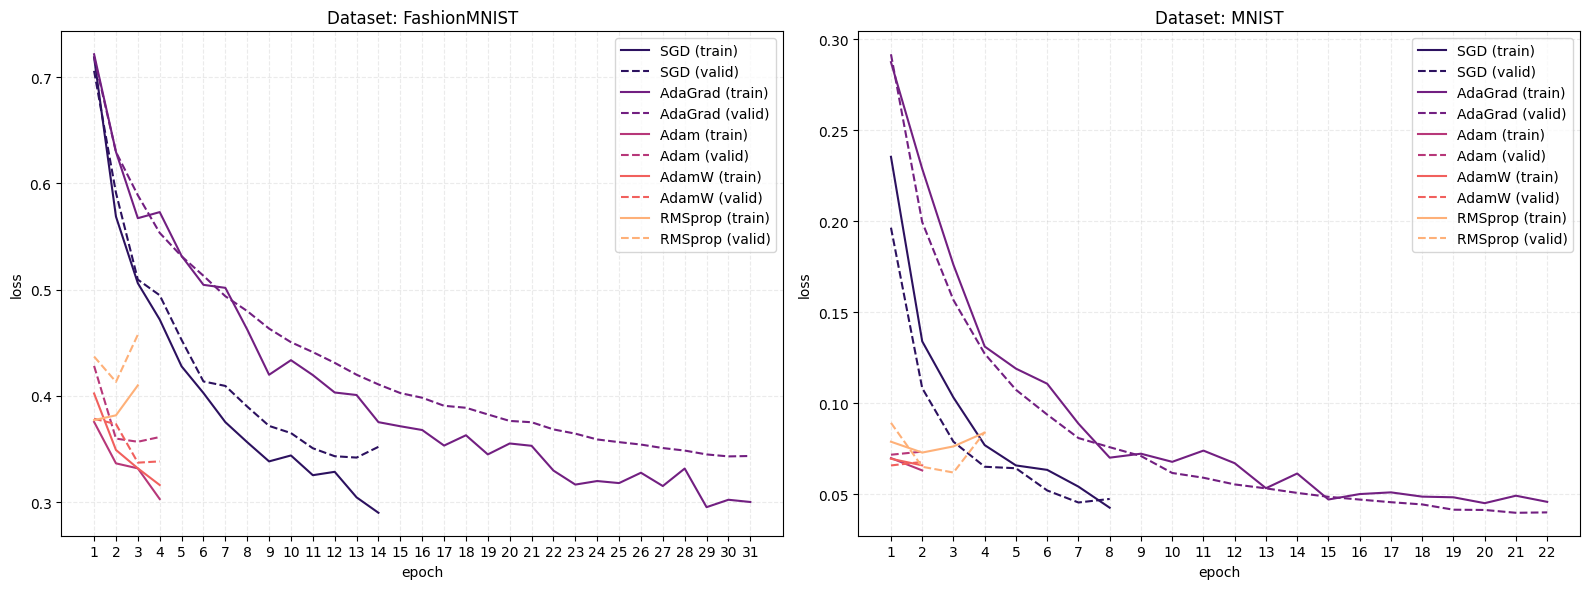

In [11]:
cols = len(datasets)
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(8 * cols, 6), tight_layout=True)
colors = sns.color_palette("magma", len(optimizers))

for dataset_idx, (dataset_name, dataset) in enumerate(datasets.items()):
    max_epochs = 0
    for optimizer_idx, (optimizer_name, optimizer) in enumerate(optimizers.items()):
        results_df = pd.read_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv")
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["train_loss"],
            label=f"{optimizer_name} (train)",
            color=colors[optimizer_idx],
        )
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["valid_loss"],
            label=f"{optimizer_name} (valid)",
            color=colors[optimizer_idx],
            linestyle="--",
        )
        if len(results_df["epoch"]) > max_epochs:
            max_epochs = len(results_df["epoch"])

    ax[dataset_idx].set_title(f"Dataset: {dataset_name}")
    ax[dataset_idx].set_xticks(np.arange(1, max_epochs + 1, step=1))
    ax[dataset_idx].set_xlabel("epoch")
    ax[dataset_idx].set_ylabel("loss")
    ax[dataset_idx].grid(linestyle="--", alpha=0.25)
    ax[dataset_idx].legend()

fig.savefig(f"{RESULT_PATH}/plot_loss.png")

In [43]:
def predict(images):
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    return predicted.cpu().numpy()

def get_validation_images_and_labels(valid_loader, num_images=5):
    images, labels = next(iter(valid_loader))
    images = images[:num_images]
    labels = labels[:num_images]
    return images, labels

fashion_mnist_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

DATASET: FashionMNIST


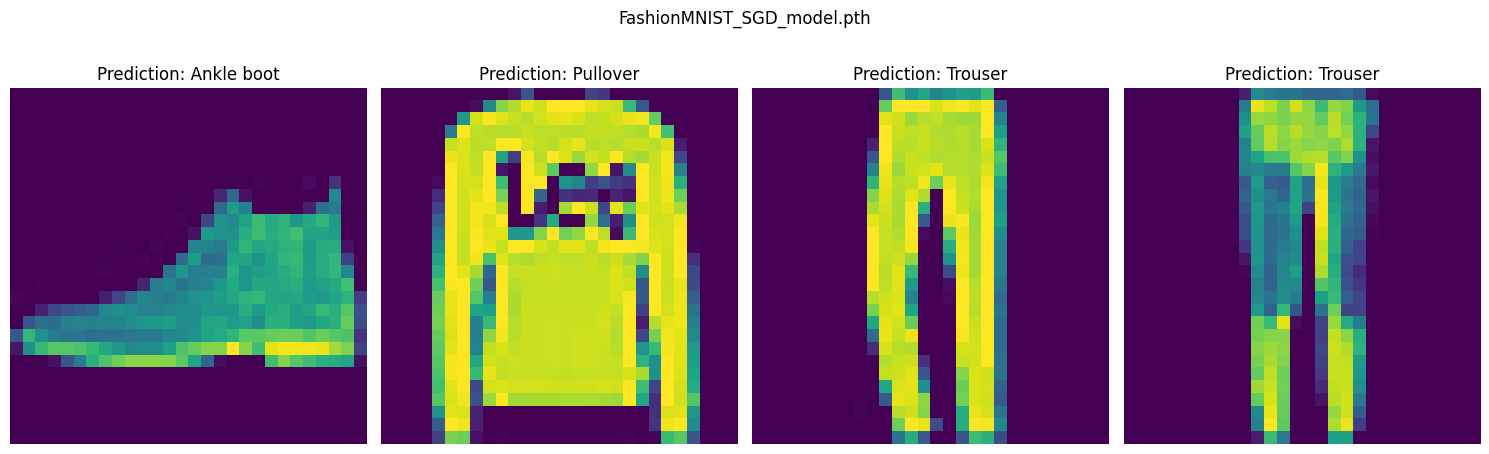

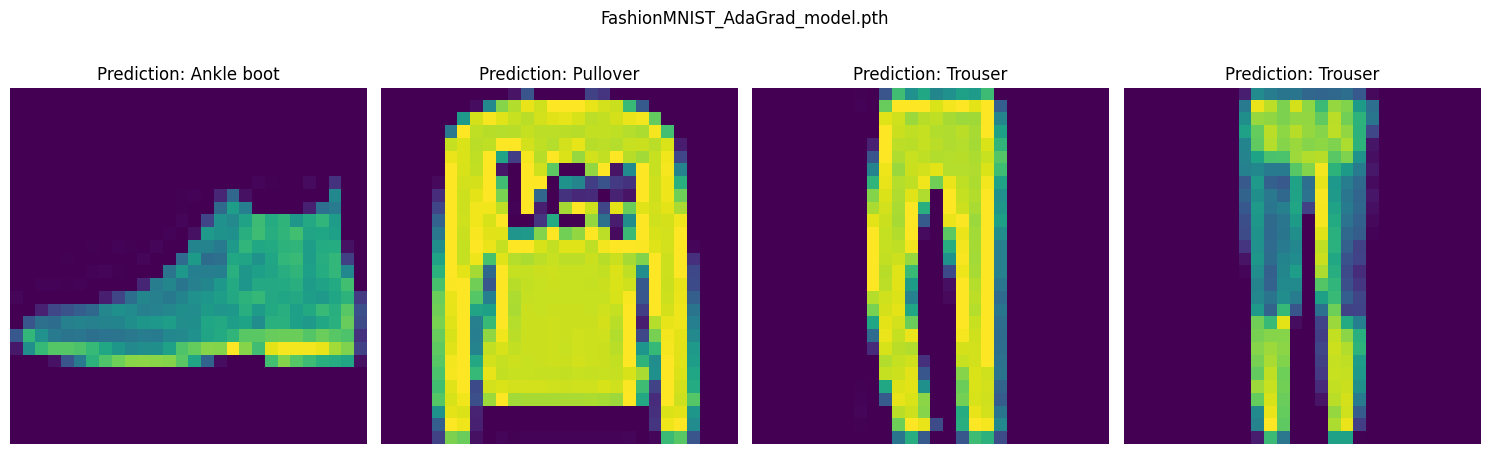

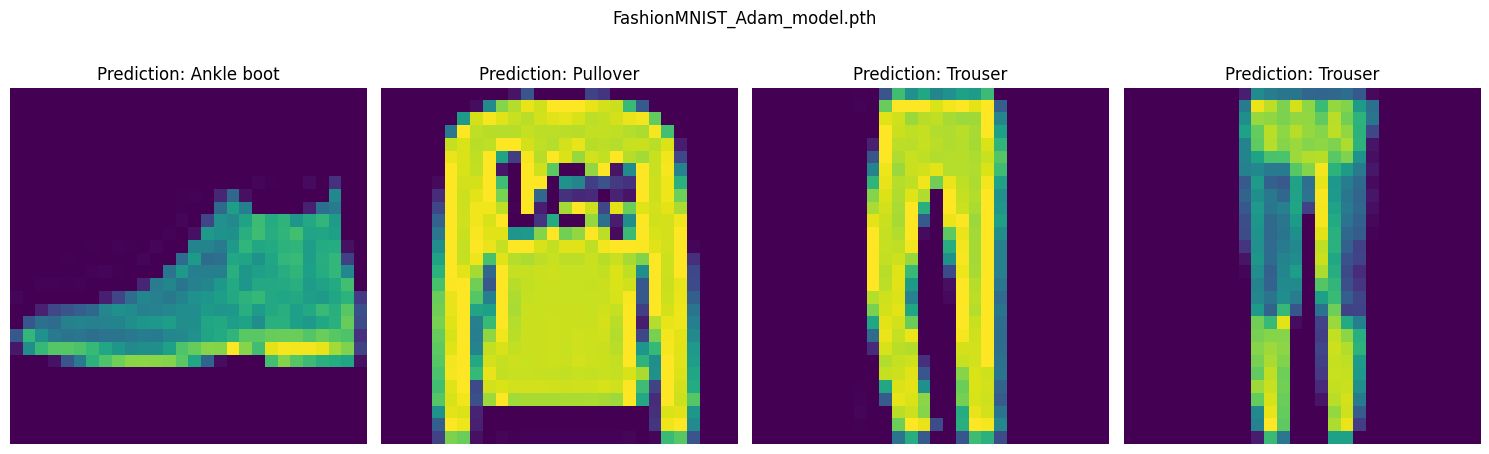

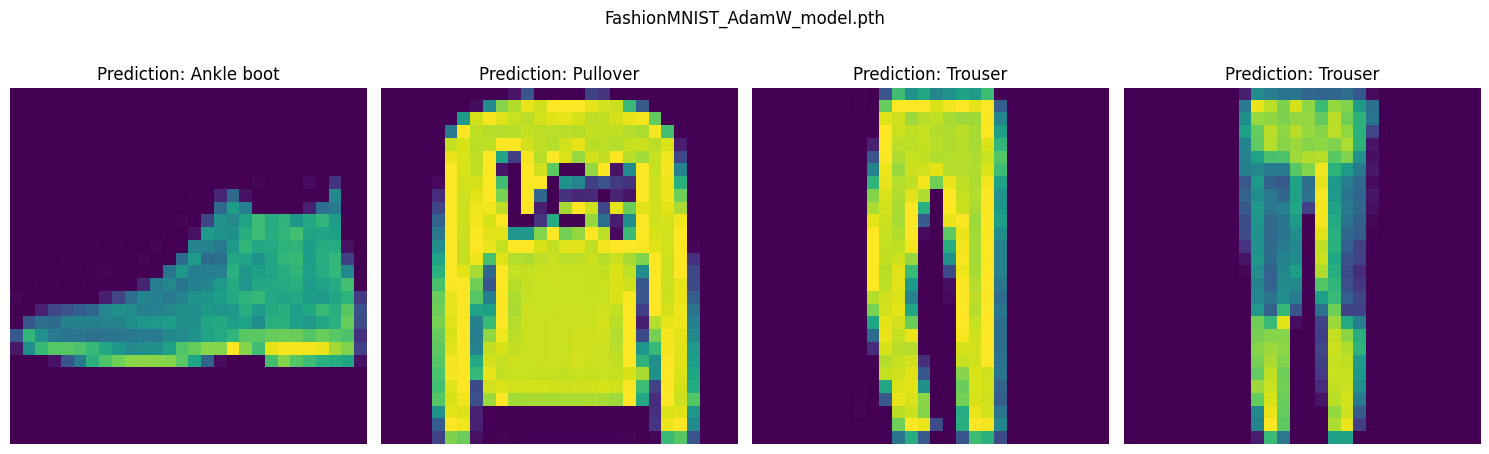

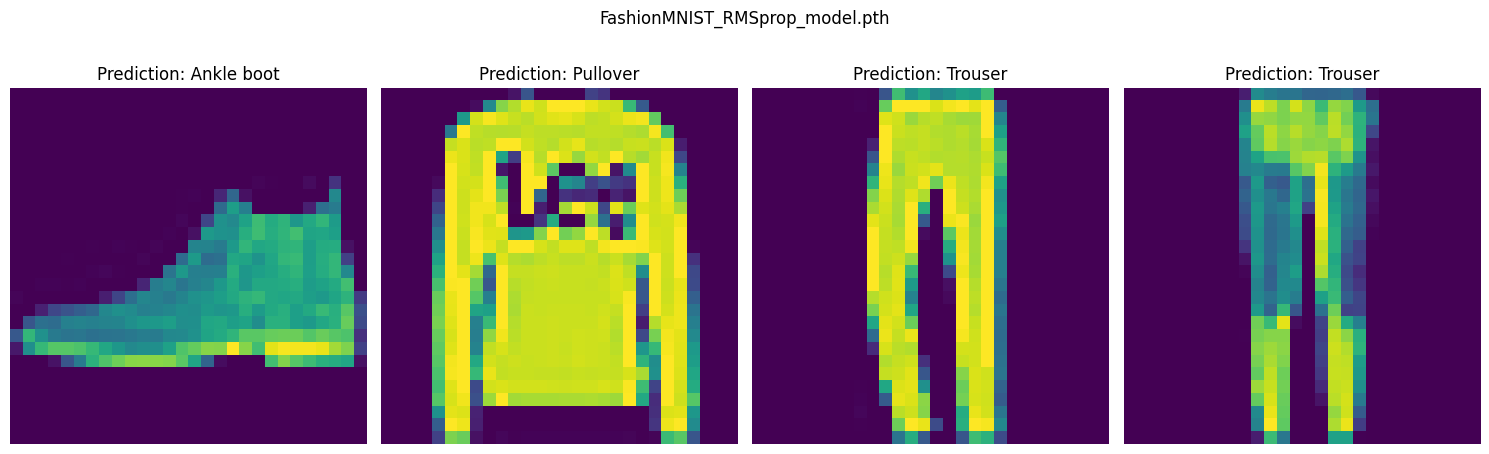

DATASET: MNIST


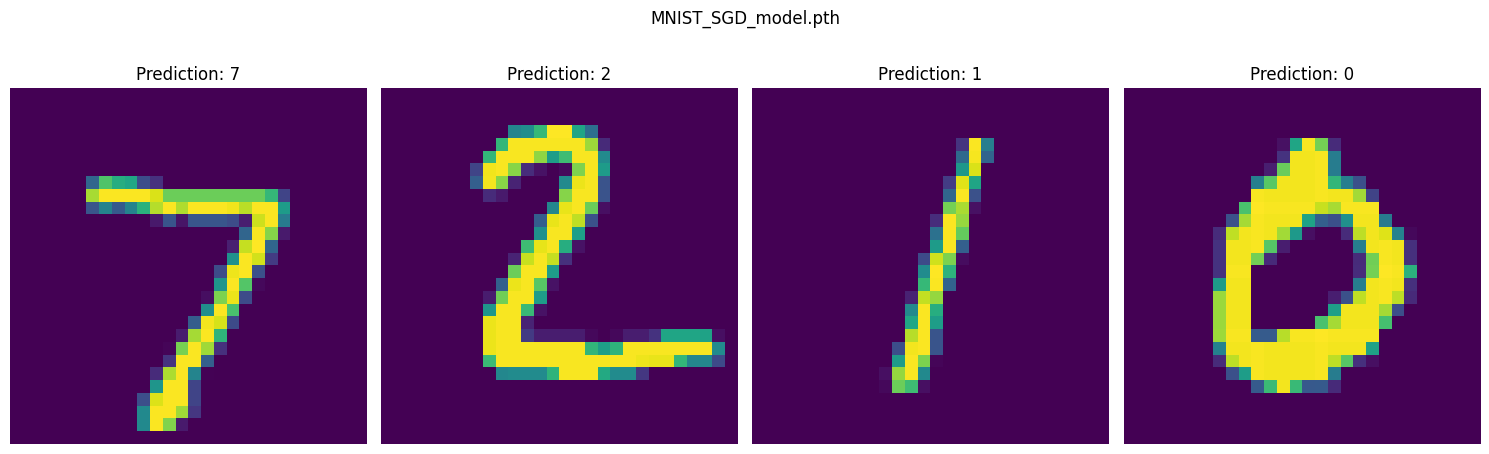

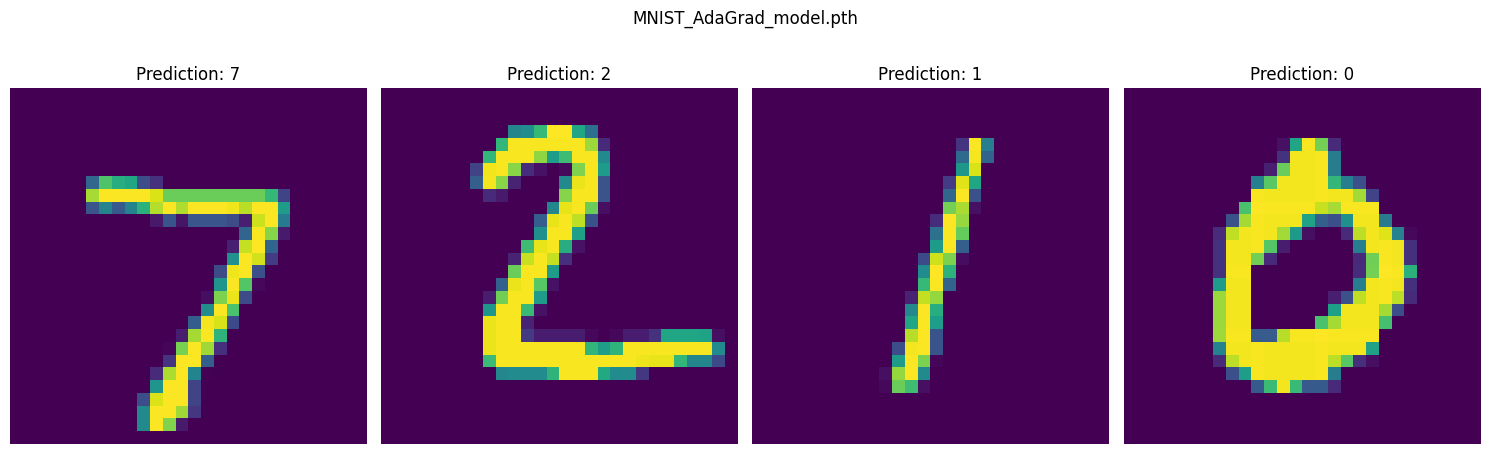

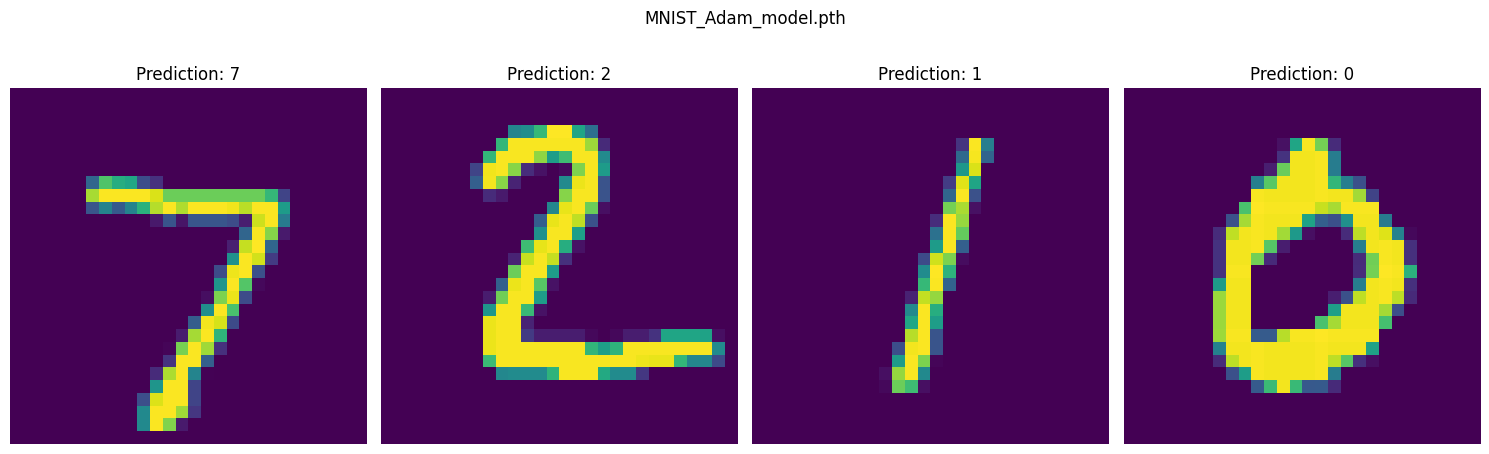

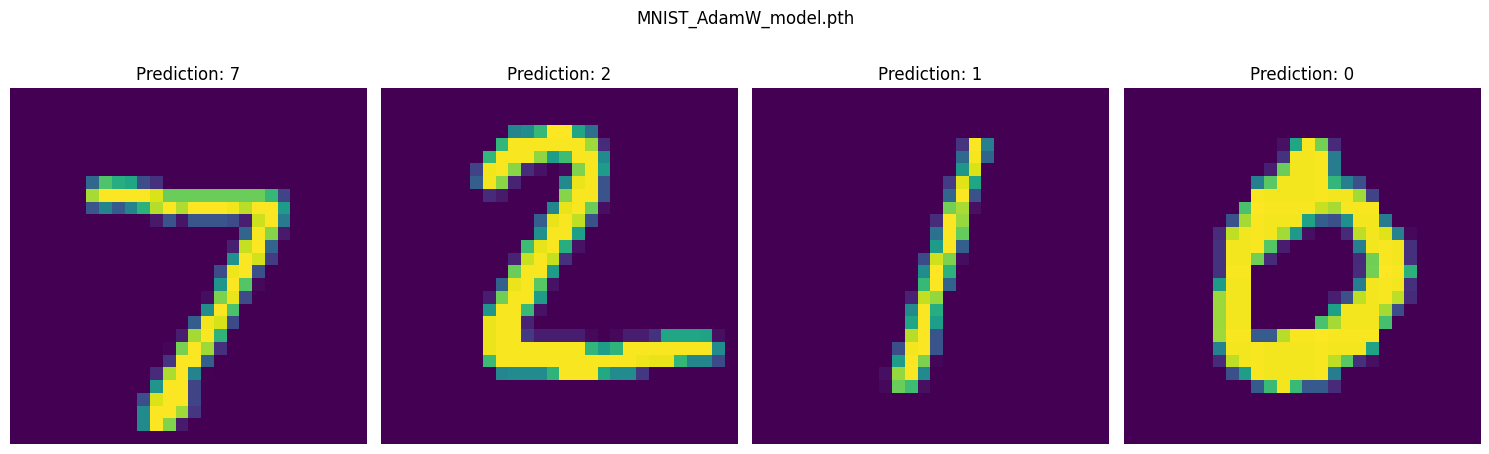

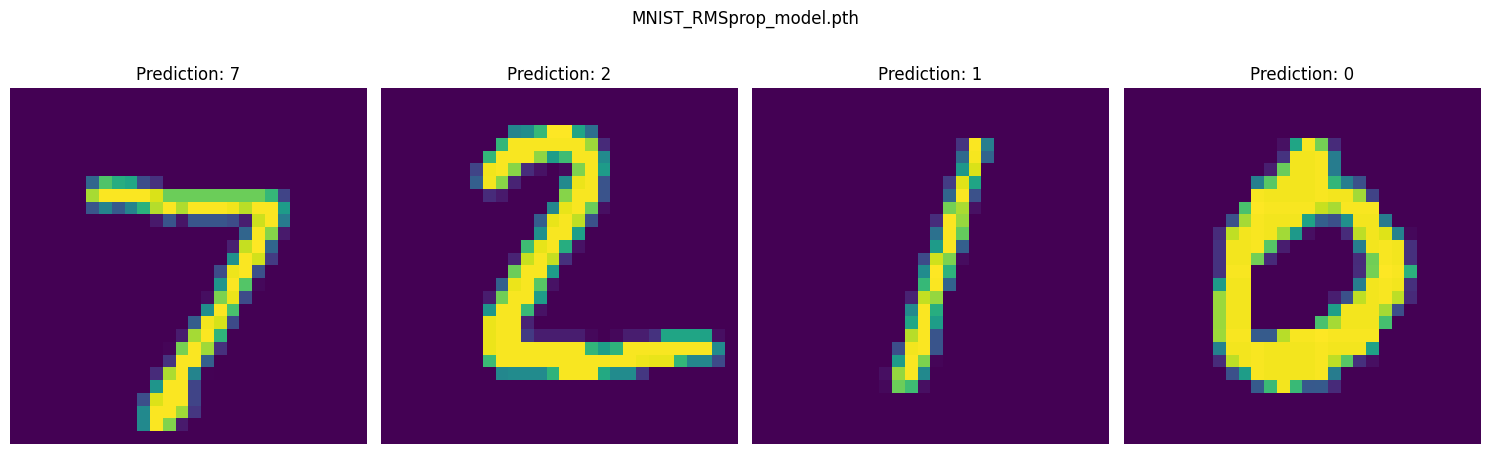

In [47]:

for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    train_loader, valid_loader = get_dataset(dataset)

    for optimizer_name in optimizers:
      model = CNNClassifier()
      model.load_state_dict(torch.load(f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth"))
      model.to(device)
      model.eval()

      images, paths = get_validation_images_and_labels(valid_loader, num_images=5)
      image_predictions = {}

      for i, (image, path) in enumerate(zip(images, paths)):
          prediction = predict(image)
          image_predictions[i] = prediction

      fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
      if len(images) == 1:
          axes = [axes]

      fig.suptitle(f"{dataset_name}_{optimizer_name}_model.pth")
      for ax, image, i in zip(axes, images, range(len(images))):
          ax.imshow(image[0])
          if "Fashion" in dataset_name:
            ax.set_title(f'Prediction: {fashion_mnist_labels[image_predictions[i][0]]}')
          else:
            ax.set_title(f'Prediction: {image_predictions[i][0]}')
          ax.axis('off')
      plt.tight_layout()
      plt.savefig(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_model.png")
      plt.show()